# Preamble

In [5]:
pip install fpqr
# We instal the fPQR algorithm

In [1]:
help('fpqr')

Help on package fpqr:

NAME
    fpqr

PACKAGE CONTENTS
    fast_partial_quantile_regression
    quantile_covariances

FILE
    c:\users\jorge\anaconda3\lib\site-packages\fpqr\__init__.py




In [6]:
pip install Mosek
# We install the Mosek (convex) optimization solver. If not, a warning rises when fitting fpqr saying
# an alternative (free) solver was used

SyntaxError: invalid syntax (1860544526.py, line 1)

In [7]:
help('Mosek')

No Python documentation found for 'Mosek'.
Use help() to get the interactive help utility.
Use help(str) for help on the str class.



In [317]:
pip install pingouin

To start interactive mode with plots, run '%matplotlib notebook' and then import matplotlib.pyplot. To close interaction mode and go back to static mode, run '%matplotlib inline'.

In [798]:
%matplotlib notebook

In [804]:
import matplotlib.pyplot as plt

In [803]:
%matplotlib inline

In [88]:
# Import the necessary packages

import math
import numpy as np
import pandas as pd
import fpqr
import asgl #este paquete tabién es de Álvaro, tiene reg. lineal y quantílica penalizadas (usarlo?)
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import random
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import warnings
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize
import functools
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import lognorm
import pickle
from datetime import datetime
from pingouin import multivariate_normality
import matplotlib.patches as mpatches
import statsmodels.api as sm
from sklearn.utils.fixes import parse_version, sp_version
from sklearn.linear_model import QuantileRegressor
from matplotlib.font_manager import FontProperties

In [9]:
fpqr.__doc__

In [318]:
def _quantile_function2(y_true, y_pred, tau):
    """
    Quantile function required for error computation
    """
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
        y_pred = y_pred.reshape(-1, 1)
    return (1.0 / y_true.size) * np.sum(0.5 * np.abs(y_true - y_pred) + (tau - 0.5) * (y_true - y_pred))

This function is extracted from the fPQR code. With '.reshape(-1, 1)' the matrices are folded into vectors, 'y_true.size' returns the total number of elements in y_true, i.e. n\*m, with 'np.abs(y_true - y_pred, 0)' the absolute value is computed element wise, and with 'np.sum()' the sum of elements is computed, calculating the mean value of the erros when scaling with '(1.0 / y_true.size)'. That is, it is considering, if $u=y\_true-y\_pred$, where $y\_true$ and $y\_pred$ are vectors of size $n$ from respective random variables observed on a sample of $n$ individuals, then the quantile error is
$$QE_{\tau}(y\_true,y\_pred)=\frac{1}{n}\sum_{i=1}^n\rho_{\tau}(y\_true_i-y\_pred_i).$$
Now, if  $y\_true$ and $y\_pred$ are matrices of size $nxm$ from respective random vectors of size $m$ observed on a sample of $n$ individuals, then the quantile error is defined as (following the 'def _quantile_function2(y_true, y_pred, tau)' extracted from the fPQR code, that now turns out to be wrong)
$$QE_{\tau}(y\_true,y\_pred)=\frac{1}{n\cdot m}\sum_{i=1}^n\sum_{j=1}^m\rho_{\tau}(y\_true_{ij}-y\_pred_{ij}).$$
The problem is it considers
$$\rho_{\tau}(u)=u(\tau-I(u<0))=0.5|u|+(\tau-0.5)u,$$ 
and there is no proof of that. What has been proven is
$$\rho_{\tau}(u)=u(\tau-I(u<0))=\tau\max(u,0)+(1-\tau)\max(-u,0).$$
This is why we define the folowwing function, that will be used in the results.

In [321]:
def _quantile_function(y_true, y_pred, tau):
    """
    Quantile function required for error computation
    """
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
        y_pred = y_pred.reshape(-1, 1)
    return (1.0 / y_true.size) * np.sum(tau * np.max(y_true - y_pred, 0) + (1 - tau) * np.max(y_pred - y_true, 0))

With '.reshape(-1, 1)' the matrices are folded into vectors, 'y_true.size' returns the total number of elements in y_true, i.e. n\*m, with 'np.max(y_true - y_pred, 0)' the maximum is computed element wise, and with 'np.sum()' the sum of elements is computed, calculating the mean value of the erros when scaling. That is, since
$$\rho_{\tau}(u)=u(\tau-I(u<0))=\tau\max(u,0)+(1-\tau)\max(-u,0)$$
if $u=y\_true-y\_pred$, where $y\_true$ and $y\_pred$ are vectors of size $n$ from respective random variables observed on a sample of $n$ individuals, then the quantile error is
$$QE_{\tau}(y\_true,y\_pred)=\frac{1}{n}\sum_{i=1}^n\rho_{\tau}(y\_true_i-y\_pred_i).$$
Now, if  $y\_true$ and $y\_pred$ are matrices of size $nxm$ from respective random vectors of size $m$ observed on a sample of $n$ individuals, then the quantile error is defined as (following the 'def _quantile_function2(y_true, y_pred, tau)' extracted from the fPQR code, that now turns out to be wrong)
$$QE_{\tau}(y\_true,y\_pred)=\frac{1}{n\cdot m}\sum_{i=1}^n\sum_{j=1}^m\rho_{\tau}(y\_true_{ij}-y\_pred_{ij}).$$
This is the same idea followed by 'mean_squared_error' when working with matrices.

In [322]:
def _rho_function(x, tau):
    """
    Check loss function in quantile regression
    """
    return tau * np.maximum(x, 0) + (1 - tau) * np.maximum(-x, 0)

In [323]:
def _center_matrix(x):
        x_mean = x.mean(axis=0)
        x2 = x - x_mean
        return x2

In [324]:
def _standar_matrix(x):
        x_mean = x.mean(axis=0)
        x_sd = x.std(axis=0)
        x2 = (x - x_mean)/ x_sd
        return x2

# Simulation study

### Simulated data

In [224]:
X = np.random.normal(0, 1, size = (100, 100))
B_significant = np.random.uniform(0, 1, size = (30, 3))
B_noise = np.zeros((70, 3))
B = np.concatenate((B_significant, B_noise))
E = np.random.chisquare(3, size = (100, 3))
Y = X@B+E

### Simulated data with correlation among $X$ variables, with and without outliers in $X$

Generate a covariance matrix $\Sigma$ with non-zero values in the non-diagonal entries so there is correlation among variables of $X$ that is symmetric and positive definite (all covariance matrices are)

In [131]:
sample_size = 100
cov_matrix = np.random.uniform(-5, 5, size = (100, 100)) # np.array([[2.0, 0.5], [0.5, 1.0]])
cov_matrix = np.tril(cov_matrix)  # Zero out the upper triangle
cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
if min_eigenvalue <= 0:
    diagonal_addition = np.eye(sample_size) * (-min_eigenvalue + 1e-6)
    cov_matrix += diagonal_addition

Check if matrix is symmetric. We compute the SVD decomposition. If symmetric we will have $\Sigma=PDP'=UDV$ and we compare if $U-V'$ is numerically $0$.

In [132]:
np.all(np.linalg.svd(cov_matrix)[0] - np.linalg.svd(cov_matrix)[2].T < 1e-14)

True

Check if matrix is positive definite by checking if all eigenvalues are positive

In [133]:
np.all(np.linalg.eigvals(cov_matrix) > 0)

True

In the fitting of algorithms, in paper fPQR they select 30 as the number of components since 30 are the relevant variables for simulating $Y$ from $X$. This is not a compulsory thing to do since the latent structure of variables $T$ is obtained from the regressors $X$ but the optimal number of components are selected in prediciction via CV

## New simulation with outliers

Since the MSE in prediction for the previous dataset doesn't show a lack of robustness in PLS (the error diminishes in the dataset with outliers in fPQR but also in PLS), we are going to change the outliers. It doesn't seem reasonable to include outliers in $X_{out}$ and from it generate a new $Y_{out}=X_{out}B+E$, that contains different values than $Y$ in the same entries of the outliers for $X$. The reason this doesn't seem reasonable to be outliers is that the points are significantly different both in $X$ and $Y$ so the regression line might not change inclination (it has to do with leverage). To define an outliers that truly damages the least squares fitting of PLS we need to change $y_i$ for the same $x_i$.

First we are going to check robustness against outliers, so the parametric assumptions of PLS are going to be satisfied (normality and homocedasticity of residuals).

In [732]:
sample_size = 100
number_of_ind_variables = 100
number_of_dep_variables = 3
number_of_significant_ind_variables = 30
number_of_components = number_of_significant_ind_variables

cov_matrix = np.random.uniform(-5, 5, size = (number_of_ind_variables, number_of_ind_variables))
cov_matrix = np.tril(cov_matrix)  # Zero out the upper triangle
cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
if min_eigenvalue <= 0:
    diagonal_addition = np.eye(number_of_ind_variables) * (-min_eigenvalue + 1e-6)
    cov_matrix += diagonal_addition

# Define the mean vector
mean = np.zeros(number_of_ind_variables)

# Sample data
X = np.random.multivariate_normal(mean, np.identity(number_of_ind_variables), sample_size)
B_significant = np.random.uniform(0, 1, size = (number_of_significant_ind_variables, number_of_dep_variables))
B_noise = np.zeros((number_of_ind_variables - number_of_significant_ind_variables, number_of_dep_variables))
#B = np.concatenate((B_significant, B_noise))
B = np.random.uniform(0, 1, size = (number_of_ind_variables, number_of_dep_variables))
E = np.random.normal(0, 1, size=(sample_size, number_of_dep_variables))
Y = X@B+E

In [733]:
E_alternative = np.random.normal(3, 20, size=(sample_size, number_of_dep_variables))

In [734]:
outliers_entries = np.random.choice(np.arange(0, len(X)), size=int(0.05*len(X)), replace=False) # 5% of outliers

E_out = E.copy()
E_out[outliers_entries,:] = E_alternative[outliers_entries,:]

Y_out = X@B + E_out

In [735]:
outliers_entries

array([40, 77, 44, 30, 20])

In [736]:
#pd.DataFrame(Y)

In [737]:
#pd.DataFrame(Y_out)

In [738]:
X_train, X_test, Y_train, Y_test, Y_train_out, Y_test_out = train_test_split(X, Y, Y_out, train_size=0.8, random_state=123)

#### PLS

#### Without outliers

In [739]:
start_time_pls = time.time()

pls_model = PLSRegression(n_components=30)  # By using PLS we regress to the mean
pls_model.fit(X_train, Y_train)

end_time_pls = time.time()
execution_time_pls = end_time_pls - start_time_pls

B_estimated_pls = pls_model.coef_
predictions_pls = pls_model.predict(X_test)

mse_coef_pls = mean_squared_error(B, B_estimated_pls)
mse_pred_pls = mean_squared_error(Y_test, predictions_pls)
qe_pred_pls = _quantile_function(Y_test, predictions_pls, 0.5)

print("Execution time PLS:", execution_time_pls, "seconds")
print("MSE coef PLS:", mse_coef_pls)
print("MSE pred PLS:", mse_pred_pls)
print("Quantile error pred PLS:", qe_pred_pls)

Execution time PLS: 0.020361661911010742 seconds
MSE coef PLS: 0.11619146371648899
MSE pred PLS: 10.093624254015031
Quantile error pred PLS: 1.2714882461384556


C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


#### With outliers

In [740]:
start_time_pls_out = time.time()

pls_model_out = PLSRegression(n_components=30)  # By using PLS we regress to the mean
pls_model_out.fit(X_train, Y_train_out)

end_time_pls_out = time.time()
execution_time_pls_out = end_time_pls_out - start_time_pls_out

B_estimated_pls_out = pls_model_out.coef_
predictions_pls_out = pls_model_out.predict(X_test)

mse_coef_pls_out = mean_squared_error(B, B_estimated_pls_out)
mse_pred_pls_out = mean_squared_error(Y_test_out, predictions_pls_out)
qe_pred_pls_out = _quantile_function(Y_test_out, predictions_pls_out, 0.5)

print("Execution time PLS outliers:", execution_time_pls_out, "seconds")
print("MSE coef PLS outliers:", mse_coef_pls_out)
print("MSE pred PLS outliers:", mse_pred_pls_out)
print("Quantile error pred PLS outliers:", qe_pred_pls_out)

Execution time PLS outliers: 0.016696453094482422 seconds
MSE coef PLS outliers: 0.8318452610361623
MSE pred PLS outliers: 127.5216199395656
Quantile error pred PLS outliers: 4.0641173915484226


C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


#### fPQR Li

#### Without outliers

In [741]:
start_time_li = time.time()

fpqr_li = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='li')
fpqr_li.fit(X_train, Y_train)

end_time_li = time.time()
execution_time_li = end_time_li - start_time_li

B_estimated_li = fpqr_li.coef_
predictions_li = fpqr_li.predict(X_test)

mse_coef_li = mean_squared_error(B, B_estimated_li)
mse_pred_li = mean_squared_error(Y_test, predictions_li)
qe_pred_li = _quantile_function(Y_test,predictions_li,0.5)

print("Execution time Li:", execution_time_li, "seconds")
print("MSE coef Li:", mse_coef_li)
print("MSE pred Li:", mse_pred_li)
print("Quantile error pred Li:", qe_pred_li)

Execution time Li: 0.08701872825622559 seconds
MSE coef Li: 0.11391475178274639
MSE pred Li: 8.866960924719477
Quantile error pred Li: 1.1988291858160032


#### With outliers

In [742]:
start_time_li_out = time.time()

fpqr_li_out = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='li')
fpqr_li_out.fit(X_train, Y_train_out)

end_time_li_out = time.time()
execution_time_li_out = end_time_li_out - start_time_li_out

B_estimated_li_out = fpqr_li_out.coef_
predictions_li_out = fpqr_li_out.predict(X_test)

mse_coef_li_out = mean_squared_error(B, B_estimated_li_out)
mse_pred_li_out = mean_squared_error(Y_test_out, predictions_li_out)
qe_pred_li_out = _quantile_function(Y_test_out, predictions_li_out, 0.5)

print("Execution time Li outliers:", execution_time_li_out, "seconds")
print("MSE coef Li outliers:", mse_coef_li_out)
print("MSE pred Li outliers:", mse_pred_li_out)
print("Quantile error pred Li outliers:", qe_pred_li_out)

Execution time Li outliers: 0.09150409698486328 seconds
MSE coef Li outliers: 0.5055490354539446
MSE pred Li outliers: 72.53347218952527
Quantile error pred Li outliers: 3.0314427537070996


fPQR no parece muy robusto en MSE prediction

#### fPQR Dodge

#### Without outliers

In [98]:
start_time_dodge = time.time()

fpqr_dodge = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='dodge')
fpqr_dodge.fit(X_train, Y_train)

end_time_dodge = time.time()
execution_time_dodge = end_time_dodge - start_time_dodge

B_estimated_dodge = fpqr_dodge.coef_
predictions_dodge = fpqr_dodge.predict(X_test)

mse_coef_dodge = mean_squared_error(B, B_estimated_dodge)
mse_pred_dodge = mean_squared_error(Y_test, predictions_dodge)
qe_pred_dodge = _quantile_function(Y_test,predictions_dodge,0.5)

print("Execution time Dodge:", execution_time_dodge, "seconds")
print("MSE coef Dodge:", mse_coef_dodge)
print("MSE pred Dodge:", mse_pred_dodge)
print("Quantile error pred Dodge:", qe_pred_dodge)

Execution time Dodge: 286.1994159221649 seconds
MSE coef Dodge: 0.015963543534897276
MSE pred Dodge: 83.81240791934442
Quantile error pred Dodge: 3.7636590332002156


#### With outliers

In [99]:
start_time_dodge_out = time.time()

fpqr_dodge_out = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='dodge')
fpqr_dodge_out.fit(X_train, Y_train_out)

end_time_dodge_out = time.time()
execution_time_dodge_out = end_time_dodge_out - start_time_dodge_out

B_estimated_dodge_out = fpqr_dodge_out.coef_
predictions_dodge_out = fpqr_dodge_out.predict(X_test)

mse_coef_dodge_out = mean_squared_error(B, B_estimated_dodge_out)
mse_pred_dodge_out = mean_squared_error(Y_test_out, predictions_dodge_out)
qe_pred_dodge_out = _quantile_function(Y_test_out, predictions_dodge_out, 0.5)

print("Execution time Dodge outliers:", execution_time_dodge_out, "seconds")
print("MSE coef Dodge outliers:", mse_coef_dodge_out)
print("MSE pred Dodge outliers:", mse_pred_dodge_out)
print("Quantile error pred Dodge outliers:", qe_pred_dodge_out)

Execution time Dodge outliers: 284.51434421539307 seconds
MSE coef Dodge outliers: 0.03975384304904079
MSE pred Dodge outliers: 351.2805403407069
Quantile error pred Dodge outliers: 7.729489633013288


#### fPQR Choi

#### Without outliers

In [100]:
start_time_choi = time.time()

fpqr_choi = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='choi')
fpqr_choi.fit(X_train, Y_train)

end_time_choi = time.time()
execution_time_choi = end_time_choi - start_time_choi

B_estimated_choi = fpqr_choi.coef_
predictions_choi = fpqr_choi.predict(X_test)

mse_coef_choi = mean_squared_error(B, B_estimated_choi)
mse_pred_choi = mean_squared_error(Y_test, predictions_choi)
qe_pred_choi = _quantile_function(Y_test, predictions_choi, 0.5)

print("Execution time Choi:", execution_time_choi, "seconds")
print("MSE coef Choi:", mse_coef_li)
print("MSE pred Choi:", mse_pred_li)
print("Quantile error pred Choi:", qe_pred_li)

Execution time Choi: 564.6645827293396 seconds
MSE coef Choi: 0.018572545021720902
MSE pred Choi: 105.79053781428912
Quantile error pred Choi: 4.1391324940864225


#### With outliers

In [101]:
start_time_choi_out = time.time()

fpqr_choi_out = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='choi')
fpqr_choi_out.fit(X_train, Y_train_out)

end_time_choi_out = time.time()
execution_time_choi_out = end_time_choi_out - start_time_choi_out

B_estimated_choi_out = fpqr_choi_out.coef_
predictions_choi_out = fpqr_choi_out.predict(X_test)

mse_coef_choi_out = mean_squared_error(B, B_estimated_choi_out)
mse_pred_choi_out = mean_squared_error(Y_test_out, predictions_choi_out)
qe_pred_choi_out = _quantile_function(Y_test_out, predictions_choi_out, 0.5)

print("Execution time Choi outliers:", execution_time_choi_out, "seconds")
print("MSE coef Choi outliers:", mse_coef_choi_out)
print("MSE pred Choi outliers:", mse_pred_choi_out)
print("Quantile error pred Choi outliers:", qe_pred_choi_out)

Execution time Choi outliers: 564.7728760242462 seconds
MSE coef Choi outliers: 0.07624122194227119
MSE pred Choi outliers: 574.5225766278709
Quantile error pred Choi outliers: 9.769466900043406


### Bar plot

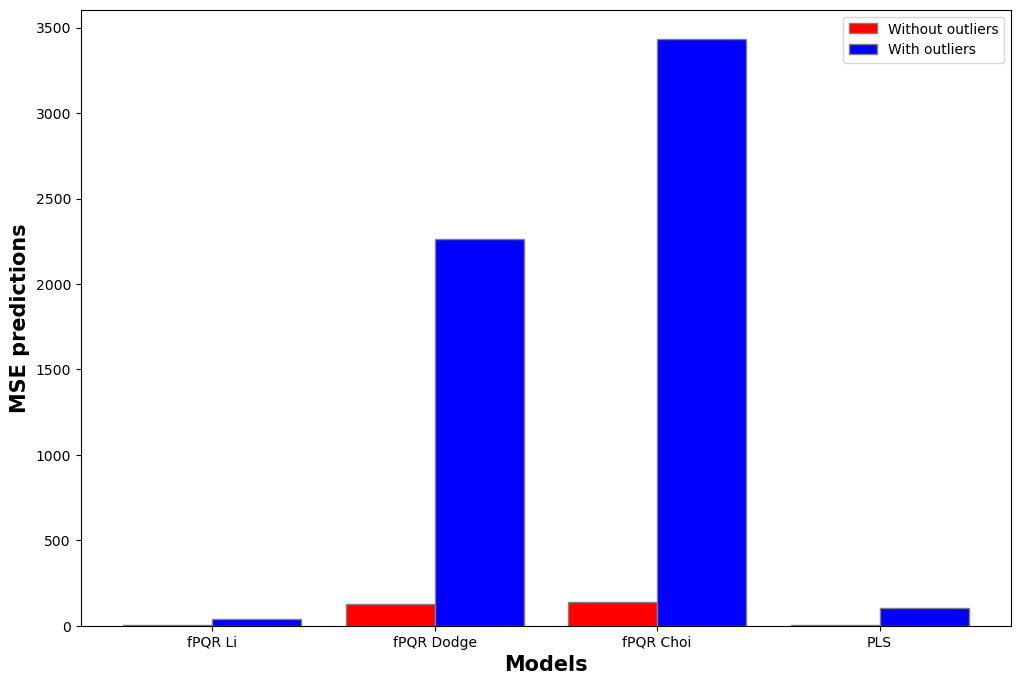

In [442]:
# set width of bar
barWidth = 0.40
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
without_outliers = [mse_pred_li, mse_pred_dodge, mse_pred_choi, mse_pred_pls]
with_outliers = [mse_pred_li_out, mse_pred_dodge_out, mse_pred_choi_out, mse_pred_pls_out]
 
# Set position of bar on X axis
br1 = np.arange(len(without_outliers))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, without_outliers, color ='r', width = barWidth,
        edgecolor ='grey', label ='Without outliers')
plt.bar(br2, with_outliers, color ='b', width = barWidth,
        edgecolor ='grey', label ='With outliers')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('MSE predictions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(without_outliers))],
        ['fPQR Li', 'fPQR Dodge', 'fPQR Choi', 'PLS'])
 
plt.legend()
plt.show()

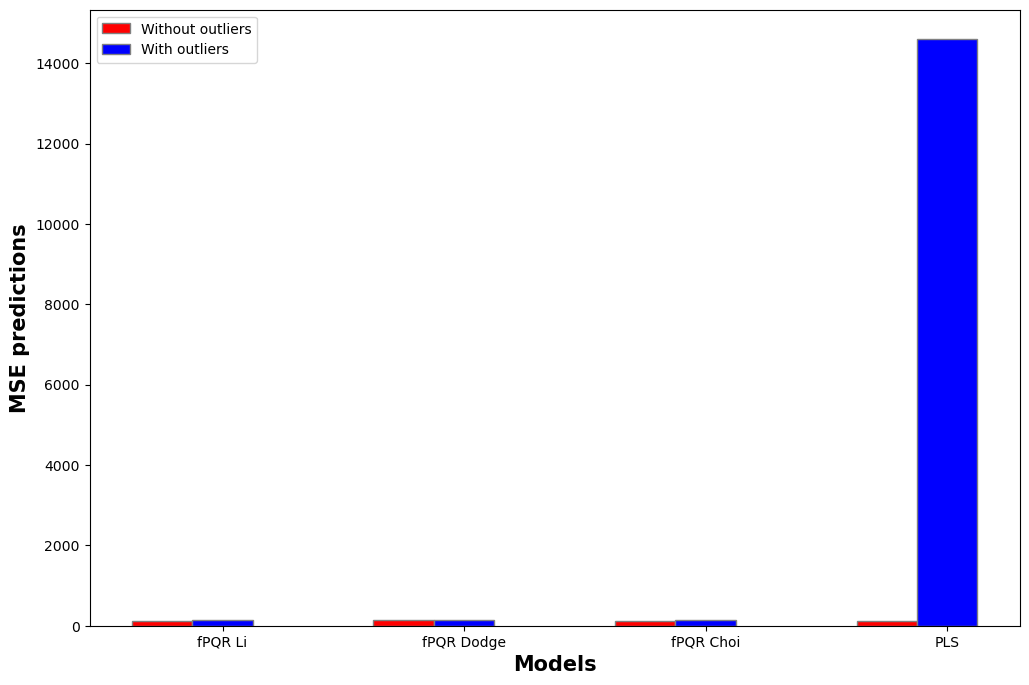

In [1314]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
without_outliers = [mse_pred_li, mse_pred_dodge, mse_pred_choi, mse_pred_pls]
with_outliers = [mse_pred_li_out, mse_pred_dodge_out, mse_pred_choi_out, mse_pred_pls_out]
 
# Set position of bar on X axis
br1 = np.arange(len(without_outliers))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, without_outliers, color ='r', width = barWidth,
        edgecolor ='grey', label ='Without outliers')
plt.bar(br2, with_outliers, color ='b', width = barWidth,
        edgecolor ='grey', label ='With outliers')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('MSE predictions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(without_outliers))],
        ['fPQR Li', 'fPQR Dodge', 'fPQR Choi', 'PLS'])
 
plt.legend()
plt.show()

## New outlier simulation with 

## Simulation violating parametric assumptions (non-normal and heterocedastic residuals)

#### Data with normal homocedastic residuals

In [105]:
sample_size = 100

# Define the covariance matrix
cov_matrix = np.random.uniform(-5, 5, size = (100, 100)) # np.array([[2.0, 0.5], [0.5, 1.0]])
cov_matrix = np.tril(cov_matrix)  # Zero out the upper triangle
cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
if min_eigenvalue <= 0:
    diagonal_addition = np.eye(sample_size) * (-min_eigenvalue + 1e-6)
    cov_matrix += diagonal_addition
    
# Define the mean vector 
mean = np.random.randint(-10, 11, sample_size)

# Simulate X
X = np.random.multivariate_normal(mean, cov_matrix, sample_size)

# Define Y
B_significant = np.random.uniform(0, 1, size = (30, 3))
B_noise = np.zeros((70, 3))
B = np.concatenate((B_significant, B_noise))
E = np.random.normal(0, 1, size=(sample_size, 3))
Y = X@B+E

#### Data with non-normal heterocedastic residuals

We use the same $X$ and $B$. Just simulate different error $E$.

In [106]:
E_pre = np.zeros((sample_size, 3))

for i in range(E_pre.shape[0]): 
    # Generate random values for each row
    E_pre[i, :] = np.random.chisquare(random.randint(1, 10), size=3)

F = np.zeros((sample_size, 3))

for i in range(F.shape[0]): 
    # Generate random values for each row
    F[i, :] = np.random.gamma(random.randint(1, 10), size=3)

entries = np.random.choice(np.arange(0, len(E)), size=int(0.1*len(E)), replace=False)

E_out = E_pre.copy()
E_out[entries,:] = F[entries,:]

In [107]:
Y_out = X@B+E_out

In [108]:
X_train, X_test, Y_train, Y_test, Y_train_out, Y_test_out = train_test_split(X, Y, Y_out, train_size=0.8, random_state=123)

#### fPQR Li

#### Normal homocedastic

In [109]:
start_time_li = time.time()

fpqr_li = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='li')
fpqr_li.fit(X_train, Y_train)

end_time_li = time.time()
execution_time_li = end_time_li - start_time_li

B_estimated_li = fpqr_li.coef_
predictions_li = fpqr_li.predict(X_test)

mse_coef_li = mean_squared_error(B, B_estimated_li)
mse_pred_li = mean_squared_error(Y_test, predictions_li)
qe_pred_li = _quantile_function(Y_test,predictions_li,0.5)

print("Execution time Li:", execution_time_li, "seconds")
print("MSE coef Li:", mse_coef_li)
print("MSE pred Li:", mse_pred_li)
print("Quantile error pred Li:", qe_pred_li)

Execution time Li: 1.2002630233764648 seconds
MSE coef Li: 0.03037812580111965
MSE pred Li: 125.47842775237518
Quantile error pred Li: 4.474219667532224


#### Non-normal heterocedastic

In [110]:
start_time_li_out = time.time()

fpqr_li_out = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='li')
fpqr_li_out.fit(X_train, Y_train_out)

end_time_li_out = time.time()
execution_time_li_out = end_time_li_out - start_time_li_out

B_estimated_li_out = fpqr_li_out.coef_
predictions_li_out = fpqr_li_out.predict(X_test)

mse_coef_li_out = mean_squared_error(B, B_estimated_li_out)
mse_pred_li_out = mean_squared_error(Y_test_out, predictions_li_out)
qe_pred_li_out = _quantile_function(Y_test_out,predictions_li_out,0.5)

print("Execution time Li:", execution_time_li_out, "seconds")
print("MSE coef Li:", mse_coef_li_out)
print("MSE pred Li:", mse_pred_li_out)
print("Quantile error pred Li:", qe_pred_li_out)

Execution time Li: 1.1750738620758057 seconds
MSE coef Li: 0.03802379350991561
MSE pred Li: 195.37480124156446
Quantile error pred Li: 5.960064863531467


#### fPQR Dodge

#### Normal homocedastic

In [111]:
start_time_dodge = time.time()

fpqr_dodge = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='dodge')
fpqr_dodge.fit(X_train, Y_train)

end_time_dodge = time.time()
execution_time_dodge = end_time_dodge - start_time_dodge

B_estimated_dodge = fpqr_dodge.coef_
predictions_dodge = fpqr_dodge.predict(X_test)

mse_coef_dodge = mean_squared_error(B, B_estimated_dodge)
mse_pred_dodge = mean_squared_error(Y_test, predictions_dodge)
qe_pred_dodge = _quantile_function(Y_test,predictions_dodge,0.5)

print("Execution time Dodge:", execution_time_dodge, "seconds")
print("MSE coef Dodge:", mse_coef_dodge)
print("MSE pred Dodge:", mse_pred_dodge)
print("Quantile error pred Dodge:", qe_pred_dodge)

Execution time Dodge: 278.4349830150604 seconds
MSE coef Dodge: 0.02834900849465043
MSE pred Dodge: 101.78713321334696
Quantile error pred Dodge: 3.995052688122142


#### Non-normal heterocedastic

In [112]:
start_time_dodge_out = time.time()

fpqr_dodge_out = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='dodge')
fpqr_dodge_out.fit(X_train, Y_train_out)

end_time_dodge_out = time.time()
execution_time_dodge_out = end_time_dodge_out - start_time_dodge_out

B_estimated_dodge_out = fpqr_dodge_out.coef_
predictions_dodge_out = fpqr_dodge_out.predict(X_test)

mse_coef_dodge_out = mean_squared_error(B, B_estimated_dodge_out)
mse_pred_dodge_out = mean_squared_error(Y_test_out, predictions_dodge_out)
qe_pred_dodge_out = _quantile_function(Y_test_out, predictions_dodge_out, 0.5)

print("Execution time Dodge:", execution_time_dodge_out, "seconds")
print("MSE coef Dodge:", mse_coef_dodge_out)
print("MSE pred Dodge:", mse_pred_dodge_out)
print("Quantile error pred Dodge:", qe_pred_dodge_out)

Execution time Dodge: 282.4301679134369 seconds
MSE coef Dodge: 0.04086525102313704
MSE pred Dodge: 210.4352066899551
Quantile error pred Dodge: 5.935651692148142


#### fPQR Choi

#### Normal homocedastic

In [113]:
start_time_choi = time.time()

fpqr_choi = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='choi')
fpqr_choi.fit(X_train, Y_train)

end_time_choi = time.time()
execution_time_choi = end_time_choi - start_time_choi

B_estimated_choi = fpqr_choi.coef_
predictions_choi = fpqr_choi.predict(X_test)

mse_coef_choi = mean_squared_error(B, B_estimated_choi)
mse_pred_choi = mean_squared_error(Y_test, predictions_choi)
qe_pred_choi = _quantile_function(Y_test, predictions_choi, 0.5)

print("Execution time Choi:", execution_time_choi, "seconds")
print("MSE coef Choi:", mse_coef_li)
print("MSE pred Choi:", mse_pred_li)
print("Quantile error pred Choi:", qe_pred_li)

Execution time Choi: 557.3847322463989 seconds
MSE coef Choi: 0.03037812580111965
MSE pred Choi: 125.47842775237518
Quantile error pred Choi: 4.474219667532224


#### Non-normal heterocedastic

In [114]:
start_time_choi_out = time.time()

fpqr_choi_out = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='choi')
fpqr_choi_out.fit(X_train, Y_train_out)

end_time_choi_out = time.time()
execution_time_choi_out = end_time_choi_out - start_time_choi_out

B_estimated_choi_out = fpqr_choi_out.coef_
predictions_choi_out = fpqr_choi_out.predict(X_test)

mse_coef_choi_out = mean_squared_error(B, B_estimated_choi_out)
mse_pred_choi_out = mean_squared_error(Y_test_out, predictions_choi_out)
qe_pred_choi_out = _quantile_function(Y_test_out, predictions_choi_out, 0.5)

print("Execution time Choi:", execution_time_choi_out, "seconds")
print("MSE coef Choi:", mse_coef_choi_out)
print("MSE pred Choi:", mse_pred_choi_out)
print("Quantile error pred Choi:", qe_pred_choi_out)

Execution time Choi: 556.7593462467194 seconds
MSE coef Choi: 0.05194940030585681
MSE pred Choi: 258.3641581749185
Quantile error pred Choi: 6.777803432921379


#### PLS

#### Normal homocedastic

In [115]:
start_time_pls = time.time()

pls_model = PLSRegression(n_components=30)  # By using PLS we regress to the mean
pls_model.fit(X_train, Y_train)

end_time_pls = time.time()
execution_time_pls = end_time_pls - start_time_pls

B_estimated_pls = pls_model.coef_
predictions_pls = pls_model.predict(X_test)

mse_coef_pls = mean_squared_error(B, B_estimated_pls)
mse_pred_pls = mean_squared_error(Y_test, predictions_pls)
qe_pred_pls = _quantile_function(Y_test, predictions_pls, 0.5)

print("Execution time PLS:", execution_time_pls, "seconds")
print("MSE coef PLS:", mse_coef_pls)
print("MSE pred PLS:", mse_pred_pls)
print("Quantile error pred PLS:", qe_pred_pls)

Execution time PLS: 0.05021023750305176 seconds
MSE coef PLS: 3.672182826637183
MSE pred PLS: 88.97876153556884
Quantile error pred PLS: 3.7927992460980477


C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


#### Non-normal heterocedastic

In [116]:
start_time_pls_out = time.time()

pls_model_out = PLSRegression(n_components=30)  # By using PLS we regress to the mean
pls_model_out.fit(X_train, Y_train_out)

end_time_pls_out = time.time()
execution_time_pls_out = end_time_pls_out - start_time_pls_out

B_estimated_pls_out = pls_model_out.coef_
predictions_pls_out = pls_model_out.predict(X_test)

mse_coef_pls_out = mean_squared_error(B, B_estimated_pls_out)
mse_pred_pls_out = mean_squared_error(Y_test_out, predictions_pls_out) # Here we compare with Y_test_out
qe_pred_pls_out = _quantile_function(Y_test_out, predictions_pls_out, 0.5)

print("Execution time PLS:", execution_time_pls_out, "seconds")
print("MSE coef PLS:", mse_coef_pls_out)
print("MSE pred PLS:", mse_pred_pls_out)
print("Quantile error pred PLS:", qe_pred_pls_out)

Execution time PLS: 0.05826568603515625 seconds
MSE coef PLS: 4.526374392612778
MSE pred PLS: 171.57408261513993
Quantile error pred PLS: 5.326233669291757


C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


### Bar plot

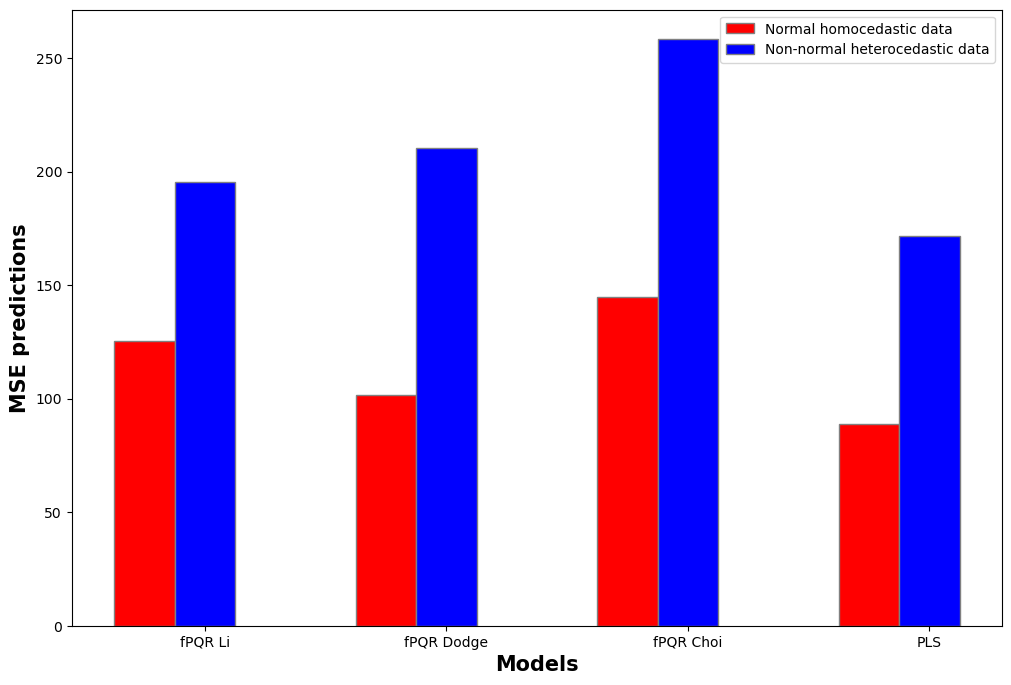

In [117]:
# set width of bar
barWidth = 0.40
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
assumptions = [mse_pred_li, mse_pred_dodge, mse_pred_choi, mse_pred_pls]
no_assumptions = [mse_pred_li_out, mse_pred_dodge_out, mse_pred_choi_out, mse_pred_pls_out]
 
# Set position of bar on X axis
br1 = np.arange(len(assumptions))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, assumptions, color ='r', width = barWidth,
        edgecolor ='grey', label ='Normal homocedastic data')
plt.bar(br2, no_assumptions, color ='b', width = barWidth,
        edgecolor ='grey', label ='Non-normal heterocedastic data')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('MSE predictions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(assumptions))],
        ['fPQR Li', 'fPQR Dodge', 'fPQR Choi', 'PLS'])
 
plt.legend()
plt.show()

## Non-normal heterocedastic residuals' data with non-normal $X$

#### Data with normal homocedastic residuals and normal $X$

In [144]:
sample_size = 100

# Define the covariance matrix
cov_matrix = np.random.uniform(-5, 5, size = (100, 100))
cov_matrix = np.tril(cov_matrix)  # Zero out the upper triangle
cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
if min_eigenvalue <= 0:
    diagonal_addition = np.eye(sample_size) * (-min_eigenvalue + 1e-6)
    cov_matrix += diagonal_addition
    
# Define the mean vector 
mean = np.random.randint(-10, 11, sample_size)

# Simulate X
X = np.random.multivariate_normal(mean, cov_matrix, sample_size)

# Define Y
B_significant = np.random.uniform(0, 1, size = (30, 3))
B_noise = np.zeros((70, 3))
B = np.concatenate((B_significant, B_noise))
E = np.random.normal(0, 1, size=(sample_size, 3))
Y = X@B+E

#### Data with non-normal heterocedastic residuals and gamma $X$

In [145]:
# Simulate X
X_out = np.random.gamma(2, size=(sample_size, sample_size))

# Simulate the chi-sq residuals
E_out = np.zeros((sample_size, 3))
for i in range(E_out.shape[0]): 
    # Generate random values for each element in the row
    E_out[i, :] = np.random.chisquare(random.randint(1, 10), size=3)

# Generate Y
Y_out = X_out@B+E_out

In [146]:
X_train, X_test, X_train_out, X_test_out, Y_train, Y_test, Y_train_out, Y_test_out = train_test_split(X, X_out, Y, Y_out, train_size=0.8, random_state=123)

#### fPQR Li

#### Normal data

In [147]:
start_time_li = time.time()

fpqr_li = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='li')
fpqr_li.fit(X_train, Y_train)

end_time_li = time.time()
execution_time_li = end_time_li - start_time_li

B_estimated_li = fpqr_li.coef_
predictions_li = fpqr_li.predict(X_test)

mse_coef_li = mean_squared_error(B, B_estimated_li)
mse_pred_li = mean_squared_error(Y_test, predictions_li)
qe_pred_li = _quantile_function(Y_test,predictions_li,0.5)

print("Execution time Li:", execution_time_li, "seconds")
print("MSE coef Li:", mse_coef_li)
print("MSE pred Li:", mse_pred_li)
print("Quantile error pred Li:", qe_pred_li)

Execution time Li: 0.2001330852508545 seconds
MSE coef Li: 0.02035608316654998
MSE pred Li: 54.79395309945907
Quantile error pred Li: 2.661829851375908


#### Weird data

In [122]:
start_time_li_out = time.time()

fpqr_li_out = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='li')
fpqr_li_out.fit(X_train_out, Y_train_out)

end_time_li_out = time.time()
execution_time_li_out = end_time_li_out - start_time_li_out

B_estimated_li_out = fpqr_li_out.coef_
predictions_li_out = fpqr_li_out.predict(X_test_out)

mse_coef_li_out = mean_squared_error(B, B_estimated_li_out)
mse_pred_li_out = mean_squared_error(Y_test_out, predictions_li_out)
qe_pred_li_out = _quantile_function(Y_test_out,predictions_li_out,0.5)

print("Execution time Li:", execution_time_li_out, "seconds")
print("MSE coef Li:", mse_coef_li_out)
print("MSE pred Li:", mse_pred_li_out)
print("Quantile error pred Li:", qe_pred_li_out)

Execution time Li: 1.2339956760406494 seconds
MSE coef Li: 5.319078356233671
MSE pred Li: 2092.5585176162494
Quantile error pred Li: 17.976659777446226


#### fPQR Dodge

#### Normal data

In [123]:
start_time_dodge = time.time()

fpqr_dodge = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='dodge')
fpqr_dodge.fit(X_train, Y_train)

end_time_dodge = time.time()
execution_time_dodge = end_time_dodge - start_time_dodge

B_estimated_dodge = fpqr_dodge.coef_
predictions_dodge = fpqr_dodge.predict(X_test)

mse_coef_dodge = mean_squared_error(B, B_estimated_dodge)
mse_pred_dodge = mean_squared_error(Y_test, predictions_dodge)
qe_pred_dodge = _quantile_function(Y_test,predictions_dodge,0.5)

print("Execution time Dodge:", execution_time_dodge, "seconds")
print("MSE coef Dodge:", mse_coef_dodge)
print("MSE pred Dodge:", mse_pred_dodge)
print("Quantile error pred Dodge:", qe_pred_dodge)

Execution time Dodge: 274.03573417663574 seconds
MSE coef Dodge: 0.027877392995683366
MSE pred Dodge: 127.80087047478538
Quantile error pred Dodge: 4.744000814750012


#### Weird data

In [124]:
start_time_dodge_out = time.time()

fpqr_dodge_out = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='dodge')
fpqr_dodge_out.fit(X_train_out, Y_train_out)

end_time_dodge_out = time.time()
execution_time_dodge_out = end_time_dodge_out - start_time_dodge_out

B_estimated_dodge_out = fpqr_dodge_out.coef_
predictions_dodge_out = fpqr_dodge_out.predict(X_test_out)

mse_coef_dodge_out = mean_squared_error(B, B_estimated_dodge_out)
mse_pred_dodge_out = mean_squared_error(Y_test_out, predictions_dodge_out)
qe_pred_dodge_out = _quantile_function(Y_test_out, predictions_dodge_out, 0.5)

print("Execution time Dodge:", execution_time_dodge_out, "seconds")
print("MSE coef Dodge:", mse_coef_dodge_out)
print("MSE pred Dodge:", mse_pred_dodge_out)
print("Quantile error pred Dodge:", qe_pred_dodge_out)

Execution time Dodge: 271.2611954212189 seconds
MSE coef Dodge: 6.001309622552468
MSE pred Dodge: 2264.4478647080323
Quantile error pred Dodge: 18.242927555681497


#### fPQR Choi

#### Normal data

In [125]:
start_time_choi = time.time()

fpqr_choi = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='choi')
fpqr_choi.fit(X_train, Y_train)

end_time_choi = time.time()
execution_time_choi = end_time_choi - start_time_choi

B_estimated_choi = fpqr_choi.coef_
predictions_choi = fpqr_choi.predict(X_test)

mse_coef_choi = mean_squared_error(B, B_estimated_choi)
mse_pred_choi = mean_squared_error(Y_test, predictions_choi)
qe_pred_choi = _quantile_function(Y_test, predictions_choi, 0.5)

print("Execution time Choi:", execution_time_choi, "seconds")
print("MSE coef Choi:", mse_coef_li)
print("MSE pred Choi:", mse_pred_li)
print("Quantile error pred Choi:", qe_pred_li)

Execution time Choi: 529.4616401195526 seconds
MSE coef Choi: 0.026484370858554807
MSE pred Choi: 151.2576799370786
Quantile error pred Choi: 5.116324772512731


#### Weird data

In [126]:
start_time_choi_out = time.time()

fpqr_choi_out = fpqr.FPQRegression(quantile=0.5, n_components=30, metric='choi')
fpqr_choi_out.fit(X_train_out, Y_train_out)

end_time_choi_out = time.time()
execution_time_choi_out = end_time_choi_out - start_time_choi_out

B_estimated_choi_out = fpqr_choi_out.coef_
predictions_choi_out = fpqr_choi_out.predict(X_test_out)

mse_coef_choi_out = mean_squared_error(B, B_estimated_choi_out)
mse_pred_choi_out = mean_squared_error(Y_test_out, predictions_choi_out)
qe_pred_choi_out = _quantile_function(Y_test_out, predictions_choi_out, 0.5)

print("Execution time Choi:", execution_time_choi_out, "seconds")
print("MSE coef Choi:", mse_coef_choi_out)
print("MSE pred Choi:", mse_pred_choi_out)
print("Quantile error pred Choi:", qe_pred_choi_out)

Execution time Choi: 520.027195930481 seconds
MSE coef Choi: 9.77089940076424
MSE pred Choi: 3433.173008309877
Quantile error pred Choi: 22.413542044915612


#### PLS

#### Normal data

In [148]:
start_time_pls = time.time()

pls_model = PLSRegression(n_components=30)  # By using PLS we regress to the mean
pls_model.fit(X_train, Y_train)

end_time_pls = time.time()
execution_time_pls = end_time_pls - start_time_pls

B_estimated_pls = pls_model.coef_
predictions_pls = pls_model.predict(X_test)

mse_coef_pls = mean_squared_error(B, B_estimated_pls)
mse_pred_pls = mean_squared_error(Y_test, predictions_pls)
qe_pred_pls = _quantile_function(Y_test, predictions_pls, 0.5)

print("Execution time PLS:", execution_time_pls, "seconds")
print("MSE coef PLS:", mse_coef_pls)
print("MSE pred PLS:", mse_pred_pls)
print("Quantile error pred PLS:", qe_pred_pls)

Execution time PLS: 0.030060529708862305 seconds
MSE coef PLS: 2.6467214900987366
MSE pred PLS: 41.70278058141753
Quantile error pred PLS: 2.51952871689755


C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


#### Weird data

In [149]:
start_time_pls_out = time.time()

pls_model_out = PLSRegression(n_components=30)  # By using PLS we regress to the mean
pls_model_out.fit(X_train_out, Y_train_out)

end_time_pls_out = time.time()
execution_time_pls_out = end_time_pls_out - start_time_pls_out

B_estimated_pls_out = pls_model_out.coef_
predictions_pls_out = pls_model_out.predict(X_test_out)

mse_coef_pls_out = mean_squared_error(B, B_estimated_pls_out)
mse_pred_pls_out = mean_squared_error(Y_test_out, predictions_pls_out) # Here we compare with Y_test_out
qe_pred_pls_out = _quantile_function(Y_test_out, predictions_pls_out, 0.5)

print("Execution time PLS:", execution_time_pls_out, "seconds")
print("MSE coef PLS:", mse_coef_pls_out)
print("MSE pred PLS:", mse_pred_pls_out)
print("Quantile error pred PLS:", qe_pred_pls_out)

Execution time PLS: 0.043226003646850586 seconds
MSE coef PLS: 0.6787121570454816
MSE pred PLS: 76.75613695177532
Quantile error pred PLS: 3.529709000472556


C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


### Bar plot

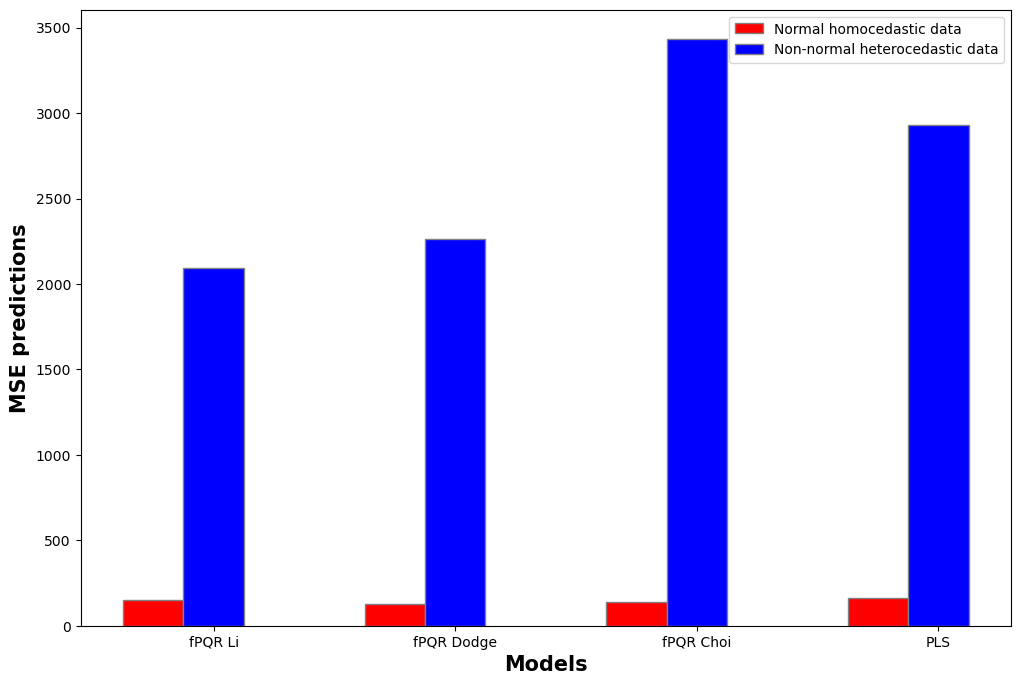

In [129]:
# set width of bar
barWidth = 0.40
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
assumptions = [mse_pred_li, mse_pred_dodge, mse_pred_choi, mse_pred_pls]
no_assumptions = [mse_pred_li_out, mse_pred_dodge_out, mse_pred_choi_out, mse_pred_pls_out]
 
# Set position of bar on X axis
br1 = np.arange(len(assumptions))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, assumptions, color ='r', width = barWidth,
        edgecolor ='grey', label ='Normal homocedastic data')
plt.bar(br2, no_assumptions, color ='b', width = barWidth,
        edgecolor ='grey', label ='Non-normal heterocedastic data')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('MSE predictions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(assumptions))],
        ['fPQR Li', 'fPQR Dodge', 'fPQR Choi', 'PLS'])
 
plt.legend()
plt.show()

## Looped simplified version of simulations to avoid noise (only Li and PLS for time)

### Simulating outliers

The train and test sets are defined randomly but separately from the same distribution, son the split is made explicit and not implicit from a global dataset. It is the same result from a sample point of view, but in this way we control that a 5% of outliers are always included in the training and testing set and they are not shuffled randmoly. We want control over this to ensure we are not simply adding noise. Also, to gain more controla and avoid a noisy scenario, the covariance matrix for $X$ is $\Sigma =Id_p$ and the mean is $0_p$. Most changes are done in the mean, though changing the variance of the residuals is reallly significant.

Letting the position of the outliers to be different variables in the training and testing sets and to be defined anew in every iteration. Also, testiong and predictiong with the non-outliers dataset eventhough the training is done in both. The number of significant independent variables set to 30 yields the same good structure of results but better accuracy.

In [19]:
# %%capture # This makes the cell not to display any output, in particular the warnings of pls

number_iterations = 30
sample_size = 100
number_of_ind_variables = 100
number_of_dep_variables = 3
number_of_significant_ind_variables = 30
number_of_components = number_of_significant_ind_variables
chi_sq_dg = 3
scale_parameter = 1
tau = 0.5
tau_eq = tau

li_coef_mse_i, li_pred_mse_i, li_pred_eq_i, li_time_i = [], [], [], []
li_coef_mse_i_out, li_pred_mse_i_out, li_pred_eq_i_out, li_time_i_out = [], [], [], []

dodge_coef_mse_i, dodge_pred_mse_i, dodge_pred_eq_i, dodge_time_i = [], [], [], []
dodge_coef_mse_i_out, dodge_pred_mse_i_out, dodge_pred_eq_i_out, dodge_time_i_out = [], [], [], []

choi_coef_mse_i, choi_pred_mse_i, choi_pred_eq_i, choi_time_i = [], [], [], []
choi_coef_mse_i_out, choi_pred_mse_i_out, choi_pred_eq_i_out, choi_time_i_out = [], [], [], []

pls_coef_mse_i, pls_pred_mse_i, pls_pred_eq_i, pls_time_i =[], [], [], []
pls_coef_mse_i_out, pls_pred_mse_i_out, pls_pred_eq_i_out, pls_time_i_out =[], [], [], []

# Create covariance matrix
#cov_matrix = np.random.uniform(-5, 5, size = (number_of_ind_variables, number_of_ind_variables))
#cov_matrix = np.tril(cov_matrix)  # Zero out the upper triangle
#cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
#min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
#if min_eigenvalue <= 0:
#    diagonal_addition = np.eye(number_of_ind_variables) * (-min_eigenvalue + 1e-6)
#    cov_matrix += diagonal_addition

# Create alternative covariance matrix
#cov_matrix_alternative = np.random.uniform(-20, 20, size = (number_of_ind_variables, number_of_ind_variables))
#cov_matrix_alternative = np.tril(cov_matrix)  # Zero out the upper triangle
#cov_matrix_alternative = cov_matrix_alternative + cov_matrix_alternative.T - np.diag(cov_matrix_alternative.diagonal())
#min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix_alternative))
#if min_eigenvalue <= 0:
#    diagonal_addition = np.eye(number_of_ind_variables) * (-min_eigenvalue + 1e-6)
#    cov_matrix_alternative += diagonal_addition


for i in range(number_iterations):
    
    # Generate train data for iteration
    # Create covariance matrix
    
    # Define the mean vector
    mean = np.zeros(number_of_ind_variables)
    # Sample data
    X_train = np.random.multivariate_normal(mean, np.identity(number_of_ind_variables), sample_size)
    B_train_significant = np.random.uniform(0, 1, size = (number_of_significant_ind_variables, number_of_dep_variables))
    B_train_noise = np.zeros((number_of_ind_variables - number_of_significant_ind_variables, number_of_dep_variables))
    B_train = np.concatenate((B_train_significant, B_train_noise))
    E_train = np.random.normal(0, 1, size=(sample_size, number_of_dep_variables))
    Y_train = X_train@B_train+E_train
    
    # Generate alterative distribution
    # Define alternative mean vector
    mean_alternative = np.full(number_of_ind_variables, 90)
    # Sample alternative data
    X_train_alternative = np.random.multivariate_normal(mean_alternative, np.identity(number_of_ind_variables), sample_size)
    E_train_alternative = np.random.normal(6, 15, size=(sample_size, number_of_dep_variables))
    
    # Include outliers in the original distribution from the alternative one
    outliers_entries_train = np.random.choice(np.arange(0, len(X_train)), size=int(0.05*len(X_train)), replace=False) # 5% of outliers
    X_train_out = X_train.copy()
    X_train_out[outliers_entries_train,:] = X_train_alternative[outliers_entries_train,:]
    E_train_out = E_train.copy()
    E_train_out[outliers_entries_train,:] = E_train_alternative[outliers_entries_train,:]
    Y_train_out = X_train_out@B_train + E_train_out
    
    #Test data
    X_test = np.random.multivariate_normal(mean, np.identity(number_of_ind_variables), sample_size)
    B_test_significant = np.random.uniform(0, 1, size = (number_of_significant_ind_variables, number_of_dep_variables))
    B_test_noise = np.zeros((number_of_ind_variables - number_of_significant_ind_variables, number_of_dep_variables))
    B_test = np.concatenate((B_test_significant, B_test_noise))
    E_test = np.random.normal(0, 1, size=(sample_size, number_of_dep_variables))
    Y_test = X_test@B_test+E_test
    
    # Define alternative mean vector
    mean_alternative = np.full(number_of_ind_variables, 90)
    # Sample alternative data
    X_test_alternative = np.random.multivariate_normal(mean_alternative, np.identity(number_of_ind_variables), sample_size)
    E_test_alternative = np.random.normal(6, 15, size=(sample_size, number_of_dep_variables))
    
    # Include outliers in the original distribution from the alternative one
    outliers_entries_test = np.random.choice(np.arange(0, len(X_test)), size=int(0.05*len(X_test)), replace=False) # 5% of outliers
    X_test_out = X_test.copy()
    X_test_out[outliers_entries_test,:] = X_test_alternative[outliers_entries_test,:]
    E_test_out = E_test.copy()
    E_test_out[outliers_entries_test,:] = E_test_alternative[outliers_entries_test,:]
    Y_test_out = X_test_out@B_test + E_test_out

    
    # Li without outliers
    start_time_li = time.time()
    fpqr_li = fpqr.FPQRegression(quantile=tau, n_components=30, metric='li')
    fpqr_li.fit(X_train, Y_train)
    end_time_li = time.time()
    execution_time_li = end_time_li - start_time_li
    B_estimated_li = fpqr_li.coef_
    predictions_li = fpqr_li.predict(X_test)
    
    li_time_i.append(execution_time_li)
    li_coef_mse_i.append(mean_squared_error(B_test, B_estimated_li))
    li_pred_mse_i.append(mean_squared_error(Y_test, predictions_li))
    li_pred_eq_i.append(_quantile_function(Y_test,predictions_li, tau_eq))
    
    # Li with outliers
    start_time_li_out = time.time()
    fpqr_li_out = fpqr.FPQRegression(quantile=tau, n_components=30, metric='li')
    fpqr_li_out.fit(X_train_out, Y_train_out)
    end_time_li_out = time.time()
    execution_time_li_out = end_time_li_out - start_time_li_out
    B_estimated_li_out = fpqr_li_out.coef_
    predictions_li_out = fpqr_li_out.predict(X_test)
    
    li_time_i_out.append(execution_time_li_out)
    li_coef_mse_i_out.append(mean_squared_error(B_test, B_estimated_li_out))
    li_pred_mse_i_out.append(mean_squared_error(Y_test, predictions_li_out))
    li_pred_eq_i_out.append(_quantile_function(Y_test,predictions_li_out, tau_eq))
    
    # PLS without outliers
    start_time_pls = time.time()
    pls_model = PLSRegression(n_components=30)  # By using PLS we regress to the mean
    pls_model.fit(X_train, Y_train)
    end_time_pls = time.time()
    execution_time_pls = end_time_pls - start_time_pls
    B_estimated_pls = pls_model.coef_ 
    predictions_pls = pls_model.predict(X_test)
    
    pls_time_i.append(execution_time_pls)
    pls_coef_mse_i.append(mean_squared_error(B_test, B_estimated_pls))
    pls_pred_mse_i.append(mean_squared_error(Y_test, predictions_pls))
    pls_pred_eq_i.append(_quantile_function(Y_test, predictions_pls, tau_eq))
    
    # PLS with outliers
    start_time_pls_out = time.time()
    pls_model_out = PLSRegression(n_components=30)  # By using PLS we regress to the mean
    pls_model_out.fit(X_train_out, Y_train_out)
    end_time_pls_out = time.time()
    execution_time_pls_out = end_time_pls_out - start_time_pls_out
    B_estimated_pls_out = pls_model_out.coef_ 
    predictions_pls_out = pls_model_out.predict(X_test)
    
    pls_time_i_out.append(execution_time_pls_out)
    pls_coef_mse_i_out.append(mean_squared_error(B_test, B_estimated_pls_out))
    pls_pred_mse_i_out.append(mean_squared_error(Y_test, predictions_pls_out))
    pls_pred_eq_i_out.append(_quantile_function(Y_test, predictions_pls_out, tau_eq))

li_coef_mse, li_pred_mse, li_pred_eq, li_time = np.mean(li_coef_mse_i), np.mean(li_pred_mse_i), np.mean(li_pred_eq_i), np.mean(li_time_i)
li_coef_mse_out, li_pred_mse_out, li_pred_eq_out, li_time_out = np.mean(li_coef_mse_i_out), np.mean(li_pred_mse_i_out), np.mean(li_pred_eq_i_out), np.mean(li_time_i_out)

pls_coef_mse, pls_pred_mse, pls_pred_eq, pls_time = np.mean(pls_coef_mse_i), np.mean(pls_pred_mse_i), np.mean(pls_pred_eq_i), np.mean(pls_time_i)
pls_coef_mse_out, pls_pred_mse_out, pls_pred_eq_out, pls_time_out = np.mean(pls_coef_mse_i_out), np.mean(pls_pred_mse_i_out), np.mean(pls_pred_eq_i_out), np.mean(pls_time_i_out)

C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

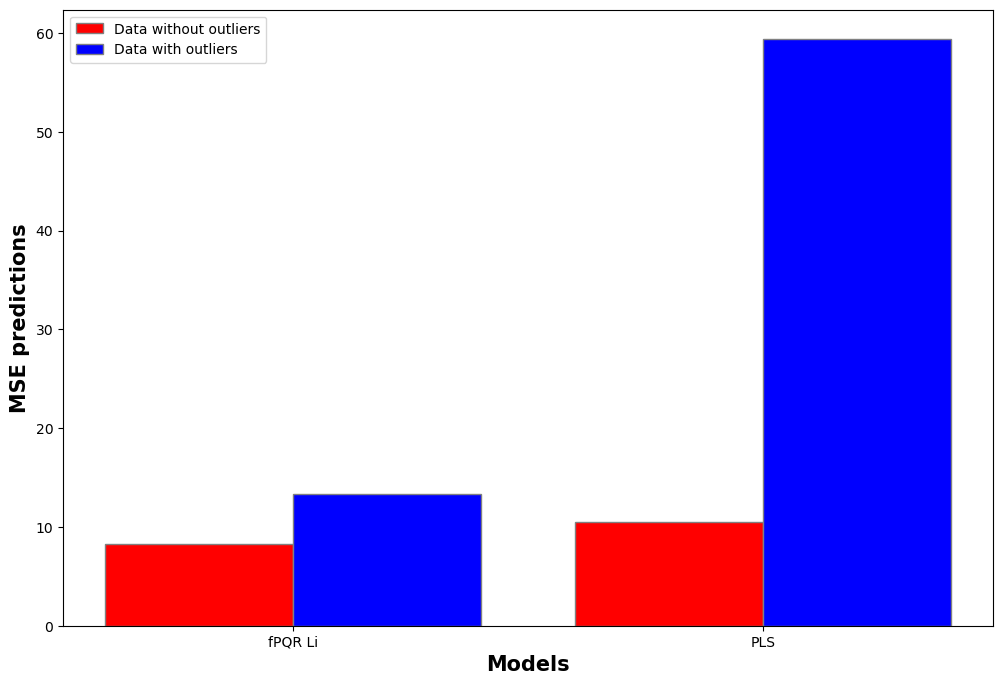

In [20]:
# set width of bar
barWidth = 0.40
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
assumptions = [li_pred_mse, pls_pred_mse]
no_assumptions = [li_pred_mse_out, pls_pred_mse_out]
 
# Set position of bar on X axis
br1 = np.arange(len(assumptions))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, assumptions, color ='r', width = barWidth,
        edgecolor ='grey', label ='Data without outliers')
plt.bar(br2, no_assumptions, color ='b', width = barWidth,
        edgecolor ='grey', label ='Data with outliers')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('MSE predictions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(assumptions))],
        ['fPQR Li', 'PLS'])
 
plt.legend()
plt.show()

Letting the position of the outliers to be different variables in the training and testing sets but fixed before the loop. Also, testing and predictiong with the non-outliers dataset eventhough the training is done in both. Also include only 30 significant variables. Changing $E_{alt}\sim N(6,10)$ to $E_{alt}\sim N(6,15)$ increases the error in the blue PLS from 30 to 70 but the one of fPQR remains in 10. In the previous plot it increases it up to 60 but fPQR remains still. Changing the mean, for instance to 8 doesn't seem to change the results significantly.

In [855]:
# %%capture # This makes the cell not to display any output, in particular the warnings of pls

number_iterations = 30
sample_size = 100
number_of_ind_variables = 100
number_of_dep_variables = 3
number_of_significant_ind_variables = 30
number_of_components = number_of_significant_ind_variables
chi_sq_dg = 3
scale_parameter = 1
tau = 0.5
tau_eq = tau

li_coef_mse_i, li_pred_mse_i, li_pred_eq_i, li_time_i = [], [], [], []
li_coef_mse_i_out, li_pred_mse_i_out, li_pred_eq_i_out, li_time_i_out = [], [], [], []

dodge_coef_mse_i, dodge_pred_mse_i, dodge_pred_eq_i, dodge_time_i = [], [], [], []
dodge_coef_mse_i_out, dodge_pred_mse_i_out, dodge_pred_eq_i_out, dodge_time_i_out = [], [], [], []

choi_coef_mse_i, choi_pred_mse_i, choi_pred_eq_i, choi_time_i = [], [], [], []
choi_coef_mse_i_out, choi_pred_mse_i_out, choi_pred_eq_i_out, choi_time_i_out = [], [], [], []

pls_coef_mse_i, pls_pred_mse_i, pls_pred_eq_i, pls_time_i =[], [], [], []
pls_coef_mse_i_out, pls_pred_mse_i_out, pls_pred_eq_i_out, pls_time_i_out =[], [], [], []

#cov_matrix = np.random.uniform(-5, 5, size = (number_of_ind_variables, number_of_ind_variables))
#cov_matrix = np.tril(cov_matrix)  # Zero out the upper triangle
#cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
#min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
#if min_eigenvalue <= 0:
#    diagonal_addition = np.eye(number_of_ind_variables) * (-min_eigenvalue + 1e-6)
#    cov_matrix += diagonal_addition

# Create alternative covariance matrix
#cov_matrix_alternative = np.random.uniform(-20, 20, size = (number_of_ind_variables, number_of_ind_variables))
#cov_matrix_alternative = np.tril(cov_matrix)  # Zero out the upper triangle
#cov_matrix_alternative = cov_matrix_alternative + cov_matrix_alternative.T - np.diag(cov_matrix_alternative.diagonal())
#min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix_alternative))
#if min_eigenvalue <= 0:
#    diagonal_addition = np.eye(number_of_ind_variables) * (-min_eigenvalue + 1e-6)
#    cov_matrix_alternative += diagonal_addition

outliers_entries_train = np.random.choice(np.arange(0, sample_size), size=int(0.05*sample_size), replace=False) # 5% of outliers
outliers_entries_test = np.random.choice(np.arange(0, sample_size), size=int(0.05*sample_size), replace=False) # 5% of outliers

for i in range(number_iterations):
    
    # Generate train data for iteration
    # Create covariance matrix
    
    # Define the mean vector
    mean = np.zeros(number_of_ind_variables)
    # Sample data
    X_train = np.random.multivariate_normal(mean, np.identity(number_of_ind_variables), sample_size)
    B_train_significant = np.random.uniform(0, 1, size = (number_of_significant_ind_variables, number_of_dep_variables))
    B_train_noise = np.zeros((number_of_ind_variables - number_of_significant_ind_variables, number_of_dep_variables))
    B_train = np.concatenate((B_train_significant, B_train_noise))
    E_train = np.random.normal(0, 1, size=(sample_size, number_of_dep_variables))
    Y_train = X_train@B_train+E_train
    
    # Generate alterative distribution
    # Define alternative mean vector
    mean_alternative = np.full(number_of_ind_variables, 90)
    # Sample alternative data
    X_train_alternative = np.random.multivariate_normal(mean_alternative, np.identity(number_of_ind_variables), sample_size)
    E_train_alternative = np.random.normal(6, 15, size=(sample_size, number_of_dep_variables))
    
    # Include outliers in the original distribution from the alternative one
    X_train_out = X_train.copy()
    X_train_out[outliers_entries_train,:] = X_train_alternative[outliers_entries_train,:]
    E_train_out = E_train.copy()
    E_train_out[outliers_entries_train,:] = E_train_alternative[outliers_entries_train,:]
    Y_train_out = X_train_out@B_train + E_train_out
    
    #Test data
    X_test = np.random.multivariate_normal(mean, np.identity(number_of_ind_variables), sample_size)
    B_test_significant = np.random.uniform(0, 1, size = (number_of_significant_ind_variables, number_of_dep_variables))
    B_test_noise = np.zeros((number_of_ind_variables - number_of_significant_ind_variables, number_of_dep_variables))
    B_test = np.concatenate((B_test_significant, B_test_noise))
    E_test = np.random.normal(0, 1, size=(sample_size, number_of_dep_variables))
    Y_test = X_test@B_test+E_test
    
    # Generate alterative distribution
    # Define alternative mean vector
    mean_alternative = np.full(number_of_ind_variables, 90)
    # Sample alternative data
    X_test_alternative = np.random.multivariate_normal(mean_alternative, np.identity(number_of_ind_variables), sample_size)
    E_test_alternative = np.random.normal(6, 15, size=(sample_size, number_of_dep_variables))
    
    # Include outliers in the original distribution from the alternative one
    X_test_out = X_test.copy()
    X_test_out[outliers_entries_test,:] = X_test_alternative[outliers_entries_test,:]
    E_test_out = E_test.copy()
    E_test_out[outliers_entries_test,:] = E_train_alternative[outliers_entries_test,:]
    Y_test_out = X_test_out@B_test + E_test_out

    
    # Li without outliers
    start_time_li = time.time()
    fpqr_li = fpqr.FPQRegression(quantile=tau, n_components=30, metric='li')
    fpqr_li.fit(X_train, Y_train)
    end_time_li = time.time()
    execution_time_li = end_time_li - start_time_li
    B_estimated_li = fpqr_li.coef_
    predictions_li = fpqr_li.predict(X_test)
    
    li_time_i.append(execution_time_li)
    li_coef_mse_i.append(mean_squared_error(B_test, B_estimated_li))
    li_pred_mse_i.append(mean_squared_error(Y_test, predictions_li))
    li_pred_eq_i.append(_quantile_function(Y_test,predictions_li, tau_eq))
    
    # Li with outliers
    start_time_li_out = time.time()
    fpqr_li_out = fpqr.FPQRegression(quantile=tau, n_components=30, metric='li')
    fpqr_li_out.fit(X_train_out, Y_train_out)
    end_time_li_out = time.time()
    execution_time_li_out = end_time_li_out - start_time_li_out
    B_estimated_li_out = fpqr_li_out.coef_
    predictions_li_out = fpqr_li_out.predict(X_test)
    
    li_time_i_out.append(execution_time_li_out)
    li_coef_mse_i_out.append(mean_squared_error(B_test, B_estimated_li_out))
    li_pred_mse_i_out.append(mean_squared_error(Y_test, predictions_li_out))
    li_pred_eq_i_out.append(_quantile_function(Y_test,predictions_li_out, tau_eq))
    
    # PLS without outliers
    start_time_pls = time.time()
    pls_model = PLSRegression(n_components=30)  # By using PLS we regress to the mean
    pls_model.fit(X_train, Y_train)
    end_time_pls = time.time()
    execution_time_pls = end_time_pls - start_time_pls
    B_estimated_pls = pls_model.coef_ 
    predictions_pls = pls_model.predict(X_test)
    
    pls_time_i.append(execution_time_pls)
    pls_coef_mse_i.append(mean_squared_error(B_test, B_estimated_pls))
    pls_pred_mse_i.append(mean_squared_error(Y_test, predictions_pls))
    pls_pred_eq_i.append(_quantile_function(Y_test, predictions_pls, tau_eq))
    
    # PLS with outliers
    start_time_pls_out = time.time()
    pls_model_out = PLSRegression(n_components=30)  # By using PLS we regress to the mean
    pls_model_out.fit(X_train_out, Y_train_out)
    end_time_pls_out = time.time()
    execution_time_pls_out = end_time_pls_out - start_time_pls_out
    B_estimated_pls_out = pls_model_out.coef_ 
    predictions_pls_out = pls_model_out.predict(X_test)
    
    pls_time_i_out.append(execution_time_pls_out)
    pls_coef_mse_i_out.append(mean_squared_error(B_test, B_estimated_pls_out))
    pls_pred_mse_i_out.append(mean_squared_error(Y_test, predictions_pls_out))
    pls_pred_eq_i_out.append(_quantile_function(Y_test, predictions_pls_out, tau_eq))

li_coef_mse, li_pred_mse, li_pred_eq, li_time = np.mean(li_coef_mse_i), np.mean(li_pred_mse_i), np.mean(li_pred_eq_i), np.mean(li_time_i)
li_coef_mse_out, li_pred_mse_out, li_pred_eq_out, li_time_out = np.mean(li_coef_mse_i_out), np.mean(li_pred_mse_i_out), np.mean(li_pred_eq_i_out), np.mean(li_time_i_out)

pls_coef_mse, pls_pred_mse, pls_pred_eq, pls_time = np.mean(pls_coef_mse_i), np.mean(pls_pred_mse_i), np.mean(pls_pred_eq_i), np.mean(pls_time_i)
pls_coef_mse_out, pls_pred_mse_out, pls_pred_eq_out, pls_time_out = np.mean(pls_coef_mse_i_out), np.mean(pls_pred_mse_i_out), np.mean(pls_pred_eq_i_out), np.mean(pls_time_i_out)

C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

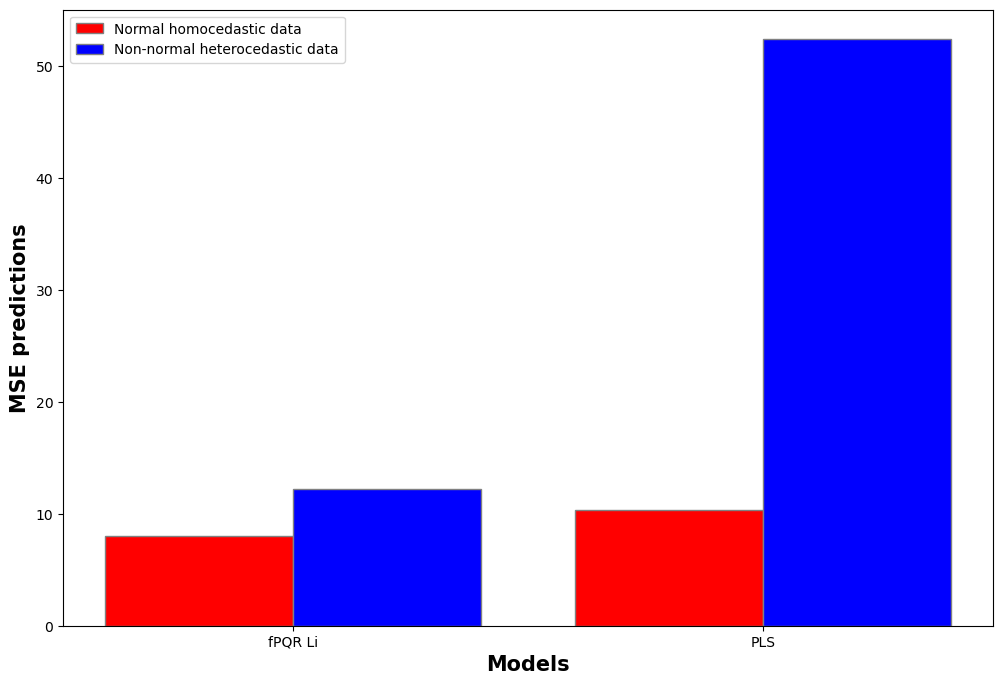

In [856]:
# set width of bar
barWidth = 0.40
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
assumptions = [li_pred_mse, pls_pred_mse]
no_assumptions = [li_pred_mse_out, pls_pred_mse_out]
 
# Set position of bar on X axis
br1 = np.arange(len(assumptions))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, assumptions, color ='r', width = barWidth,
        edgecolor ='grey', label ='Data without outliers')
plt.bar(br2, no_assumptions, color ='b', width = barWidth,
        edgecolor ='grey', label ='Data with outliers')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('MSE predictions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(assumptions))],
        ['fPQR Li', 'PLS'])
 
plt.legend()
plt.show()

### Simulating non assumed distributions

We change the simulation of the residuals, changing the $N(0,1)$ for a $\chi^2(p)$, where $p$ is a random integer from 0 to 10 for each row, thus achieving heterocedasticity. Additionaly, some of the rows can be changed for $Exp(p)$, where $p$ is a random integer from 0 to 10. This lst section can be commented for more simplicity. In this case, the models are trained and tested on the normal homocedastic distribution and trained and tested on the non-normal heterocedastic distribution. This makes perfect sense because we wnat to see how models perform under unconventional distributions. In the outliers case we wanted to test if ocasional outliers perturbed significantly the parameters estimation, making predictions on the expected conventional samples explode.

In [43]:
# %%capture # This makes the cell not to display any output, in particular the warnings of pls

number_iterations = 30
sample_size = 100
number_of_ind_variables = 100
number_of_dep_variables = 3
number_of_significant_ind_variables = 30
number_of_components = number_of_significant_ind_variables
chi_sq_dg = 3
scale_parameter = 1
tau = 0.5
tau_eq = tau

li_coef_mse_i, li_pred_mse_i, li_pred_eq_i, li_time_i = [], [], [], []
li_coef_mse_i_out, li_pred_mse_i_out, li_pred_eq_i_out, li_time_i_out = [], [], [], []

dodge_coef_mse_i, dodge_pred_mse_i, dodge_pred_eq_i, dodge_time_i = [], [], [], []
dodge_coef_mse_i_out, dodge_pred_mse_i_out, dodge_pred_eq_i_out, dodge_time_i_out = [], [], [], []

choi_coef_mse_i, choi_pred_mse_i, choi_pred_eq_i, choi_time_i = [], [], [], []
choi_coef_mse_i_out, choi_pred_mse_i_out, choi_pred_eq_i_out, choi_time_i_out = [], [], [], []

pls_coef_mse_i, pls_pred_mse_i, pls_pred_eq_i, pls_time_i =[], [], [], []
pls_coef_mse_i_out, pls_pred_mse_i_out, pls_pred_eq_i_out, pls_time_i_out =[], [], [], []

#cov_matrix = np.random.uniform(-5, 5, size = (number_of_ind_variables, number_of_ind_variables))
#cov_matrix = np.tril(cov_matrix)  # Zero out the upper triangle
#cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
#min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
#if min_eigenvalue <= 0:
#    diagonal_addition = np.eye(number_of_ind_variables) * (-min_eigenvalue + 1e-6)
#    cov_matrix += diagonal_addition

# Create alternative covariance matrix
#cov_matrix_alternative = np.random.uniform(-20, 20, size = (number_of_ind_variables, number_of_ind_variables))
#cov_matrix_alternative = np.tril(cov_matrix)  # Zero out the upper triangle
#cov_matrix_alternative = cov_matrix_alternative + cov_matrix_alternative.T - np.diag(cov_matrix_alternative.diagonal())
#min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix_alternative))
#if min_eigenvalue <= 0:
#    diagonal_addition = np.eye(number_of_ind_variables) * (-min_eigenvalue + 1e-6)
#    cov_matrix_alternative += diagonal_addition

for i in range(number_iterations):
    
    # Generate train data for iteration
    # Define the mean vector
    mean = np.zeros(number_of_ind_variables)
    # Sample data
    X_train = np.random.multivariate_normal(mean, np.identity(number_of_ind_variables), sample_size)
    B_train_significant = np.random.uniform(0, 1, size = (number_of_significant_ind_variables, number_of_dep_variables))
    B_train_noise = np.zeros((number_of_ind_variables - number_of_significant_ind_variables, number_of_dep_variables))
    B_train = np.concatenate((B_train_significant, B_train_noise))
    E_train = np.random.normal(0, 1, size=(sample_size, number_of_dep_variables))
    Y_train = X_train@B_train+E_train
    
    # Generate alterative train distribution
    E_train_alt = np.zeros((sample_size, 3))
    for i in range(E_train_alt.shape[0]): 
        # Generate random values for each row
        E_train_alt[i, :] = np.random.chisquare(random.randint(1, 10), size=3)
        
    F_train = np.zeros((sample_size, 3))
    for i in range(F_train.shape[0]): 
        # Generate random values for each row
        F_train[i, :] = np.random.exponential(random.randint(1, 10), size=3)
    entries_train = np.random.choice(np.arange(0, len(E_train)), size=int(0.1*len(E_train)), replace=False)
    E_train_alternative = E_train_alt.copy()
    E_train_alternative[entries_train,:] = F_train[entries_train,:]
    
    Y_train_alt = X_train@B_train+E_train_alternative
    
    #Test data
    X_test = np.random.multivariate_normal(mean, np.identity(number_of_ind_variables), sample_size)
    B_test_significant = np.random.uniform(0, 1, size = (number_of_significant_ind_variables, number_of_dep_variables))
    B_test_noise = np.zeros((number_of_ind_variables - number_of_significant_ind_variables, number_of_dep_variables))
    B_test = np.concatenate((B_test_significant, B_test_noise))
    E_test = np.random.normal(0, 1, size=(sample_size, number_of_dep_variables))
    Y_test = X_test@B_test+E_test
    
    # Generate alterative test distribution
    E_test_alt = np.zeros((sample_size, 3))
    for i in range(E_test_alt.shape[0]): 
        # Generate random values for each row
        E_test_alt[i, :] = np.random.chisquare(random.randint(1, 10), size=3)
        
    F_test = np.zeros((sample_size, 3))
    for i in range(F_test.shape[0]): 
        # Generate random values for each row
        F_test[i, :] = np.random.exponential(random.randint(1, 10), size=3)
    entries_test = np.random.choice(np.arange(0, len(E_test)), size=int(0.1*len(E_test)), replace=False)
    E_test_alternative = E_test_alt.copy()
    E_test_alternative[entries_test,:] = F_test[entries_test,:]
 
    Y_test_alt = X_test@B_test+E_test_alternative

    
    # Li without outliers
    start_time_li = time.time()
    fpqr_li = fpqr.FPQRegression(quantile=tau, n_components=30, metric='li')
    fpqr_li.fit(X_train, Y_train)
    end_time_li = time.time()
    execution_time_li = end_time_li - start_time_li
    B_estimated_li = fpqr_li.coef_
    predictions_li = fpqr_li.predict(X_test)
    
    li_time_i.append(execution_time_li)
    li_coef_mse_i.append(mean_squared_error(B_test, B_estimated_li))
    li_pred_mse_i.append(mean_squared_error(Y_test, predictions_li))
    li_pred_eq_i.append(_quantile_function(Y_test,predictions_li, tau_eq))
    
    # Li with outliers
    start_time_li_out = time.time()
    fpqr_li_out = fpqr.FPQRegression(quantile=tau, n_components=30, metric='li')
    fpqr_li_out.fit(X_train_out, Y_train_out)
    end_time_li_out = time.time()
    execution_time_li_out = end_time_li_out - start_time_li_out
    B_estimated_li_out = fpqr_li_out.coef_
    predictions_li_out = fpqr_li_out.predict(X_test)
    
    li_time_i_out.append(execution_time_li_out)
    li_coef_mse_i_out.append(mean_squared_error(B_test, B_estimated_li_out))
    li_pred_mse_i_out.append(mean_squared_error(Y_test_alt, predictions_li_out))
    li_pred_eq_i_out.append(_quantile_function(Y_test_alt,predictions_li_out, tau_eq))
    
    # PLS without outliers
    start_time_pls = time.time()
    pls_model = PLSRegression(n_components=30)  # By using PLS we regress to the mean
    pls_model.fit(X_train, Y_train)
    end_time_pls = time.time()
    execution_time_pls = end_time_pls - start_time_pls
    B_estimated_pls = pls_model.coef_ 
    predictions_pls = pls_model.predict(X_test)
    
    pls_time_i.append(execution_time_pls)
    pls_coef_mse_i.append(mean_squared_error(B_test, B_estimated_pls))
    pls_pred_mse_i.append(mean_squared_error(Y_test, predictions_pls))
    pls_pred_eq_i.append(_quantile_function(Y_test, predictions_pls, tau_eq))
    
    # PLS with outliers
    start_time_pls_out = time.time()
    pls_model_out = PLSRegression(n_components=30)  # By using PLS we regress to the mean
    pls_model_out.fit(X_train_out, Y_train_out)
    end_time_pls_out = time.time()
    execution_time_pls_out = end_time_pls_out - start_time_pls_out
    B_estimated_pls_out = pls_model_out.coef_ 
    predictions_pls_out = pls_model_out.predict(X_test)
    
    pls_time_i_out.append(execution_time_pls_out)
    pls_coef_mse_i_out.append(mean_squared_error(B_test, B_estimated_pls_out))
    pls_pred_mse_i_out.append(mean_squared_error(Y_test_alt, predictions_pls_out))
    pls_pred_eq_i_out.append(_quantile_function(Y_test_alt, predictions_pls_out, tau_eq))

li_coef_mse, li_pred_mse, li_pred_eq, li_time = np.mean(li_coef_mse_i), np.mean(li_pred_mse_i), np.mean(li_pred_eq_i), np.mean(li_time_i)
li_coef_mse_out, li_pred_mse_out, li_pred_eq_out, li_time_out = np.mean(li_coef_mse_i_out), np.mean(li_pred_mse_i_out), np.mean(li_pred_eq_i_out), np.mean(li_time_i_out)

pls_coef_mse, pls_pred_mse, pls_pred_eq, pls_time = np.mean(pls_coef_mse_i), np.mean(pls_pred_mse_i), np.mean(pls_pred_eq_i), np.mean(pls_time_i)
pls_coef_mse_out, pls_pred_mse_out, pls_pred_eq_out, pls_time_out = np.mean(pls_coef_mse_i_out), np.mean(pls_pred_mse_i_out), np.mean(pls_pred_eq_i_out), np.mean(pls_time_i_out)

C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

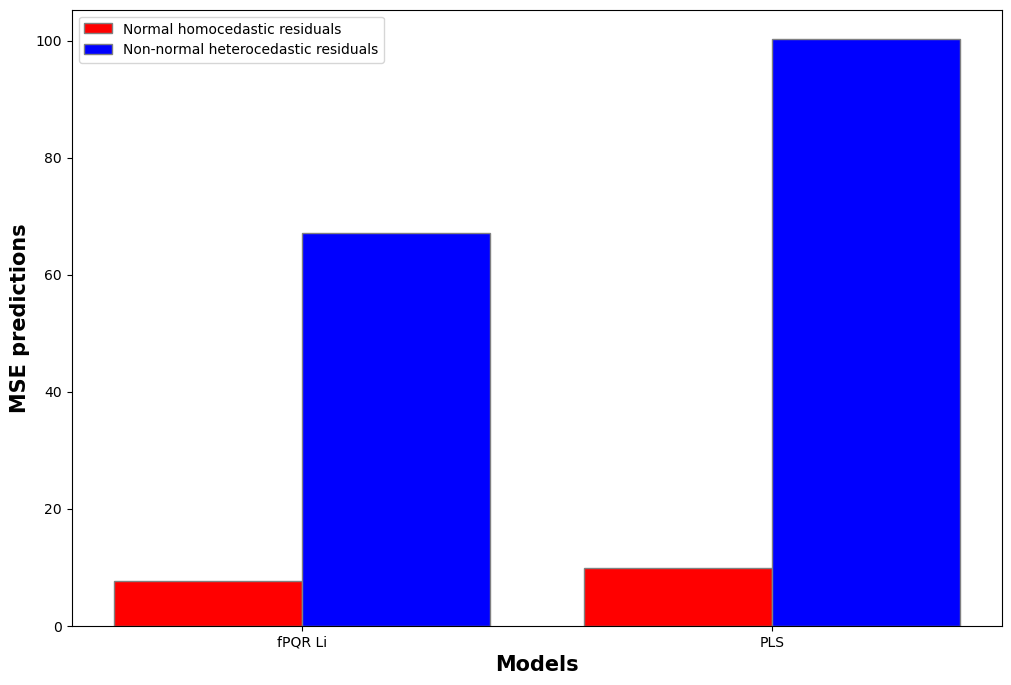

In [44]:
# set width of bar
barWidth = 0.40
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
assumptions = [li_pred_mse, pls_pred_mse]
no_assumptions = [li_pred_mse_out, pls_pred_mse_out]
 
# Set position of bar on X axis
br1 = np.arange(len(assumptions))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, assumptions, color ='r', width = barWidth,
        edgecolor ='grey', label ='Normal homocedastic residuals')
plt.bar(br2, no_assumptions, color ='b', width = barWidth,
        edgecolor ='grey', label ='Non-normal heterocedastic residuals')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('MSE predictions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(assumptions))],
        ['fPQR Li', 'PLS'])
 
plt.legend()
plt.show()

Aditionally, we want to test what happens maintaining the non-normal heterocedastic residuals and adding a non-normal distributions in the regressors. We set an $Exp(2)$ but the results are not good for fPQR.

In [865]:
# %%capture # This makes the cell not to display any output, in particular the warnings of pls

number_iterations = 30
sample_size = 100
number_of_ind_variables = 100
number_of_dep_variables = 3
number_of_significant_ind_variables = 30
number_of_components = number_of_significant_ind_variables
chi_sq_dg = 3
scale_parameter = 1
tau = 0.5
tau_eq = tau

li_coef_mse_i, li_pred_mse_i, li_pred_eq_i, li_time_i = [], [], [], []
li_coef_mse_i_out, li_pred_mse_i_out, li_pred_eq_i_out, li_time_i_out = [], [], [], []

dodge_coef_mse_i, dodge_pred_mse_i, dodge_pred_eq_i, dodge_time_i = [], [], [], []
dodge_coef_mse_i_out, dodge_pred_mse_i_out, dodge_pred_eq_i_out, dodge_time_i_out = [], [], [], []

choi_coef_mse_i, choi_pred_mse_i, choi_pred_eq_i, choi_time_i = [], [], [], []
choi_coef_mse_i_out, choi_pred_mse_i_out, choi_pred_eq_i_out, choi_time_i_out = [], [], [], []

pls_coef_mse_i, pls_pred_mse_i, pls_pred_eq_i, pls_time_i =[], [], [], []
pls_coef_mse_i_out, pls_pred_mse_i_out, pls_pred_eq_i_out, pls_time_i_out =[], [], [], []

#cov_matrix = np.random.uniform(-5, 5, size = (number_of_ind_variables, number_of_ind_variables))
#cov_matrix = np.tril(cov_matrix)  # Zero out the upper triangle
#cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
#min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
#if min_eigenvalue <= 0:
#    diagonal_addition = np.eye(number_of_ind_variables) * (-min_eigenvalue + 1e-6)
#    cov_matrix += diagonal_addition

# Create alternative covariance matrix
#cov_matrix_alternative = np.random.uniform(-20, 20, size = (number_of_ind_variables, number_of_ind_variables))
#cov_matrix_alternative = np.tril(cov_matrix)  # Zero out the upper triangle
#cov_matrix_alternative = cov_matrix_alternative + cov_matrix_alternative.T - np.diag(cov_matrix_alternative.diagonal())
#min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix_alternative))
#if min_eigenvalue <= 0:
#    diagonal_addition = np.eye(number_of_ind_variables) * (-min_eigenvalue + 1e-6)
#    cov_matrix_alternative += diagonal_addition

outliers_entries_train = np.random.choice(np.arange(0, sample_size), size=int(0.05*sample_size), replace=False) # 5% of outliers
outliers_entries_test = np.random.choice(np.arange(0, sample_size), size=int(0.05*sample_size), replace=False) # 5% of outliers

for i in range(number_iterations):
    
    # Generate train data for iteration
    # Create covariance matrix
    
    # Define the mean vector
    mean = np.zeros(number_of_ind_variables)
    # Sample data
    X_train = np.random.multivariate_normal(mean, np.identity(number_of_ind_variables), sample_size)
    B_train_significant = np.random.uniform(0, 1, size = (number_of_significant_ind_variables, number_of_dep_variables))
    B_train_noise = np.zeros((number_of_ind_variables - number_of_significant_ind_variables, number_of_dep_variables))
    B_train = np.concatenate((B_train_significant, B_train_noise))
    E_train = np.random.normal(0, 1, size=(sample_size, number_of_dep_variables))
    Y_train = X_train@B_train+E_train
    
    # Generate alterative train distribution
    X_train_alt = np.random.exponential(2, size=(sample_size, number_of_ind_variables))
    
    E_train_alt = np.zeros((sample_size, 3))
    for i in range(E_train_alt.shape[0]): 
        # Generate random values for each row
        E_train_alt[i, :] = np.random.chisquare(random.randint(1, 10), size=3)
        
    F_train = np.zeros((sample_size, 3))
    for i in range(F_train.shape[0]): 
        # Generate random values for each row
        F_train[i, :] = np.random.gamma(random.randint(1, 10), size=3)
    entries_train = np.random.choice(np.arange(0, len(E_train)), size=int(0.1*len(E_train)), replace=False)
    E_train_alternative = E_train_alt.copy()
    E_train_alternative[entries_train,:] = F_train[entries_train,:]
    
    Y_train_alt = X_train_alt@B_train+E_train_alternative
    
    #Test data
    X_test = np.random.multivariate_normal(mean, np.identity(number_of_ind_variables), sample_size)
    B_test_significant = np.random.uniform(0, 1, size = (number_of_significant_ind_variables, number_of_dep_variables))
    B_test_noise = np.zeros((number_of_ind_variables - number_of_significant_ind_variables, number_of_dep_variables))
    B_test = np.concatenate((B_test_significant, B_test_noise))
    E_test = np.random.normal(0, 1, size=(sample_size, number_of_dep_variables))
    Y_test = X_test@B_test+E_test
    
    # Generate alterative test distribution
    X_test_alt = np.random.exponential(2, size=(sample_size, number_of_ind_variables))
    
    E_test_alt = np.zeros((sample_size, 3))
    for i in range(E_test_alt.shape[0]): 
        # Generate random values for each row
        E_test_alt[i, :] = np.random.chisquare(random.randint(1, 10), size=3)
        
    F_test = np.zeros((sample_size, 3))
    for i in range(F_test.shape[0]): 
        # Generate random values for each row
        F_test[i, :] = np.random.gamma(random.randint(1, 10), size=3)
    entries_test = np.random.choice(np.arange(0, len(E_test)), size=int(0.1*len(E_test)), replace=False)
    E_test_alternative = E_test_alt.copy()
    E_test_alternative[entries_test,:] = F_test[entries_test,:]
 
    Y_test_alt = X_test_alt@B_test+E_test_alternative

    
    # Li without outliers
    start_time_li = time.time()
    fpqr_li = fpqr.FPQRegression(quantile=tau, n_components=30, metric='li')
    fpqr_li.fit(X_train, Y_train)
    end_time_li = time.time()
    execution_time_li = end_time_li - start_time_li
    B_estimated_li = fpqr_li.coef_
    predictions_li = fpqr_li.predict(X_test)
    
    li_time_i.append(execution_time_li)
    li_coef_mse_i.append(mean_squared_error(B_test, B_estimated_li))
    li_pred_mse_i.append(mean_squared_error(Y_test, predictions_li))
    li_pred_eq_i.append(_quantile_function(Y_test,predictions_li, tau_eq))
    
    # Li with outliers
    start_time_li_out = time.time()
    fpqr_li_out = fpqr.FPQRegression(quantile=tau, n_components=30, metric='li')
    fpqr_li_out.fit(X_train_out, Y_train_out)
    end_time_li_out = time.time()
    execution_time_li_out = end_time_li_out - start_time_li_out
    B_estimated_li_out = fpqr_li_out.coef_
    predictions_li_out = fpqr_li_out.predict(X_test)
    
    li_time_i_out.append(execution_time_li_out)
    li_coef_mse_i_out.append(mean_squared_error(B_test, B_estimated_li_out))
    li_pred_mse_i_out.append(mean_squared_error(Y_test_alt, predictions_li_out))
    li_pred_eq_i_out.append(_quantile_function(Y_test_alt,predictions_li_out, tau_eq))
    
    # PLS without outliers
    start_time_pls = time.time()
    pls_model = PLSRegression(n_components=30)  # By using PLS we regress to the mean
    pls_model.fit(X_train, Y_train)
    end_time_pls = time.time()
    execution_time_pls = end_time_pls - start_time_pls
    B_estimated_pls = pls_model.coef_ 
    predictions_pls = pls_model.predict(X_test)
    
    pls_time_i.append(execution_time_pls)
    pls_coef_mse_i.append(mean_squared_error(B_test, B_estimated_pls))
    pls_pred_mse_i.append(mean_squared_error(Y_test, predictions_pls))
    pls_pred_eq_i.append(_quantile_function(Y_test, predictions_pls, tau_eq))
    
    # PLS with outliers
    start_time_pls_out = time.time()
    pls_model_out = PLSRegression(n_components=30)  # By using PLS we regress to the mean
    pls_model_out.fit(X_train_out, Y_train_out)
    end_time_pls_out = time.time()
    execution_time_pls_out = end_time_pls_out - start_time_pls_out
    B_estimated_pls_out = pls_model_out.coef_ 
    predictions_pls_out = pls_model_out.predict(X_test)
    
    pls_time_i_out.append(execution_time_pls_out)
    pls_coef_mse_i_out.append(mean_squared_error(B_test, B_estimated_pls_out))
    pls_pred_mse_i_out.append(mean_squared_error(Y_test_alt, predictions_pls_out))
    pls_pred_eq_i_out.append(_quantile_function(Y_test_alt, predictions_pls_out, tau_eq))

li_coef_mse, li_pred_mse, li_pred_eq, li_time = np.mean(li_coef_mse_i), np.mean(li_pred_mse_i), np.mean(li_pred_eq_i), np.mean(li_time_i)
li_coef_mse_out, li_pred_mse_out, li_pred_eq_out, li_time_out = np.mean(li_coef_mse_i_out), np.mean(li_pred_mse_i_out), np.mean(li_pred_eq_i_out), np.mean(li_time_i_out)

pls_coef_mse, pls_pred_mse, pls_pred_eq, pls_time = np.mean(pls_coef_mse_i), np.mean(pls_pred_mse_i), np.mean(pls_pred_eq_i), np.mean(pls_time_i)
pls_coef_mse_out, pls_pred_mse_out, pls_pred_eq_out, pls_time_out = np.mean(pls_coef_mse_i_out), np.mean(pls_pred_mse_i_out), np.mean(pls_pred_eq_i_out), np.mean(pls_time_i_out)

C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

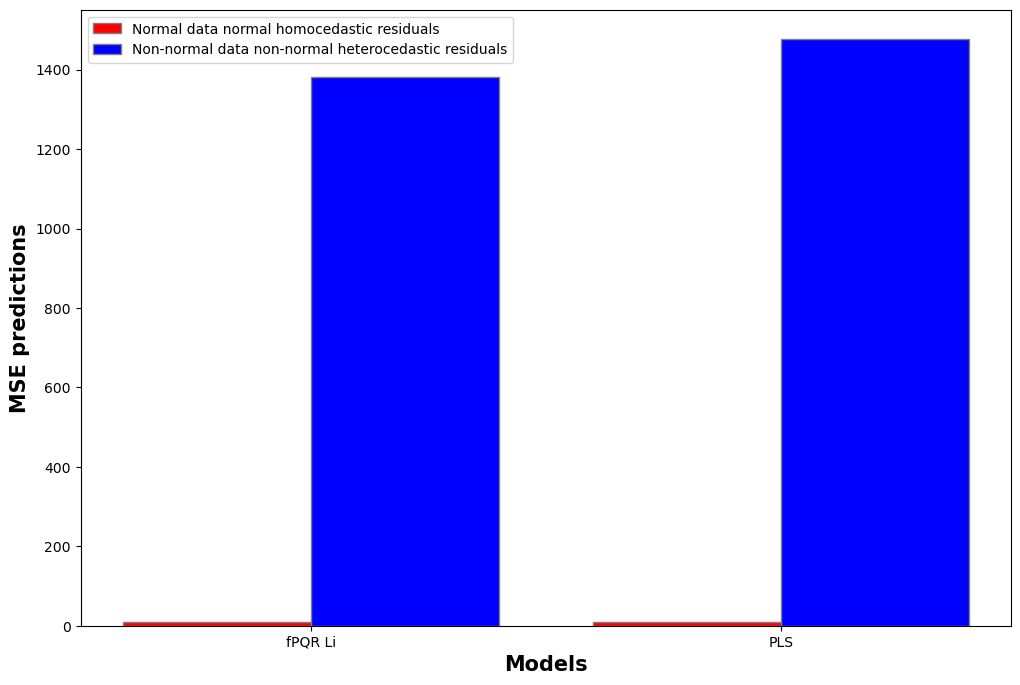

In [866]:
# set width of bar
barWidth = 0.40
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
assumptions = [li_pred_mse, pls_pred_mse]
no_assumptions = [li_pred_mse_out, pls_pred_mse_out]
 
# Set position of bar on X axis
br1 = np.arange(len(assumptions))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, assumptions, color ='r', width = barWidth,
        edgecolor ='grey', label ='Normal data normal homocedastic residuals')
plt.bar(br2, no_assumptions, color ='b', width = barWidth,
        edgecolor ='grey', label ='Non-normal data non-normal heterocedastic residuals')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('MSE predictions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(assumptions))],
        ['fPQR Li', 'PLS'])
 
plt.legend()
plt.show()

## Final loop with all the models

### Simulating outliers 1

Regressors $X\sim N(0_p,I_p)$, significant coeficients $b_{ij}\sim U(0,1)$, $i=1,...,30$, noise coeficients $b_{ij}=0$ $i=31,\ldots,100$, residuals $\epsilon_{ij}\sim N(0,1)$, response $Y=XB+E$.

In [57]:
# %%capture # This makes the cell not to display any output, in particular the warnings of pls

number_iterations = 50
sample_size = 100
number_of_ind_variables = 100
number_of_dep_variables = 3
number_of_significant_ind_variables = 30
number_of_components = number_of_significant_ind_variables
chi_sq_dg = 3
scale_parameter = 1
tau = 0.5
tau_eq = tau

li_coef_mse_i, li_pred_mse_i, li_pred_eq_i, li_time_i = [], [], [], []
li_coef_mse_i_out, li_pred_mse_i_out, li_pred_eq_i_out, li_time_i_out = [], [], [], []

dodge_coef_mse_i, dodge_pred_mse_i, dodge_pred_eq_i, dodge_time_i = [], [], [], []
dodge_coef_mse_i_out, dodge_pred_mse_i_out, dodge_pred_eq_i_out, dodge_time_i_out = [], [], [], []

choi_coef_mse_i, choi_pred_mse_i, choi_pred_eq_i, choi_time_i = [], [], [], []
choi_coef_mse_i_out, choi_pred_mse_i_out, choi_pred_eq_i_out, choi_time_i_out = [], [], [], []

pls_coef_mse_i, pls_pred_mse_i, pls_pred_eq_i, pls_time_i =[], [], [], []
pls_coef_mse_i_out, pls_pred_mse_i_out, pls_pred_eq_i_out, pls_time_i_out =[], [], [], []

# Create covariance matrix
#cov_matrix = np.random.uniform(-5, 5, size = (number_of_ind_variables, number_of_ind_variables))
#cov_matrix = np.tril(cov_matrix)  # Zero out the upper triangle
#cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
#min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
#if min_eigenvalue <= 0:
#    diagonal_addition = np.eye(number_of_ind_variables) * (-min_eigenvalue + 1e-6)
#    cov_matrix += diagonal_addition

# Create alternative covariance matrix
#cov_matrix_alternative = np.random.uniform(-20, 20, size = (number_of_ind_variables, number_of_ind_variables))
#cov_matrix_alternative = np.tril(cov_matrix)  # Zero out the upper triangle
#cov_matrix_alternative = cov_matrix_alternative + cov_matrix_alternative.T - np.diag(cov_matrix_alternative.diagonal())
#min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix_alternative))
#if min_eigenvalue <= 0:
#    diagonal_addition = np.eye(number_of_ind_variables) * (-min_eigenvalue + 1e-6)
#    cov_matrix_alternative += diagonal_addition


for i in range(number_iterations):
    
    # Generate train data for iteration
    # Create covariance matrix
    
    # Define the mean vector
    mean = np.zeros(number_of_ind_variables)
    # Sample data
    X_train = np.random.multivariate_normal(mean, np.identity(number_of_ind_variables), sample_size)
    B_train_significant = np.random.uniform(0, 1, size = (number_of_significant_ind_variables, number_of_dep_variables))
    B_train_noise = np.zeros((number_of_ind_variables - number_of_significant_ind_variables, number_of_dep_variables))
    B_train = np.concatenate((B_train_significant, B_train_noise))
    E_train = np.random.normal(0, 1, size=(sample_size, number_of_dep_variables))
    Y_train = X_train@B_train+E_train
    
    # Generate alterative distribution
    # Define alternative mean vector
    mean_alternative = np.full(number_of_ind_variables, 90)
    # Sample alternative data
    X_train_alternative = np.random.multivariate_normal(mean_alternative, np.identity(number_of_ind_variables), sample_size)
    E_train_alternative = np.random.normal(6, 15, size=(sample_size, number_of_dep_variables))
    
    # Include outliers in the original distribution from the alternative one
    outliers_entries_train = np.random.choice(np.arange(0, len(X_train)), size=int(0.05*len(X_train)), replace=False) # 5% of outliers
    X_train_out = X_train.copy()
    X_train_out[outliers_entries_train,:] = X_train_alternative[outliers_entries_train,:]
    E_train_out = E_train.copy()
    E_train_out[outliers_entries_train,:] = E_train_alternative[outliers_entries_train,:]
    Y_train_out = X_train_out@B_train + E_train_out
    
    #Test data
    X_test = np.random.multivariate_normal(mean, np.identity(number_of_ind_variables), sample_size)
    B_test_significant = np.random.uniform(0, 1, size = (number_of_significant_ind_variables, number_of_dep_variables))
    B_test_noise = np.zeros((number_of_ind_variables - number_of_significant_ind_variables, number_of_dep_variables))
    B_test = np.concatenate((B_test_significant, B_test_noise))
    E_test = np.random.normal(0, 1, size=(sample_size, number_of_dep_variables))
    Y_test = X_test@B_test+E_test
    
    # Define alternative mean vector
    mean_alternative = np.full(number_of_ind_variables, 90)
    # Sample alternative data
    X_test_alternative = np.random.multivariate_normal(mean_alternative, np.identity(number_of_ind_variables), sample_size)
    E_test_alternative = np.random.normal(6, 15, size=(sample_size, number_of_dep_variables))
    
    # Include outliers in the original distribution from the alternative one
    outliers_entries_test = np.random.choice(np.arange(0, len(X_test)), size=int(0.05*len(X_test)), replace=False) # 5% of outliers
    X_test_out = X_test.copy()
    X_test_out[outliers_entries_test,:] = X_test_alternative[outliers_entries_test,:]
    E_test_out = E_test.copy()
    E_test_out[outliers_entries_test,:] = E_test_alternative[outliers_entries_test,:]
    Y_test_out = X_test_out@B_test + E_test_out

    
    # Li without outliers
    start_time_li = time.time()
    fpqr_li = fpqr.FPQRegression(quantile=tau, n_components=30, metric='li')
    fpqr_li.fit(X_train, Y_train)
    end_time_li = time.time()
    execution_time_li = end_time_li - start_time_li
    B_estimated_li = fpqr_li.coef_
    predictions_li = fpqr_li.predict(X_test)
    
    li_time_i.append(execution_time_li)
    li_coef_mse_i.append(mean_squared_error(B_train, B_estimated_li))
    li_pred_mse_i.append(mean_squared_error(Y_test, predictions_li))
    li_pred_eq_i.append(_quantile_function(Y_test, predictions_li, tau_eq))
    
    # Li with outliers
    start_time_li_out = time.time()
    fpqr_li_out = fpqr.FPQRegression(quantile=tau, n_components=30, metric='li')
    fpqr_li_out.fit(X_train_out, Y_train_out)
    end_time_li_out = time.time()
    execution_time_li_out = end_time_li_out - start_time_li_out
    B_estimated_li_out = fpqr_li_out.coef_
    predictions_li_out = fpqr_li_out.predict(X_test)
    
    li_time_i_out.append(execution_time_li_out)
    li_coef_mse_i_out.append(mean_squared_error(B_train, B_estimated_li_out))
    li_pred_mse_i_out.append(mean_squared_error(Y_test, predictions_li_out))
    li_pred_eq_i_out.append(_quantile_function(Y_test, predictions_li_out, tau_eq))
    
    # Dodge without outliers
    start_time_dodge = time.time()
    fpqr_dodge = fpqr.FPQRegression(quantile=tau, n_components=30, metric='dodge')
    fpqr_dodge.fit(X_train, Y_train)
    end_time_dodge = time.time()
    execution_time_dodge = end_time_dodge - start_time_dodge
    B_estimated_dodge = fpqr_dodge.coef_
    predictions_dodge = fpqr_dodge.predict(X_test)
    
    dodge_time_i.append(execution_time_dodge)
    dodge_coef_mse_i.append(mean_squared_error(B_train, B_estimated_dodge))
    dodge_pred_mse_i.append(mean_squared_error(Y_test, predictions_dodge))
    dodge_pred_eq_i.append(_quantile_function(Y_test, predictions_dodge, tau_eq))
    
    # Dodge with outliers
    start_time_dodge_out = time.time()
    fpqr_dodge_out = fpqr.FPQRegression(quantile=tau, n_components=30, metric='dodge')
    fpqr_dodge_out.fit(X_train_out, Y_train_out)
    end_time_dodge_out = time.time()
    execution_time_dodge_out = end_time_dodge_out - start_time_dodge_out
    B_estimated_dodge_out = fpqr_dodge_out.coef_
    predictions_dodge_out = fpqr_dodge_out.predict(X_test)
    
    dodge_time_i_out.append(execution_time_dodge_out)
    dodge_coef_mse_i_out.append(mean_squared_error(B_train, B_estimated_dodge_out))
    dodge_pred_mse_i_out.append(mean_squared_error(Y_test, predictions_dodge_out))
    dodge_pred_eq_i_out.append(_quantile_function(Y_test, predictions_dodge_out, tau_eq))

    # Choi without outliers
    start_time_choi = time.time()
    fpqr_choi = fpqr.FPQRegression(quantile=tau, n_components=30, metric='choi')
    fpqr_choi.fit(X_train, Y_train)
    end_time_choi = time.time()
    execution_time_choi = end_time_choi - start_time_choi
    B_estimated_choi = fpqr_choi.coef_
    predictions_choi = fpqr_choi.predict(X_test)
    
    choi_time_i.append(execution_time_choi)
    choi_coef_mse_i.append(mean_squared_error(B_train, B_estimated_choi))
    choi_pred_mse_i.append(mean_squared_error(Y_test, predictions_choi))
    choi_pred_eq_i.append(_quantile_function(Y_test, predictions_choi, tau_eq))
    
    # Choi with outliers
    start_time_choi_out = time.time()
    fpqr_choi_out = fpqr.FPQRegression(quantile=tau, n_components=30, metric='choi')
    fpqr_choi_out.fit(X_train_out, Y_train_out)
    end_time_choi_out = time.time()
    execution_time_choi_out = end_time_choi_out - start_time_choi_out
    B_estimated_choi_out = fpqr_choi_out.coef_
    predictions_choi_out = fpqr_choi_out.predict(X_test)
    
    choi_time_i_out.append(execution_time_choi_out)
    choi_coef_mse_i_out.append(mean_squared_error(B_train, B_estimated_choi_out))
    choi_pred_mse_i_out.append(mean_squared_error(Y_test, predictions_choi_out))
    choi_pred_eq_i_out.append(_quantile_function(Y_test, predictions_choi_out, tau_eq))
    
    # PLS without outliers
    start_time_pls = time.time()
    pls_model = PLSRegression(n_components=30)  # By using PLS we regress to the mean
    pls_model.fit(X_train, Y_train)
    end_time_pls = time.time()
    execution_time_pls = end_time_pls - start_time_pls
    B_estimated_pls = pls_model.coef_ 
    predictions_pls = pls_model.predict(X_test)
    
    pls_time_i.append(execution_time_pls)
    pls_coef_mse_i.append(mean_squared_error(B_train, B_estimated_pls))
    pls_pred_mse_i.append(mean_squared_error(Y_test, predictions_pls))
    pls_pred_eq_i.append(_quantile_function(Y_test, predictions_pls, tau_eq))
    
    # PLS with outliers
    start_time_pls_out = time.time()
    pls_model_out = PLSRegression(n_components=30)  # By using PLS we regress to the mean
    pls_model_out.fit(X_train_out, Y_train_out)
    end_time_pls_out = time.time()
    execution_time_pls_out = end_time_pls_out - start_time_pls_out
    B_estimated_pls_out = pls_model_out.coef_ 
    predictions_pls_out = pls_model_out.predict(X_test)
    
    pls_time_i_out.append(execution_time_pls_out)
    pls_coef_mse_i_out.append(mean_squared_error(B_train, B_estimated_pls_out))
    pls_pred_mse_i_out.append(mean_squared_error(Y_test, predictions_pls_out))
    pls_pred_eq_i_out.append(_quantile_function(Y_test, predictions_pls_out, tau_eq))

li_coef_mse, li_pred_mse, li_pred_eq, li_time = np.mean(li_coef_mse_i), np.mean(li_pred_mse_i), np.mean(li_pred_eq_i), np.mean(li_time_i)
li_coef_mse_out, li_pred_mse_out, li_pred_eq_out, li_time_out = np.mean(li_coef_mse_i_out), np.mean(li_pred_mse_i_out), np.mean(li_pred_eq_i_out), np.mean(li_time_i_out)

dodge_coef_mse, dodge_pred_mse, dodge_pred_eq, dodge_time = np.mean(dodge_coef_mse_i), np.mean(dodge_pred_mse_i), np.mean(dodge_pred_eq_i), np.mean(dodge_time_i)
dodge_coef_mse_out, dodge_pred_mse_out, dodge_pred_eq_out, dodge_time_out = np.mean(dodge_coef_mse_i_out), np.mean(dodge_pred_mse_i_out), np.mean(dodge_pred_eq_i_out), np.mean(dodge_time_i_out)

choi_coef_mse, choi_pred_mse, choi_pred_eq, choi_time = np.mean(choi_coef_mse_i), np.mean(choi_pred_mse_i), np.mean(choi_pred_eq_i), np.mean(choi_time_i)
choi_coef_mse_out, choi_pred_mse_out, choi_pred_eq_out, choi_time_out = np.mean(choi_coef_mse_i_out), np.mean(choi_pred_mse_i_out), np.mean(choi_pred_eq_i_out), np.mean(choi_time_i_out)

pls_coef_mse, pls_pred_mse, pls_pred_eq, pls_time = np.mean(pls_coef_mse_i), np.mean(pls_pred_mse_i), np.mean(pls_pred_eq_i), np.mean(pls_time_i)
pls_coef_mse_out, pls_pred_mse_out, pls_pred_eq_out, pls_time_out = np.mean(pls_coef_mse_i_out), np.mean(pls_pred_mse_i_out), np.mean(pls_pred_eq_i_out), np.mean(pls_time_i_out)

C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

In [58]:
print("Execution time Li:", li_time, "seconds")
print("MSE coef Li:", li_coef_mse)
print("MSE pred Li:", li_pred_mse)
print("Quantile error pred Li:", li_pred_eq)
print("Execution time Li out:", li_time_out, "seconds")
print("MSE coef Li out:", li_coef_mse_out)
print("MSE pred Li out:", li_pred_mse_out)
print("Quantile error pred Li out:", li_pred_eq_out)
print("Execution time Dodge:", dodge_time, "seconds")
print("MSE coef Dodge:", dodge_coef_mse)
print("MSE pred Dodge:", dodge_pred_mse)
print("Quantile error pred Dodge:", dodge_pred_eq)
print("Execution time Dodge out:", dodge_time_out, "seconds")
print("MSE coef Dodge out:", dodge_coef_mse_out)
print("MSE pred Dodge out:", dodge_pred_mse_out)
print("Quantile error pred Dodge out:", dodge_pred_eq_out)
print("Execution time Choi:", choi_time, "seconds")
print("MSE coef Choi:", choi_coef_mse)
print("MSE pred Choi:", choi_pred_mse)
print("Quantile error pred Choi:", choi_pred_eq)
print("Execution time Choi out:", choi_time_out, "seconds")
print("MSE coef Choi out:", choi_coef_mse_out)
print("MSE pred Choi out:", choi_pred_mse_out)
print("Quantile error pred Choi out:", choi_pred_eq_out)
print("Execution time PLS:", pls_time, "seconds")
print("MSE coef PLS:", pls_coef_mse)
print("MSE pred PLS:", pls_pred_mse)
print("Quantile error pred PLS:", pls_pred_eq)
print("Execution time PLS out:", pls_time_out, "seconds")
print("MSE coef PLS out:", pls_coef_mse_out)
print("MSE pred PLS out:", pls_pred_mse_out)
print("Quantile error pred PLS out:", pls_pred_eq_out)

Execution time Li: 0.20244019508361816 seconds
MSE coef Li: 0.028232078878823424
MSE pred Li: 7.826717590471529
Quantile error pred Li: 0.06957576075329591
Execution time Li out: 0.1995454502105713 seconds
MSE coef Li out: 0.08282375018253493
MSE pred Li out: 13.039190540745777
Quantile error pred Li out: 0.08838076272453532
Execution time Dodge: 162.23923817157745 seconds
MSE coef Dodge: 0.030000641931074795
MSE pred Dodge: 8.113485535962122
Quantile error pred Dodge: 0.07090382575318502
Execution time Dodge out: 162.76362940311432 seconds
MSE coef Dodge out: 0.10760694901178508
MSE pred Dodge out: 15.819765853116264
Quantile error pred Dodge out: 0.09584492261132255
Execution time Choi: 324.09092349529266 seconds
MSE coef Choi: 0.03558189367207108
MSE pred Choi: 8.803252939202933
Quantile error pred Choi: 0.07446815919618213
Execution time Choi out: 322.64093541145326 seconds
MSE coef Choi out: 0.23591376164427363
MSE pred Choi out: 28.445421816859856
Quantile error pred Choi out: 0.

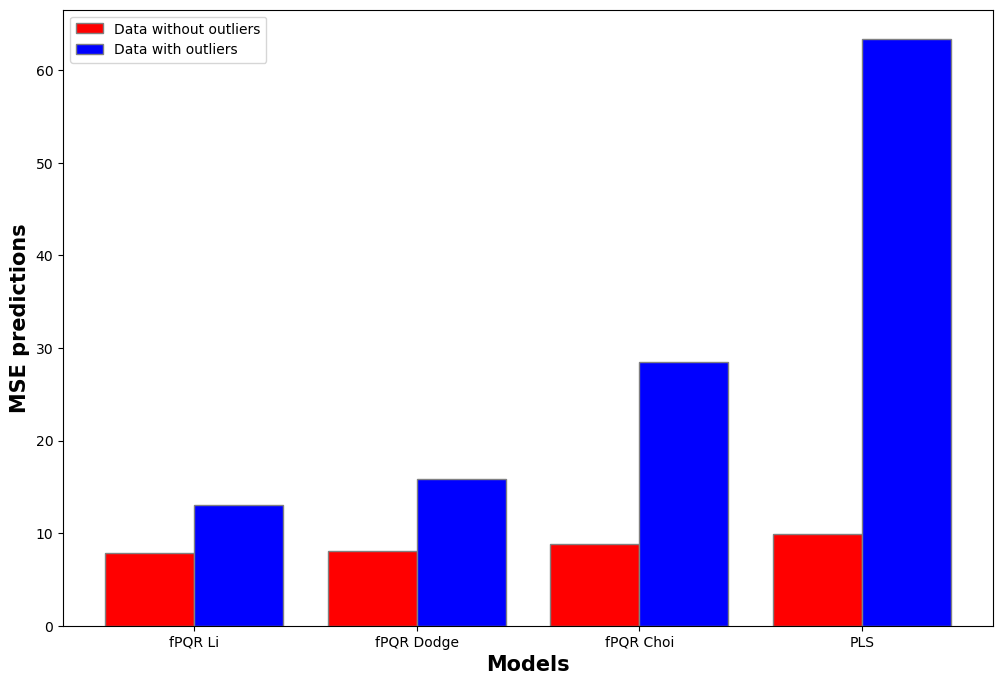

In [59]:
# set width of bar
barWidth = 0.40
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
assumptions = [li_pred_mse, dodge_pred_mse, choi_pred_mse, pls_pred_mse]
no_assumptions = [li_pred_mse_out, dodge_pred_mse_out, choi_pred_mse_out, pls_pred_mse_out]
 
# Set position of bar on X axis
br1 = np.arange(len(assumptions))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, assumptions, color ='r', width = barWidth,
        edgecolor ='grey', label ='Data without outliers')
plt.bar(br2, no_assumptions, color ='b', width = barWidth,
        edgecolor ='grey', label ='Data with outliers')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('MSE predictions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(assumptions))],
        ['fPQR Li', 'fPQR Dodge', 'fPQR Choi', 'PLS'])
 
plt.legend()
plt.show()

### Simulating non assumed distributions

In [61]:
# %%capture # This makes the cell not to display any output, in particular the warnings of pls

number_iterations = 50
sample_size = 100
number_of_ind_variables = 100
number_of_dep_variables = 3
number_of_significant_ind_variables = 30
number_of_components = number_of_significant_ind_variables
chi_sq_dg = 3
scale_parameter = 1
tau = 0.5
tau_eq = tau

li_coef_mse_i, li_pred_mse_i, li_pred_eq_i, li_time_i = [], [], [], []
li_coef_mse_i_out, li_pred_mse_i_out, li_pred_eq_i_out, li_time_i_out = [], [], [], []

dodge_coef_mse_i, dodge_pred_mse_i, dodge_pred_eq_i, dodge_time_i = [], [], [], []
dodge_coef_mse_i_out, dodge_pred_mse_i_out, dodge_pred_eq_i_out, dodge_time_i_out = [], [], [], []

choi_coef_mse_i, choi_pred_mse_i, choi_pred_eq_i, choi_time_i = [], [], [], []
choi_coef_mse_i_out, choi_pred_mse_i_out, choi_pred_eq_i_out, choi_time_i_out = [], [], [], []

pls_coef_mse_i, pls_pred_mse_i, pls_pred_eq_i, pls_time_i =[], [], [], []
pls_coef_mse_i_out, pls_pred_mse_i_out, pls_pred_eq_i_out, pls_time_i_out =[], [], [], []

# Create covariance matrix
#cov_matrix = np.random.uniform(-5, 5, size = (number_of_ind_variables, number_of_ind_variables))
#cov_matrix = np.tril(cov_matrix)  # Zero out the upper triangle
#cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
#min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
#if min_eigenvalue <= 0:
#    diagonal_addition = np.eye(number_of_ind_variables) * (-min_eigenvalue + 1e-6)
#    cov_matrix += diagonal_addition

# Create alternative covariance matrix
#cov_matrix_alternative = np.random.uniform(-20, 20, size = (number_of_ind_variables, number_of_ind_variables))
#cov_matrix_alternative = np.tril(cov_matrix)  # Zero out the upper triangle
#cov_matrix_alternative = cov_matrix_alternative + cov_matrix_alternative.T - np.diag(cov_matrix_alternative.diagonal())
#min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix_alternative))
#if min_eigenvalue <= 0:
#    diagonal_addition = np.eye(number_of_ind_variables) * (-min_eigenvalue + 1e-6)
#    cov_matrix_alternative += diagonal_addition


for i in range(number_iterations):
    
    # Generate train data for iteration
    # Define the mean vector
    mean = np.zeros(number_of_ind_variables)
    # Sample data
    X_train = np.random.multivariate_normal(mean, np.identity(number_of_ind_variables), sample_size)
    B_train_significant = np.random.uniform(0, 1, size = (number_of_significant_ind_variables, number_of_dep_variables))
    B_train_noise = np.zeros((number_of_ind_variables - number_of_significant_ind_variables, number_of_dep_variables))
    B_train = np.concatenate((B_train_significant, B_train_noise))
    E_train = np.random.normal(0, 1, size=(sample_size, number_of_dep_variables))
    Y_train = X_train@B_train+E_train
    
    # Generate alterative train distribution
    E_train_alt = np.zeros((sample_size, 3))
    for i in range(E_train_alt.shape[0]): 
        # Generate random values for each row
        E_train_alt[i, :] = np.random.chisquare(random.randint(1, 10), size=3)
        
    F_train = np.zeros((sample_size, 3))
    for i in range(F_train.shape[0]): 
        # Generate random values for each row
        F_train[i, :] = np.random.exponential(random.randint(1, 10), size=3)
    entries_train = np.random.choice(np.arange(0, len(E_train)), size=int(0.1*len(E_train)), replace=False)
    E_train_alternative = E_train_alt.copy()
    E_train_alternative[entries_train,:] = F_train[entries_train,:]
    
    Y_train_alt = X_train@B_train+E_train_alternative
    
    #Test data
    X_test = np.random.multivariate_normal(mean, np.identity(number_of_ind_variables), sample_size)
    B_test_significant = np.random.uniform(0, 1, size = (number_of_significant_ind_variables, number_of_dep_variables))
    B_test_noise = np.zeros((number_of_ind_variables - number_of_significant_ind_variables, number_of_dep_variables))
    B_test = np.concatenate((B_test_significant, B_test_noise))
    E_test = np.random.normal(0, 1, size=(sample_size, number_of_dep_variables))
    Y_test = X_test@B_test+E_test
    
    # Generate alterative test distribution
    E_test_alt = np.zeros((sample_size, 3))
    for i in range(E_test_alt.shape[0]): 
        # Generate random values for each row
        E_test_alt[i, :] = np.random.chisquare(random.randint(1, 10), size=3)
        
    F_test = np.zeros((sample_size, 3))
    for i in range(F_test.shape[0]): 
        # Generate random values for each row
        F_test[i, :] = np.random.exponential(random.randint(1, 10), size=3)
    entries_test = np.random.choice(np.arange(0, len(E_test)), size=int(0.1*len(E_test)), replace=False)
    E_test_alternative = E_test_alt.copy()
    E_test_alternative[entries_test,:] = F_test[entries_test,:]
 
    Y_test_alt = X_test@B_test+E_test_alternative

        
    # Li alternative
    start_time_li_out = time.time()
    fpqr_li_out = fpqr.FPQRegression(quantile=tau, n_components=30, metric='li')
    fpqr_li_out.fit(X_train, Y_train_alt)
    end_time_li_out = time.time()
    execution_time_li_out = end_time_li_out - start_time_li_out
    B_estimated_li_out = fpqr_li_out.coef_
    predictions_li_out = fpqr_li_out.predict(X_test)
    
    li_time_i_out.append(execution_time_li_out)
    li_coef_mse_i_out.append(mean_squared_error(B_train, B_estimated_li_out))
    li_pred_mse_i_out.append(mean_squared_error(Y_test_alt, predictions_li_out))
    li_pred_eq_i_out.append(_quantile_function(Y_test_alt, predictions_li_out, tau_eq))
    
    # Dodge alternative
    start_time_dodge_out = time.time()
    fpqr_dodge_out = fpqr.FPQRegression(quantile=tau, n_components=30, metric='dodge')
    fpqr_dodge_out.fit(X_train, Y_train_alt)
    end_time_dodge_out = time.time()
    execution_time_dodge_out = end_time_dodge_out - start_time_dodge_out
    B_estimated_dodge_out = fpqr_dodge_out.coef_
    predictions_dodge_out = fpqr_dodge_out.predict(X_test)
    
    dodge_time_i_out.append(execution_time_dodge_out)
    dodge_coef_mse_i_out.append(mean_squared_error(B_train, B_estimated_dodge_out))
    dodge_pred_mse_i_out.append(mean_squared_error(Y_test_alt, predictions_dodge_out))
    dodge_pred_eq_i_out.append(_quantile_function(Y_test_alt, predictions_dodge_out, tau_eq))
    
    # Choi alternative
    start_time_choi_out = time.time()
    fpqr_choi_out = fpqr.FPQRegression(quantile=tau, n_components=30, metric='choi')
    fpqr_choi_out.fit(X_train, Y_train_alt)
    end_time_choi_out = time.time()
    execution_time_choi_out = end_time_choi_out - start_time_choi_out
    B_estimated_choi_out = fpqr_choi_out.coef_
    predictions_choi_out = fpqr_choi_out.predict(X_test)
    
    choi_time_i_out.append(execution_time_choi_out)
    choi_coef_mse_i_out.append(mean_squared_error(B_train, B_estimated_choi_out))
    choi_pred_mse_i_out.append(mean_squared_error(Y_test_alt, predictions_choi_out))
    choi_pred_eq_i_out.append(_quantile_function(Y_test_alt, predictions_choi_out, tau_eq))
    
    # PLS alternative
    start_time_pls_out = time.time()
    pls_model_out = PLSRegression(n_components=30)  # By using PLS we regress to the mean
    pls_model_out.fit(X_train, Y_train_alt)
    end_time_pls_out = time.time()
    execution_time_pls_out = end_time_pls_out - start_time_pls_out
    B_estimated_pls_out = pls_model_out.coef_ 
    predictions_pls_out = pls_model_out.predict(X_test)
    
    pls_time_i_out.append(execution_time_pls_out)
    pls_coef_mse_i_out.append(mean_squared_error(B_train, B_estimated_pls_out))
    pls_pred_mse_i_out.append(mean_squared_error(Y_test_alt, predictions_pls_out))
    pls_pred_eq_i_out.append(_quantile_function(Y_test_alt, predictions_pls_out, tau_eq))

li_coef_mse_alt, li_pred_mse_alt, li_pred_eq_alt, li_time_alt = np.mean(li_coef_mse_i_out), np.mean(li_pred_mse_i_out), np.mean(li_pred_eq_i_out), np.mean(li_time_i_out)

dodge_coef_mse_alt, dodge_pred_mse_alt, dodge_pred_eq_alt, dodge_time_alt = np.mean(dodge_coef_mse_i_out), np.mean(dodge_pred_mse_i_out), np.mean(dodge_pred_eq_i_out), np.mean(dodge_time_i_out)

choi_coef_mse_alt, choi_pred_mse_alt, choi_pred_eq_alt, choi_time_alt = np.mean(choi_coef_mse_i_out), np.mean(choi_pred_mse_i_out), np.mean(choi_pred_eq_i_out), np.mean(choi_time_i_out)

pls_coef_mse_alt, pls_pred_mse_alt, pls_pred_eq_alt, pls_time_alt = np.mean(pls_coef_mse_i_out), np.mean(pls_pred_mse_i_out), np.mean(pls_pred_eq_i_out), np.mean(pls_time_i_out)

C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the futur

In [62]:
print("Execution time Li alt:", li_time_alt, "seconds")
print("MSE coef Li alt:", li_coef_mse_alt)
print("MSE pred Li alt:", li_pred_mse_alt)
print("Quantile error pred Li alt:", li_pred_eq_alt)
print("Execution time Dodge alt:", dodge_time_alt, "seconds")
print("MSE coef Dodge alt:", dodge_coef_mse_alt)
print("MSE pred Dodge alt:", dodge_pred_mse_alt)
print("Quantile error pred Dodge alt:", dodge_pred_eq_alt)
print("Execution time Choi alt:", choi_time_alt, "seconds")
print("MSE coef Choi alt:", choi_coef_mse_alt)
print("MSE pred Choi alt:", choi_pred_mse_alt)
print("Quantile error pred Choi alt:", choi_pred_eq_alt)
print("Execution time PLS alt:", pls_time_alt, "seconds")
print("MSE coef PLS alt:", pls_coef_mse_alt)
print("MSE pred PLS alt:", pls_pred_mse_alt)
print("Quantile error pred PLS alt:", pls_pred_eq_alt)

Execution time Li alt: 0.5452830123901368 seconds
MSE coef Li alt: 0.31283136706206455
MSE pred Li alt: 57.8053152894562
Quantile error pred Li alt: 0.1991721755250349
Execution time Dodge alt: 165.07766990184783 seconds
MSE coef Dodge alt: 0.3566061179816608
MSE pred Dodge alt: 62.06295325893598
Quantile error pred Dodge alt: 0.20567769970745509
Execution time Choi alt: 324.96972234249114 seconds
MSE coef Choi alt: 0.5573612929014304
MSE pred Choi alt: 82.04858956760096
Quantile error pred Choi alt: 0.23284358115192003
Execution time PLS alt: 0.044682765007019044 seconds
MSE coef PLS alt: 1.0326578771745156
MSE pred PLS alt: 132.9550532539331
Quantile error pred PLS alt: 0.2855175227754535


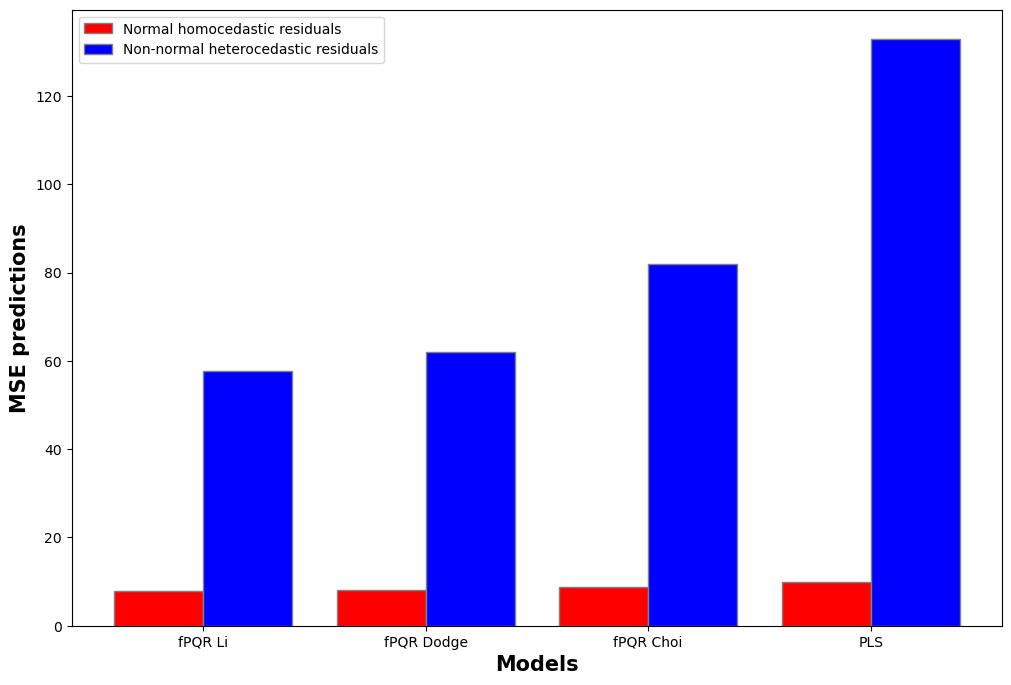

In [63]:
# set width of bar
barWidth = 0.40
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
assumptions = [li_pred_mse, dodge_pred_mse, choi_pred_mse, pls_pred_mse]
no_assumptions = [li_pred_mse_alt, dodge_pred_mse_alt, choi_pred_mse_alt, pls_pred_mse_alt]
 
# Set position of bar on X axis
br1 = np.arange(len(assumptions))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, assumptions, color ='r', width = barWidth,
        edgecolor ='grey', label ='Normal homocedastic residuals')
plt.bar(br2, no_assumptions, color ='b', width = barWidth,
        edgecolor ='grey', label ='Non-normal heterocedastic residuals')
 
# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('MSE predictions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(assumptions))],
        ['fPQR Li', 'fPQR Dodge', 'fPQR Choi', 'PLS'])
 
plt.legend()
plt.show()

## Playing with the inner comands of PCR, PLS and fPQR to study loadings and scores

#### Define again a dataset to avoid misleadings with other cells

In [945]:
sample_size = 100

# Define the covarianze matrix
cov_matrix = np.random.uniform(-5, 5, size = (100, 100)) # np.array([[2.0, 0.5], [0.5, 1.0]])
cov_matrix = np.tril(cov_matrix)  # Zero out the upper triangle
cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
if min_eigenvalue <= 0:
    diagonal_addition = np.eye(sample_size) * (-min_eigenvalue + 1e-6)
    cov_matrix += diagonal_addition
    
# Define the mean vector 
mean = np.random.randint(-10, 11, sample_size)

# Define the independent variables
X = np.random.multivariate_normal(mean, cov_matrix, sample_size)

# Define the dependent variables
B_significant = np.random.uniform(0, 1, size = (30, 3))
B_noise = np.zeros((70, 3))
B = np.concatenate((B_significant, B_noise))
E = np.random.chisquare(3, size = (100, 3))
Y = X@B+E
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=123)

#### Train the models

In [946]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=30), LinearRegression())
pcr.fit(X_train, Y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=30)
pls.fit(X_train, Y_train)

fpqr_li = fpqr.FPQRegression(quantile=0.99, n_components=30, metric='li')
fpqr_li.fit(X_train, Y_train)

C:\Users\jorge\anaconda3\lib\site-packages\asgl\asgl.py:97: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(self.tol, np.float):


In [947]:
pd.DataFrame(pls_model.x_scores_)

0         1         2         3         4         5         6   \
0  -1.179819 -0.009436  1.416300  1.182523  1.665227  0.840920  0.301366   
1  -0.159762  0.875185  0.457371  2.337098  0.999734 -2.807558 -1.427144   
2  -0.118127  1.078126 -3.123344  2.358011 -2.413097 -0.223876  3.159926   
3  -1.269367  4.681921 -0.023855  0.165737  0.088843  1.413126  0.475873   
4  -0.685370  0.308506  1.345131  2.800498  0.506980 -1.151403  0.777555   
..       ...       ...       ...       ...       ...       ...       ...   
75 -0.590618  1.686690  2.062505  0.444210 -1.641119  0.305309 -1.208231   
76 -2.585122 -0.475276  3.035456 -1.720249 -1.873389  0.246373  0.779192   
77  0.152010  2.156384 -0.059387 -0.681534  0.150184  1.687487 -1.108773   
78  0.761297 -0.451056 -2.516241  1.274147 -2.886423  2.118643 -0.797937   
79 -0.494262  1.089713  2.708512  0.214030  0.409321 -1.183531  1.614917   

          7         8         9   ...        20        21        22        23  \
0   1.354493 -0.058982 -1.242068  ...  0.750240  0.468539 -0.902836  1.196411   
1  -1.166316  0.493894  0.152673  ...  0.876620  0.206416 -0.347865  0.725905   
2   1.558878  1.069065  0.441110  ...  0.451869  0.363860 -0.201979  0.526033   
3  -0.535016  2.248087 -0.657746  ... -0.365821 -2.375435 -0.741453  0.871319   
4  -1.985574 -0.174493 -2.556846  ...  0.563884  0.513479 -1.337804 -1.009517   
..       ...       ...       ...  ...       ...       ...       ...       ...   
75  1.527462 -2.488136 -0.422902  ...  2.080841 -1.256685  2.361329 -0.640411   
76 -1.468645 -1.657751  0.969031  ... -0.953156  1.156598 -2.024102 -0.369295   
77 -1.120346 -0.693589 -2.319340  ...  0.402805 -0.755970  1.052915 -1.055229   
78 -0.963699  0.164653 -0.040503  ... -0.981088  0.174439  1.278513  0.958511   
79  0.567180 -1.828740  2.093679  ... -0.194197 -2.261399 -0.215912 -0.718315   

          24        25        26        27        28        29  
0   1.372827  2.501756  2.748062 -0.359541  0.671311  0.128151  
1  -1.283539  0.312646  0.010718  0.617676  0.492676  1.415596  
2   0.550833 -2.274181  1.210241  0.789915 -1.234670 -0.992844  
3  -0.023412  0.275193 -1.694716 -0.735756 -1.549873 -0.321997  
4   1.759609 -0.969276 -0.391771  0.009724  0.875066  0.545165  
..       ...       ...       ...       ...       ...       ...  
75  0.367511 -2.162965  2.168423 -0.425396  1.024461  0.010811  
76 -0.031161  0.646720  0.197603  1.185199 -0.859526 -0.153205  
77  0.321248  0.297546 -0.079183  0.355238  0.320422 -0.985653  
78 -0.674927  1.746088 -0.923162  0.516915  0.635166  0.495831  
79 -0.460401  0.001876 -0.809860 -0.209636  0.473504  1.098207  

[80 rows x 30 columns]

In [948]:
pd.DataFrame(pls_model.x_loadings_)

0         1         2         3         4         5         6   \
0  -0.000489  0.268178 -0.013487  0.004671 -0.194893 -0.111049 -0.197788   
1   0.102415 -0.026283  0.225988  0.119253  0.012281  0.063922  0.027466   
2  -0.061556 -0.024821  0.181631 -0.076040 -0.052356 -0.171470 -0.226714   
3   0.102195 -0.004901  0.108849 -0.049507  0.028518 -0.088627 -0.013565   
4  -0.014038  0.186007  0.068609 -0.122350 -0.008314  0.215550  0.035430   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.084444 -0.034719 -0.023878  0.020977  0.085225 -0.062119 -0.102580   
96 -0.191248 -0.051639  0.070525 -0.001878 -0.052265  0.027716 -0.195375   
97 -0.050473 -0.003280  0.090396  0.053555  0.053310  0.031704 -0.012673   
98 -0.014781 -0.014580 -0.022028 -0.003627  0.143245  0.100434  0.286497   
99 -0.024232  0.124777 -0.054102 -0.111712 -0.062621 -0.087592 -0.001295   

          7         8         9   ...        20        21        22        23  \
0  -0.068535  0.077567 -0.076535  ... -0.054834 -0.034180  0.120689 -0.111089   
1   0.007621 -0.172882  0.067107  ... -0.067280 -0.045346 -0.032290 -0.055995   
2  -0.071910 -0.095313 -0.302294  ... -0.096863 -0.068566 -0.048790 -0.187801   
3   0.162904  0.047754 -0.131812  ... -0.014048  0.102646  0.120384 -0.226690   
4   0.136898  0.005064  0.269901  ...  0.104248  0.074973  0.154786 -0.098168   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95 -0.152560 -0.021658 -0.083112  ...  0.367554  0.036984 -0.039060  0.308745   
96 -0.018507 -0.087420  0.057506  ... -0.012362  0.085502  0.008026 -0.033727   
97  0.076490 -0.020442  0.083206  ... -0.163492 -0.241225  0.004872 -0.004319   
98  0.116783 -0.026921 -0.052639  ... -0.063339 -0.024800 -0.190540  0.230339   
99  0.138255 -0.013229 -0.062337  ...  0.016004  0.195950  0.037711 -0.106372   

          24        25        26        27        28        29  
0   0.095028 -0.037074 -0.034951 -0.129484 -0.000946  0.062042  
1  -0.129393 -0.109382  0.051041 -0.007852  0.063804  0.137304  
2  -0.107409 -0.022640 -0.102504  0.047185 -0.073808  0.006076  
3  -0.052097  0.067071 -0.200172  0.090539  0.029569  0.174308  
4  -0.116765 -0.090693  0.059588  0.011471  0.128861 -0.080988  
..       ...       ...       ...       ...       ...       ...  
95  0.101885 -0.071718  0.090218 -0.011119 -0.221933  0.047693  
96 -0.129869  0.114461  0.009070 -0.053839  0.139149 -0.043229  
97 -0.129400  0.057179 -0.028028 -0.059769  0.244070 -0.165640  
98  0.258124 -0.173331  0.074585  0.025462  0.060862 -0.066620  
99 -0.121528  0.237391 -0.207526 -0.072516  0.038300  0.010723  

[100 rows x 30 columns]

In [949]:
pd.DataFrame(pls_model.y_scores_)

0         1         2         3         4         5         6   \
0  -0.410500  0.932186  2.910179  1.274570  2.610173  1.036404  0.573297   
1  -0.119563 -0.141265  0.847791  1.445108  1.205467 -2.044567 -0.708022   
2  -2.036949 -0.973784 -3.885887  3.943066 -0.595121 -0.572514  1.286216   
3   0.318952  5.004278  0.227708 -1.025462  0.604282 -0.649979 -1.976826   
4  -1.141446 -0.896498  0.001795  2.229103 -0.858282 -0.778008 -0.172998   
..       ...       ...       ...       ...       ...       ...       ...   
75 -0.128540  1.679034  0.076050  0.749690 -2.379438  1.150153 -0.726285   
76 -2.666834 -1.205141  0.383635  0.391532 -4.628440  0.944047  3.627741   
77  1.030774  3.632589 -0.312910 -0.500878 -0.095717  2.943505 -0.646781   
78 -1.240864 -0.991119 -5.260301  1.785815 -2.900616  2.267396 -1.617038   
79  0.534826 -0.410863  3.815057  0.574316  0.733529 -3.993401  2.726209   

          7         8         9   ...        20        21        22        23  \
0   2.617520  0.005341  0.185252  ...  1.512380 -0.723016 -1.739671  0.741401   
1  -0.646622 -0.380279 -0.500582  ...  0.239135  0.177671 -0.640943  2.846663   
2   4.909822  3.515229  1.268397  ...  1.829831  3.200615 -1.456033 -0.097228   
3  -0.030775  3.213737  3.492434  ... -2.788386 -2.613302  2.171336  2.312237   
4  -3.042828  1.059584 -1.350226  ...  2.225550 -1.168772 -1.826552 -1.522673   
..       ...       ...       ...  ...       ...       ...       ...       ...   
75 -1.828029 -2.400301 -2.968070  ...  0.180019  0.654833  3.785910 -1.406628   
76 -3.681074 -4.143745 -2.202484  ...  0.905335  2.869331 -2.124628  0.051373   
77 -0.258380  0.101361 -1.320144  ...  1.134069  0.255416 -0.585406 -1.137721   
78 -0.397986  1.436363  0.215991  ... -2.810414 -1.260835  1.610383  1.397616   
79  1.227501 -1.248759  4.634059  ... -0.046252 -2.349004 -1.213869  0.914865   

          24        25        26        27        28        29  
0   1.557150  0.838760  0.054728  1.621758 -1.538429 -0.652253  
1  -1.420374  1.585273 -2.602430  3.552746  0.662927  2.642300  
2  -1.844485 -3.154450  5.624856  1.751665 -0.105652  2.960721  
3  -1.405591 -2.132678 -3.062244 -0.557809 -2.582478 -1.130015  
4   1.883673  0.108024 -2.390823 -0.163099  0.659485 -0.763548  
..       ...       ...       ...       ...       ...       ...  
75 -1.369048 -3.946705  2.808736 -1.591491 -1.156848 -3.122158  
76 -1.919789 -2.457627  2.622251  0.890292 -2.495530 -1.219462  
77 -0.504243 -0.625539  2.128961  1.235426 -0.602104  0.484507  
78  0.995553  2.718551 -2.513999 -0.227279  0.545690 -1.080783  
79 -0.915749  0.909213 -2.253944  2.973778  0.394432  2.795589  

[80 rows x 30 columns]

In [950]:
pd.DataFrame(pls_model.y_loadings_)

0         1         2         3         4         5         6   \
0  0.404750 -0.011489  0.321201 -0.020045  0.207423 -0.072666 -0.002564   
1  0.418064  0.299830  0.045539 -0.039982  0.098699  0.125630 -0.081624   
2  0.443959  0.061669  0.068103 -0.308318  0.074411 -0.056040 -0.115134   

         7         8         9   ...        20        21        22        23  \
0  0.122461  0.032751  0.061632  ...  0.016089 -0.022470 -0.019561  0.001975   
1  0.056167  0.069004 -0.055556  ...  0.029491  0.018485 -0.017029 -0.024344   
2 -0.014696  0.068360  0.021340  ...  0.002939 -0.019047  0.003357 -0.021780   

         24        25        26        27        28        29  
0  0.016678  0.017483 -0.004819  0.010301  0.018199  0.014198  
1  0.005905  0.001915  0.013306 -0.004643  0.006718  0.003209  
2  0.021838  0.008059 -0.000023 -0.015385  0.010152 -0.005385  

[3 rows x 30 columns]

In [956]:
pd.DataFrame(pls_model.x_rotations_)

0         1         2         3         4         5         6   \
0   0.049606  0.274588 -0.034921 -0.068410 -0.079287  0.082234 -0.236428   
1   0.122614 -0.000817  0.216978  0.101890  0.046126  0.025996  0.137577   
2  -0.004832  0.013977  0.182011 -0.184855  0.115938 -0.102503 -0.238682   
3   0.151260  0.060183  0.222660 -0.141598  0.249553 -0.114328 -0.111014   
4   0.072420  0.278913  0.132855 -0.195312  0.137299  0.177374 -0.130384   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.077614 -0.008570 -0.001820 -0.046841  0.042813 -0.024478 -0.096791   
96 -0.178672 -0.053422  0.010214 -0.024115  0.008880  0.028894 -0.173154   
97 -0.025903  0.012605  0.107641  0.000817  0.120821 -0.004516 -0.060444   
98 -0.019878 -0.016303  0.025354  0.066476  0.073381  0.054795  0.235024   
99  0.007615  0.118948 -0.017396 -0.127523  0.015469 -0.056041 -0.061448   

          7         8         9   ...        20        21        22        23  \
0   0.030953  0.222163 -0.133773  ...  0.005439 -0.006578  0.072371 -0.149942   
1   0.024160 -0.178420  0.041879  ... -0.071883 -0.140356 -0.020403  0.129631   
2  -0.030466  0.039033 -0.132949  ... -0.129238 -0.141107  0.034244  0.022425   
3   0.254943  0.106441  0.050840  ...  0.157968 -0.131264 -0.127974 -0.287527   
4   0.100993  0.076798  0.028413  ...  0.041010  0.281160  0.155396 -0.068436   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95 -0.162259 -0.040492 -0.109632  ...  0.254963  0.113086 -0.079516  0.108522   
96  0.016954  0.052878  0.002129  ...  0.208084  0.117559 -0.124879 -0.153778   
97  0.085032  0.040902  0.018501  ... -0.117317 -0.121345  0.085023  0.007484   
98  0.083332 -0.068445 -0.025023  ...  0.067553 -0.152327 -0.177879 -0.031349   
99  0.054869  0.003342 -0.027336  ...  0.076822 -0.022583 -0.117946 -0.011301   

          24        25        26        27        28        29  
0   0.189360  0.104179 -0.005037 -0.119936  0.151229  0.147906  
1  -0.088782  0.020193 -0.153429  0.165236  0.195915  0.325117  
2  -0.070933 -0.035763 -0.232063  0.188411 -0.032764  0.148040  
3   0.273135  0.286374  0.009120 -0.032399  0.247248  0.139063  
4  -0.303989 -0.321348  0.150828  0.021393 -0.044989  0.088550  
..       ...       ...       ...       ...       ...       ...  
95 -0.151770 -0.255829  0.141992  0.030589 -0.287036 -0.035980  
96  0.025850  0.117252  0.144203 -0.110159  0.109924 -0.078941  
97 -0.035620  0.001827  0.057271 -0.088363  0.007231 -0.126900  
98  0.302426  0.117866  0.023491 -0.042811  0.103880 -0.027979  
99  0.074421  0.329795 -0.194783  0.137891  0.169296  0.199708  

[100 rows x 30 columns]

In [951]:
pd.DataFrame(pls_model.x_weights_)

0         1         2         3         4         5         6   \
0   0.049606  0.262585 -0.080363 -0.016091 -0.106479 -0.007929 -0.207216   
1   0.122614 -0.030485  0.190570  0.160407 -0.021150  0.039542  0.097024   
2  -0.004832  0.015146  0.181288 -0.141687 -0.022050 -0.061539 -0.180468   
3   0.151260  0.023584  0.182345 -0.066993  0.104974 -0.069177 -0.025396   
4   0.072420  0.261390  0.081933 -0.102692 -0.003163  0.137673  0.003879   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.077614 -0.027350 -0.017518 -0.042574  0.032880 -0.010276 -0.071825   
96 -0.178672 -0.010189  0.055601 -0.047514 -0.002284  0.045971 -0.163102   
97 -0.025903  0.018872  0.111648  0.025325  0.069872  0.013516 -0.033951   
98 -0.019878 -0.011493  0.031714  0.067177  0.081809  0.063831  0.242939   
99  0.007615  0.117106 -0.034080 -0.106515 -0.023706 -0.079608 -0.015118   

          7         8         9   ...        20        21        22        23  \
0   0.046074  0.088747 -0.076960  ... -0.067516 -0.108526  0.058900 -0.158430   
1  -0.004978 -0.114574  0.032298  ... -0.062549  0.013475 -0.005392  0.014532   
2  -0.095003 -0.063132 -0.150667  ... -0.064271 -0.039765 -0.043501 -0.017425   
3   0.141041 -0.025617 -0.051836  ...  0.033071  0.097181 -0.009844 -0.158123   
4   0.058680 -0.022539  0.088700  ...  0.038806  0.190447  0.130004 -0.026147   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95 -0.185904 -0.029918 -0.075012  ...  0.267021  0.086930  0.070993  0.250137   
96 -0.004815 -0.039040  0.028863  ...  0.002647  0.101617  0.001460 -0.025708   
97  0.019375 -0.012661  0.002596  ... -0.164044 -0.138534 -0.022833  0.011326   
98  0.074833  0.021700 -0.045614  ...  0.002164 -0.106781 -0.136337  0.079995   
99  0.058611 -0.046516 -0.063694  ...  0.035692  0.094108 -0.034277  0.009476   

          24        25        26        27        28        29  
0   0.110335  0.015061 -0.063725 -0.017920  0.066100  0.131259  
1  -0.103761  0.030142 -0.042002  0.037003  0.206186  0.114036  
2  -0.141075  0.010557 -0.160855  0.093874  0.005414  0.088114  
3  -0.008806  0.104943 -0.061459  0.039154  0.038529  0.001830  
4  -0.132177  0.002185  0.023146  0.094754  0.146584  0.083313  
..       ...       ...       ...       ...       ...       ...  
95 -0.024091 -0.165738  0.118464  0.019049 -0.116958  0.106159  
96 -0.017687  0.113259  0.037596 -0.076391  0.011633 -0.106011  
97 -0.090277  0.047414  0.128802 -0.021978  0.017348 -0.082813  
98  0.148415 -0.163552  0.034032 -0.016212  0.025695 -0.071538  
99  0.028299  0.237314 -0.162673  0.013389 -0.044287  0.030631  

[100 rows x 30 columns]

#### Trying to understand what does 'pls_model.transform(X_test)' do

In [953]:
pd.DataFrame(X_test @ pls_model.x_weights_)

0          1          2          3          4          5   \
0    5.161038 -10.908478   6.713216   3.744857  -0.109459 -13.289283   
1    4.471675   5.686386  13.801029   7.599751 -13.178547  -5.611641   
2  -12.583228   8.644725   3.037447  -7.055176  -3.203308 -10.618839   
3    3.409518   3.287271  -1.026725  -4.565244 -10.771593 -13.160277   
4   -2.400199  -3.315913   8.486358  -9.521617   5.362362   4.874198   
5  -13.219167   1.389585 -12.187519   3.117245 -11.945494  -3.116897   
6    4.022439   6.271351   4.730845  14.666269   9.095212  -0.838414   
7    3.757485  -6.484044   2.403267  11.227880   2.983926  -0.211544   
8   -2.178368   6.687302  12.589440  -4.166287  -7.658507  -0.879439   
9    1.857501  -3.893313  22.848998   8.198863  -2.955599  -4.537579   
10 -15.458792  -6.015856  -1.386993  10.914855  14.505024 -15.867703   
11  -0.644150 -11.872292  -3.533894   7.198056  -2.485282  13.085166   
12   3.129301  -1.965606  10.709413  -1.538858  -3.265622 -10.662213   
13 -14.474701  -7.710799   5.195519   6.659276   1.533455  -4.485821   
14  -1.917053 -23.701513  -5.472991   0.356578 -11.042291  10.306619   
15   3.873996   1.358344   6.084013  -8.513539   1.743899   6.498793   
16  -6.664875   0.654278  13.916681  -9.617137  -9.168296  -2.286325   
17   6.727476  -4.889563   4.667643  -4.683025   9.508816   7.419312   
18 -11.630540 -13.895987   3.001996  17.100193  12.371487  -4.725493   
19  -5.630957   0.926272   1.137758   6.743696   3.511866  -6.552000   

           6          7          8          9   ...         20         21  \
0    3.529884   3.661367   1.335860 -16.388790  ...  32.316113   9.544604   
1   -7.789830   6.490844   1.866272 -12.353344  ...  11.277674   9.876819   
2   -9.061643  -0.107267  13.694046 -10.828401  ...  15.007472   4.130894   
3  -10.827816  11.468688   7.489448 -14.828921  ...   3.989042  -2.400331   
4  -12.215131  -1.187409   7.091684 -15.894963  ...   5.345277   4.263842   
5   -8.935402  -0.799546  13.419194 -11.175734  ...  15.556985   1.282630   
6  -12.613279   7.726129  15.823156  -6.802196  ...   8.459611  -6.192682   
7   -8.720341  20.476323  13.124852  -6.147868  ...  25.081755  -6.942656   
8   -2.044047   7.044356  -1.527019  -6.548828  ...   0.282765   6.380233   
9  -11.471844   8.571261   9.196378  -5.088706  ...  10.569433   5.321140   
10  -5.841306  -4.240198  -4.316182  -7.016174  ...  13.360990   3.626475   
11  -3.879897   6.067515   7.482059 -10.336203  ...  17.815250  -3.775799   
12 -18.061677   6.227311   1.969362  -2.688549  ...  18.646895  -0.686391   
13 -22.769427   4.339197  -7.226128  -7.112253  ...   3.887299  -5.425341   
14   0.789618  -0.933248  -1.446049 -14.756309  ...   2.068182   5.985272   
15  -5.348981  11.457387   3.734151 -14.053305  ...  16.723361 -12.255769   
16  -1.027979   3.610359   0.675932 -10.115751  ...   1.884495  11.696900   
17 -17.414198  -5.157946   1.660902 -10.945478  ...  10.841063   8.153419   
18  -2.529767   6.318614   7.884501 -20.295655  ...  21.926869  -6.783272   
19  -8.227423   2.145097   4.411694 -18.318777  ...  12.496185  -6.673335   

           22         23         24         25         26         27  \
0  -13.820577   1.930084 -16.915808 -10.187892  -4.025958  -4.732407   
1   -5.535839   5.045848  -5.692440  -1.312351   0.483200  17.237823   
2   -5.641086   7.696582  20.988957 -20.907106  -7.651974  11.727531   
3   -3.455260  -1.462734   5.166872  -0.409835  -5.198938  -0.079786   
4   -5.463250   0.984961  -2.559631  -5.059410 -15.734726  -2.392398   
5   -7.880780   5.289730  -1.461904  -3.801132 -17.638137  -3.443811   
6   -5.887401   0.505337 -15.212340  10.365283  -1.157056  -8.761067   
7  -13.510638 -11.954525 -19.031595 -13.410456  -5.498492  14.894537   
8   -8.885508   2.706716  -5.611484   2.338128 -11.679386   7.670802   
9    4.961619  -0.399274  -5.636846  -6.603165 -13.850991  18.433061   
10 -15.569069 -15.522482   0.535625   3.077865  -7.582068  -3.634734   
11  -6.691569  -

In [955]:
pd.DataFrame(pls_model.transform(X_test))

0         1         2         3         4         5         6   \
0  -1.202442 -1.143741 -0.364505  0.026142 -1.258030 -1.375377  1.651153   
1  -1.464204  0.868497  0.803575 -0.289713 -2.304425  0.363167  0.067821   
2  -3.720388  0.732061 -1.114181 -1.531701 -1.491602 -0.317482 -0.949239   
3  -1.637729  0.412973 -1.186475 -1.192945 -2.671113 -0.670168 -0.612824   
4  -2.387442 -0.620717 -0.214393 -2.089798  0.029545  0.934149 -2.025316   
5  -3.877714 -0.317340 -3.455983  0.557692 -4.419126  0.920487  0.330631   
6  -1.465541  0.933661 -0.402952  1.122146 -0.401593  1.071140 -1.055076   
7  -1.519961 -0.771586 -1.081122  1.052516 -1.582151  0.823701 -0.081545   
8  -2.369298  0.780199  0.573506 -1.602558 -1.276064  0.681903  0.027700   
9  -1.710981 -0.401788  1.807527 -0.149879 -0.630899 -0.161192 -0.664498   
10 -4.217902 -1.444699 -2.220624  1.596107 -0.677300 -1.622400  0.407657   
11 -2.237668 -1.672591 -2.099554  0.971521 -2.761076  2.268596  0.497677   
12 -1.641269 -0.257703  0.052995 -1.022147 -1.152678 -0.799935 -1.890780   
13 -3.972063 -1.624232 -1.300970  0.838427 -1.759538 -0.065219 -1.935583   
14 -2.440350 -3.259776 -2.471724  0.388512 -3.985690  1.631902  1.728327   
15 -1.444855  0.201663 -0.235983 -1.936524 -0.381944  1.543186 -0.996951   
16 -2.876414 -0.210539  0.351912 -2.178719 -1.434710  0.258814  0.109892   
17 -1.029999 -0.396403 -0.479986 -1.411543  0.302030  1.409159 -2.754731   
18 -3.543407 -2.311094 -1.558776  2.514318 -1.107297 -0.288100  1.215102   
19 -2.693566  0.044918 -1.264974  0.493554 -1.300245  0.095769 -0.533951   

          7         8         9   ...        20        21        22        23  \
0  -2.234378 -1.995274 -1.054477  ...  2.489452  2.295234 -1.993016 -3.285678   
1  -2.217251 -1.201917 -1.555265  ...  0.434097  1.893207  0.212446 -0.940087   
2  -2.891012  0.772835 -1.333133  ...  0.757608 -0.193790 -0.170335 -0.577421   
3  -2.028318  0.084256 -1.279702  ...  1.203566  0.182368 -0.595727 -1.171316   
4  -2.349684  0.479921 -2.347901  ...  3.617558  1.323348 -2.422771 -2.777779   
5  -4.219076 -0.196041 -2.050729  ...  1.452903  2.329354 -0.988803 -0.937444   
6  -0.992802  1.729961 -0.923801  ...  1.201557 -1.011766 -0.349348 -2.510668   
7   0.050853  1.152573 -0.410864  ...  2.188279 -0.973780 -1.963110 -5.194361   
8  -1.964973 -1.481930 -0.854605  ... -0.541070  0.507386  0.203323 -1.393962   
9  -1.146680  0.542005 -0.194941  ...  2.292240 -0.174099 -0.057571 -2.175862   
10 -2.830490 -2.553883 -0.061366  ...  0.075196  2.137509 -1.030266 -3.728218   
11 -2.458027 -0.552160 -2.188747  ...  2.051703  0.313453 -0.887893 -3.488778   
12 -1.641025  0.002266  0.297924  ...  0.297178  1.181163  0.535608 -1.180027   
13 -2.044668 -1.271600 -0.769170  ...  0.147223 -0.340970  1.415947 -0.900399   
14 -4.326567 -2.907230 -2.644852  ... -0.812955  2.630282  2.344446  0.148851   
15 -1.035725  0.201530 -1.926732  ...  5.250212 -3.019010 -4.087857 -2.172471   
16 -2.607389 -1.408210 -1.221519  ...  0.084181  0.572244  0.247787 -2.838218   
17 -2.598146  0.091298 -1.997219  ...  1.952443  2.176302 -0.561767 -3.564197   
18 -1.543193 -0.739317 -1.954185  ...  4.255006 -1.343518 -2.647250 -4.562294   
19 -2.168262 -0.345887 -2.156896  ...  3.421544 -0.777802 -1.228344 -1.967005   

          24        25        26        27        28        29  
0  -1.082104 -2.814569  2.089724 -1.758203 -3.196698 -4.021772  
1  -1.051356 -1.539274  1.128485  1.129177  0.039373 -0.356525  
2   3.607481 -0.315772 -0.366058 -0.131879 -0.185261 -0.968103  
3   1.562252  0.767442  0.027237 -0.945048  1.006290 -2.384593  
4   1.180485  0.060904 -0.136632 -0.555990  0.317071 -0.097152  
5  -0.679290 -1.285580 -0.957843 -0.224195  0.028187 -2.018954  
6   0.381071  0.927070  0.133960 -2.534245  0.156964 -1.977258  
7   1.881677 -1.241963  1.584552  0.019373 -0.029458 -1.869760  
8   0.074299 -0.382158 -0.954206  0.292230  0.449752  0.654255  
9   0.943171 -0.867730 -0.966593  1.470861  0.444573 -0.47772

In [957]:
pd.DataFrame(X_test @ pls_model.x_rotations_)

0          1          2          3          4          5   \
0    5.161038  -9.659684   6.607899   3.810511   0.831044 -16.594750   
1    4.471675   6.768378  15.623627   2.353751  -6.180651  -3.667083   
2  -12.583228   5.600016   1.024652  -7.385755   0.201217  -9.432898   
3    3.409518   4.112257   0.230400  -5.737951  -8.731001 -11.439181   
4   -2.400199  -3.896679   7.474727 -10.200048  11.428091   0.749863   
5  -13.219167  -1.808999 -15.274528   7.997101 -21.091788   1.092451   
6    4.022439   7.244643   6.516521  11.397527   9.370845   0.838487   
7    3.757485  -5.574861   2.510905  11.492730   0.242109  -1.095612   
8   -2.178368   6.160212  12.897250  -8.128037   1.204549  -0.759360   
9    1.857501  -3.443862  22.815233   3.644060   6.114784  -7.633734   
10 -15.458792  -9.756353  -5.963033  15.518582   6.811172 -17.487794   
11  -0.644150 -12.028154  -5.193874  10.867376  -9.059347  11.919180   
12   3.129301  -1.208423  11.233264  -4.064120   2.871483 -12.644361   
13 -14.474701 -11.213179   0.648078   9.999910  -1.697365  -6.517237   
14  -1.917053 -24.165374  -8.942691   7.446240 -19.420300   6.602422   
15   3.873996   2.295717   7.211907 -10.915808   8.299967   4.512125   
16  -6.664875  -0.958393  12.354407 -11.633772  -0.081184  -4.439420   
17   6.727476  -3.261745   5.709907  -5.851505  13.349895   3.610853   
18 -11.630540 -16.710178  -1.625445  21.835640   4.133611  -7.933741   
19  -5.630957  -0.436226  -0.134941   7.328834   1.444945  -6.014729   

           6          7          8          9   ...         20         21  \
0    8.416248   4.674919  -1.623217  -7.392851  ...  28.422654  15.852228   
1   -2.827932   5.916286   5.392464 -10.119331  ...  13.838242  12.542721   
2  -10.230967   0.791573  18.931685  -7.988881  ...  15.755167  -2.482237   
3   -8.187138   8.634809  14.802174  -9.052883  ...  19.297006  -0.083345   
4  -18.117963   4.571517  17.286939 -17.125863  ...  35.917203   7.179016   
5   -1.392013  -8.913153  11.872028 -14.782641  ...  18.994742  15.221715   
6  -11.966316  15.762141  26.601312  -5.705969  ...  18.325278  -8.650411   
7   -4.378434  23.333706  23.220054  -1.674221  ...  26.052534  -9.031746   
8   -3.577944   7.474137   2.846784  -4.721856  ...   5.170400   1.950696   
9   -8.052639  14.554532  17.664112   0.033025  ...  26.568460  -2.053361   
10  -0.822292   2.043409  -4.064600   0.815614  ...  11.293359  15.782453   
11   0.848425   2.930944   8.581775 -15.493723  ...  23.390988   1.181724   
12 -16.845875  10.337178  13.536153   3.207250  ...  12.460597   8.075961   
13 -17.301200   8.058499   3.911466  -4.536695  ...  11.734556  -2.670216   
14   9.033254 -10.253252  -8.546801 -19.460602  ...   3.408594  17.439962   
15 -11.422063  14.717757  14.396277 -13.695281  ...  47.579724 -24.827342   
16  -2.277100   2.767441   2.820684  -7.649239  ...  10.140110   2.267573   
17 -23.313880   2.611645  13.639345 -14.340287  ...  22.614101  14.132962   
18   4.927292  11.396783   8.761238 -14.566243  ...  41.763070 -11.122561   
19  -5.518573   5.166128   8.631420 -15.499165  ...  33.397243  -8.422836   

           22         23         24         25         26         27  \
0  -27.958261 -25.504086  -5.450926 -14.999909  17.123806  -3.745764   
1  -11.626339  -9.267335  -5.536147  -6.252130  10.335300  17.191185   
2  -15.264795  -6.454972  29.530210   3.880200  -1.547916   9.015352   
3  -17.640043 -10.186583  15.021882  13.644440   1.014279   2.254002   
4  -29.022559 -20.392864  11.148020   5.566659  -0.585295   3.961765   
5  -19.130687  -6.397645  -3.039005  -3.603147  -6.608707   7.822308   
6  -15.070056 -18.709547   4.555015  13.061923   2.701785  -9.545475   
7  -27.340439 -38.994866  16.103638  -3.188164  12.488121   8.810332   
8   -9.735068  -9.274093   0.975176   2.763929  -6.870956  11.890979   
9  -12.198670 -16.393880   7.590101  -2.140232  -5.381858  19.531459   
10 -20.055469 -29.194402  13.116142  10.654373  13.001877  -7.084606   
11 -17.424573 -2

## Trying to define a new way to predict

### PLS

I want to see how is prediction done with the command 'pls_model.predict(X_test)' in PLS. My guess is that is defines $\hat{T}_{test}$ doing 'pls_model.transform(X_test)' and with this computes $Y_{pred}=\hat{T}_{test}\hat{\Gamma}$, where $\hat{\Gamma}$ is estimated in the training set and is the regression coefficientes, that we can acces from 'pls_model'. Or maybe it is done as in fPQR.

In [968]:
coefficients_pls = pls_model.coef_#check dimensionality to see if it is Gamma or B
coefficients_pls.shape

(100, 3)

The shape is (100,3) and not (30,3), suggesting the coefficients from the model is $\hat{B}$ and not $\hat{\Gamma}$. The same as in fPQR. No, I need to know how the predictions are made. In the code of fPQR is not simply $Y_{pred}=X_{test}\hat{B}$, they substract the some mean and so on.

In [967]:
predictions_pls = pls_model.transform(X_test) @ coefficients_gamma

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 30)

As expected, there is a problem in shape matching when multiplying 'pls_model.transform(X_test)' (which I call $T_{test}$) by 'coefficients_gamma'. Let's compare $X_{test}\hat{B}$ with 'pls_model.predict(X_test)'

In [964]:
pd.DataFrame(X_test @ coefficients_pls)

0           1           2
0    76.748648  -36.001690   -0.967228
1   134.497911  184.944074   64.656442
2     8.357876  -38.004744   73.252353
3   135.482725  161.370706  133.032216
4   201.136465  232.629542  139.573077
5  -374.453941 -167.997824 -217.499040
6   279.112150  298.589761  150.809761
7   214.614324  137.521706   48.436482
8   165.607009   91.767547  125.397436
9   390.757637  114.607672  140.439375
10 -174.621447 -290.967322 -241.593428
11 -117.653781    2.935821  -66.572134
12  169.038182  107.213783  122.839939
13  -60.080905 -214.831694 -145.147144
14 -290.886866 -272.701075 -207.648912
15  411.783129  378.781891  261.336389
16  107.619461    4.628994   97.960132
17  150.252984  289.614155  151.917927
18   57.912954 -148.086590 -215.484745
19   74.770587   62.099473  -68.961471

In [965]:
predictions_pls_2 = pls_model.predict(X_test)
pd.DataFrame(predictions_pls_2)

0          1          2
0   30.148692  26.566246  20.689488
1   35.400377  52.112170  28.636549
2   18.307355  23.537975  30.030991
3   34.467502  47.149251  35.732776
4   45.398419  59.205214  39.913561
5  -34.023659   4.125760 -10.262920
6   53.662167  67.570247  39.115863
7   43.492817  45.937905  25.198208
8   40.553990  40.376950  36.311446
9   70.805599  45.344842  41.059112
10  -8.492654 -15.325487 -13.888821
11   2.009018  27.224787  10.398349
12  38.243588  41.006917  35.732391
13   7.852614  -2.451024   0.605064
14 -21.302891  -9.891530  -8.632596
15  74.238515  80.222312  54.393146
16  32.568318  29.806144  34.292116
17  39.744486  70.229100  42.110820
18  24.932083   6.683345  -9.659620
19  30.259876  40.980707  12.930504

They are not the same. Method 'pls_model.predict(X_test)' must involve something more, like in fPQR where they substract some mean.

### fPQR

It turns out reading the code behind fPQR in the github, that the prediction is done estimating $\hat{\Gamma}$ in the training set, then defining $\hat{B}=W(P'W)^{-1}\hat{\Gamma}$, where $W$ is 'fprq.x_weights_', $P$ is 'fprq.x_loadings_' and $\hat{\Gamma}$ is estimated as described fitting $l$ quantile regression models with the columns of $Y$ and $T_{train}$, which is 'fprq.x_scores_'. The matrix $W(P'W)^{-1}$ is 'fpqr.x_rotations'.

Since I don't see the point of defining $\hat{B}$, I want to define a new way of predicting that involves a logical way of defining $T_test$, so we can use directly the coefficientes $\hat{\Gamma}$ and predict with $\hat{T}_{test}$.

We can access the diferent parameters of the computation of $T_{train}$

In [ ]:
pd.DataFrame(fpqr_li.x_rotations_)

In [ ]:
pd.DataFrame(fpqr_li.x_loadings_)

In [ ]:
pd.DataFrame(fpqr_li.x_scores_)

In [ ]:
pd.DataFrame(fpqr_li.x_weights_)

In [ ]:
pd.DataFrame(X_train@fpqr_li.x_weights_)

#### Define $T_{test}$

We want to define a $T_{test}$ for $X_{test}$, but we don't know $Y_{test}$ if we are in a prediction context with new data. Thus, we need to use the parameters computed in the training set to try to estimate $T_{test}$ with  $\hat{T}_{test}$. what we do is take steps 4., 5. and 7. from the fPQR paper to apply them to $X_{test}$ using the weights $W$ computed in the training.

In [804]:
n_components = 30
n = X_test.shape[0]
p = X_test.shape[1]
T_test = np.zeros((n, n_components))
P_test = np.zeros((p, n_components))
X_a = X_test
for a in range(n_components):
    T_test[:,a] = X_a @ fpqr_li.x_weights_[:,a]
    P_test[:,a] = (X_a.T) @ T[:,a]  / np.dot(T_test[:,a], T_test[:,a])
    X_a = X_a - np.outer(T_test[:,a], P_test[:,a])
pd.DataFrame(T_test)

0          1          2          3          4          5   \
0   10.854060   3.323211  12.833130   2.342408 -16.228639  10.228130   
1   12.169766   0.164884   1.959813  -4.937441 -13.501348  -0.142691   
2   14.182220 -17.363679   2.431480   9.051174  10.398009   4.954547   
3    7.444223  14.959887  10.219959  -4.975556  -4.505132  10.799819   
4   22.890515  -4.898341   9.541986   7.375130  -3.287160  -8.161275   
5   19.067518  11.740800   1.814810  -8.689914   0.010300 -10.620208   
6   26.646199  -2.200727 -11.364831  -4.877105   2.804646  -6.197369   
7   14.915181  -7.427204   5.485065  -2.062553   0.089884  -2.724967   
8   16.293159  -1.904569  -0.831222 -15.314416  17.497974  -1.668809   
9    6.756242   3.954735  17.562095  12.043134   2.500462  -4.234426   
10  19.698083   7.015398  -1.692647   3.937753  -1.129887  -9.635007   
11  10.991111  -0.170673   4.297229  -3.765036  -1.081331   9.864701   
12  26.910020   1.645260  -6.571669   0.335157  -3.994157   0.919566   
13  20.633295  -0.424279   1.384875   8.659916   1.275895  13.901320   
14  27.235887  -3.407268 -12.895801  -9.553878  -5.664738  -3.755703   
15  16.026980  12.292973  -3.115445  -1.152438   6.001541   6.546145   
16  -8.093836   1.216526   5.398932  -5.156491 -17.904096  -1.301539   
17  16.626935  -3.766815  21.031678   5.463797   1.168837  15.403443   
18  16.459602  -2.254155 -11.595080   7.259281  -6.658792   1.919982   
19  16.115099  -0.475993   0.594077   4.456073   2.616121  -8.695546   

           6          7          8          9   ...         20         21  \
0   -0.997962   1.100865  -3.461893   8.170116  ...   3.130870   6.878090   
1   23.342064  -1.262476  -2.986876   4.294698  ...   6.376125  12.014713   
2   16.206732  -0.410261 -12.881689   9.715965  ... -15.104717  -9.416811   
3    7.223613  -3.807147   1.678415  14.300606  ...  -2.953646  -5.248747   
4  -12.358731  -2.884597  -2.459909 -11.672140  ...  -7.560966  10.849337   
5   12.409633   7.795321   1.688324  -4.025788  ...   3.016868  11.272311   
6  -16.682539   1.514774  10.779747  -4.576869  ...  -5.618596  13.860048   
7    6.123536   4.975091   2.318312   5.894168  ...  10.613479   5.830684   
8    4.042642  11.278268   2.019911  -7.081614  ...  14.109576 -16.424160   
9    6.987829  -5.245913  -0.861096   4.483935  ...   2.201510  -5.364419   
10   8.727274   0.276957   1.312614   7.477454  ...  10.792272   3.186898   
11   9.367510 -17.929981  -0.201604  -3.364019  ...  17.988646  -3.383683   
12  -5.648433  -3.014887   6.587006 -15.544663  ... -10.875979  -2.703437   
13  -9.879112  -6.156229   1.554645   8.473347  ...  -4.256712  -7.876948   
14  -6.159788  -4.412683  -8.599457   1.436063  ...  -3.384981 -19.803092   
15  -1.567910   4.831724   5.541615   0.160548  ...   8.997884   3.115944   
16  21.473028  15.520528   6.153330   9.923329  ...   8.854844 -12.997866   
17  17.017023   4.537245  12.076755  -3.181831  ... -13.150133  -0.059347   
18  -6.218106  -0.038101  -5.934146  -0.266493  ...  -7.730490   0.520119   
19  -0.210764  11.505077 -13.749187  19.047874  ...  20.016495  -4.817682   

           22         23        24         25         26         27  \
0   -1.066426  -3.415278 -1.855670  -1.165667  -3.266198   7.392143   
1   -4.080351   8.935483  0.048711   0.713999  -5.947935  15.075255   
2   -7.716480 -10.211274  7.239704   1.398733   5.622721  -7.153951   
3    5.191637   7.253172  7.694612  -2.273912  -2.605650   4.719844   
4    1.106398   5.422612 -5.920356  -3.754555   3.100203  -1.879152   
5   12.401000   6.919332  9.017959   6.268034   3.980370  -1.930251   
6    9.427376   0.564080  1.983633  -5.565221  -1.747905  -6.484746   
7   -2.638945 -11.418116 -7.212636   7.341476  -1.832248  -3.845543   
8    1.155720 -12.828912 -2.783455   6.311988 -12.956207   4.056348   
9    0.922348  -1.719846 -9.126073  21.032099   6.594630  -3.080052   
10  -4.597150   1.111341  5.302365   2.898313   1.023230  -6.763560   
11 -15.028044   5.531101  1.

#### Define new way to predict

We can use $\hat{T}_{test}$ to set the prediction $\hat{Y}=\hat{T}_{test}\hat{\Gamma}$, where $\hat{\Gamma}$ was estimated in the training set and is accesible with '.intercept_' and '.coef_'

In [810]:
B_estimated_li.shape

(100, 3)

In [ ]:
Y_pred = 

## Visual representation of the predictions in PCR, PLS and fPQR

#### Define dataset

In [785]:
rng = np.random.RandomState(0)
n_samples = 500
cov = [[3, 2], [2, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)
y = (X[:,0]-X[:,1]) + rng.normal(loc=0, scale=1, size=n_samples) 

In [786]:
pd.DataFrame(cov)

0  1
0  3  2
1  2  4

#### Plot sections of the data

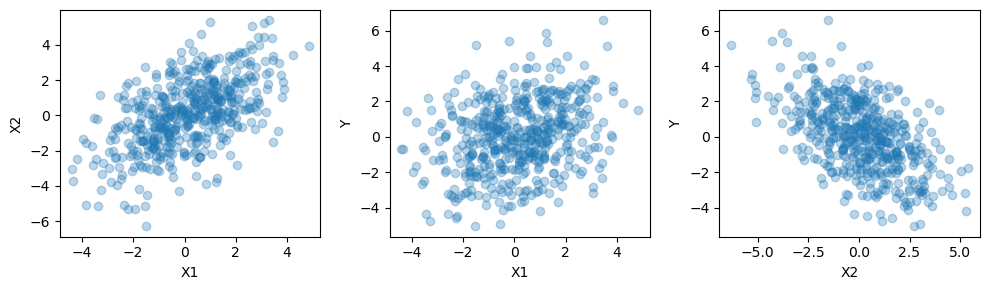

In [787]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].scatter(X[:,0], X[:,1], alpha=0.3)
axes[0].set(xlabel="X1", ylabel="X2")
axes[1].scatter(X[:,0], y, alpha=0.3)
axes[1].set(xlabel="X1", ylabel="Y")
axes[2].scatter(X[:,1], y, alpha=0.3)
axes[2].set(xlabel="X2", ylabel="Y")
#plt.suptitle("Sections of the distribution's sample")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


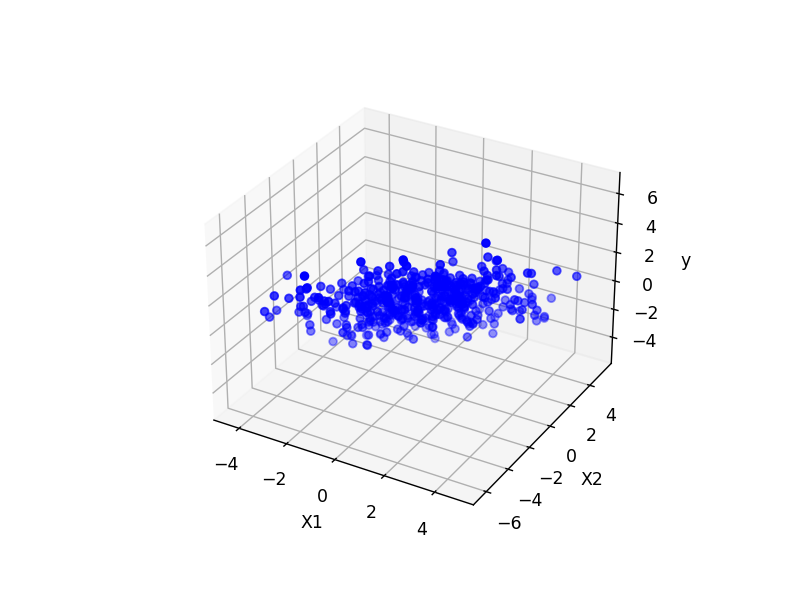

In [800]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,0], X[:,1], y, c='b', marker='o', label='Data Points')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y')
plt.show()

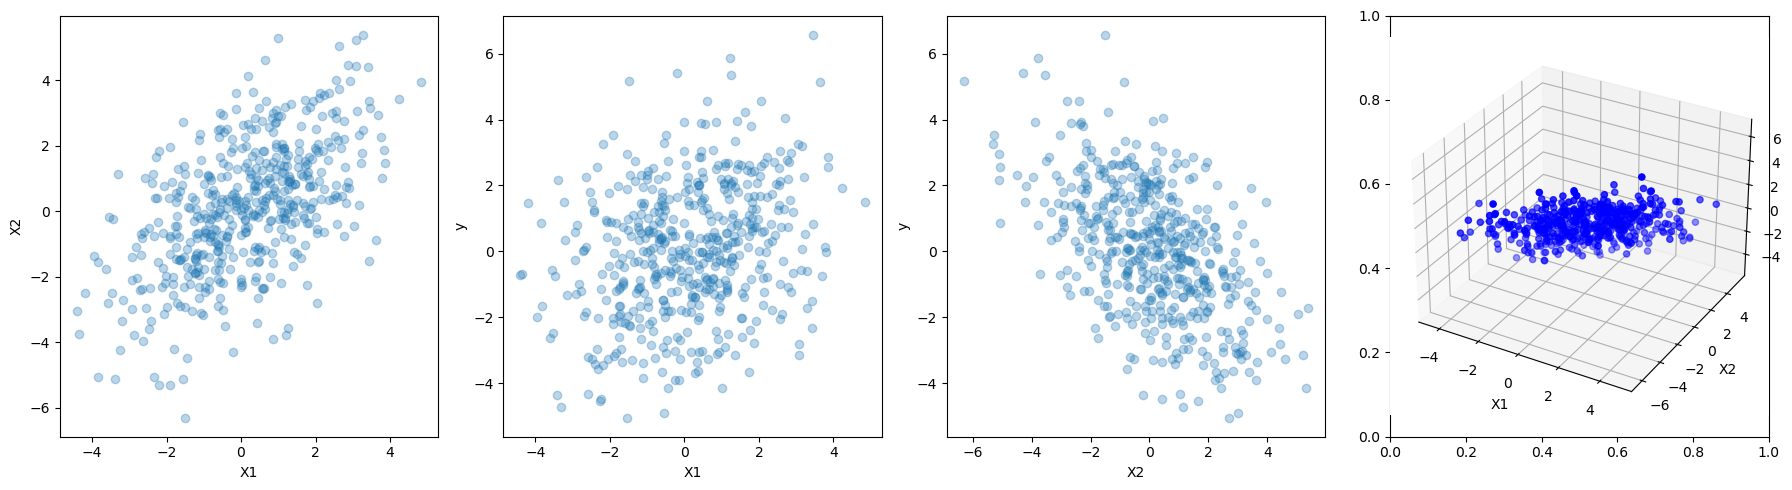

In [362]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# 2D scatter plots
axes[0].scatter(X[:, 0], X[:, 1], alpha=0.3)
axes[0].set(xlabel="X1", ylabel="X2")

axes[1].scatter(X[:, 0], y, alpha=0.3)
axes[1].set(xlabel="X1", ylabel="y")

axes[2].scatter(X[:, 1], y, alpha=0.3)
axes[2].set(xlabel="X2", ylabel="y")

# 3D scatter plot
ax = fig.add_subplot(1, 4, 4, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y, c='b', marker='o', label='Data Points')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y')

# Adjust layout for the combined grid
plt.tight_layout()

# Show the combined grid
plt.show()

#### Split into train and test

In [756]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fpqr_li = fpqr.FPQRegression(quantile=0.99, n_components=1, metric='li')
fpqr_li.fit(X_train, y_train)

#### Plot predictions

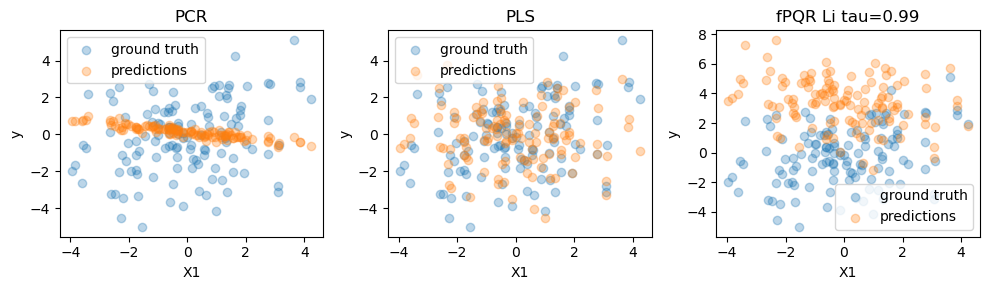

In [757]:
fig1, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(X_test[:,0], pcr.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="X1", ylabel="y", title="PCR")
axes[0].legend()
axes[1].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(X_test[:,0], pls.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="X1", ylabel="y", title="PLS")
axes[1].legend()
axes[2].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[2].scatter(X_test[:,0], fpqr_li.predict(X_test), alpha=0.3, label="predictions")
axes[2].set(xlabel="X1", ylabel="y", title="fPQR Li tau=0.99")
axes[2].legend()
plt.tight_layout()
plt.show()

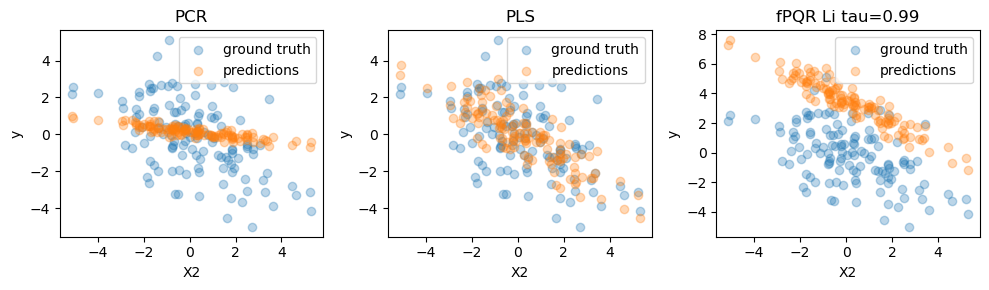

In [758]:
fig2, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(X_test[:,1], pcr.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="X2", ylabel="y", title="PCR")
axes[0].legend()
axes[1].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(X_test[:,1], pls.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="X2", ylabel="y", title="PLS")
axes[1].legend()
axes[2].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[2].scatter(X_test[:,1], fpqr_li.predict(X_test), alpha=0.3, label="predictions")
axes[2].set(xlabel="X2", ylabel="y", title="fPQR Li tau=0.99")
axes[2].legend()
plt.tight_layout()
plt.show()

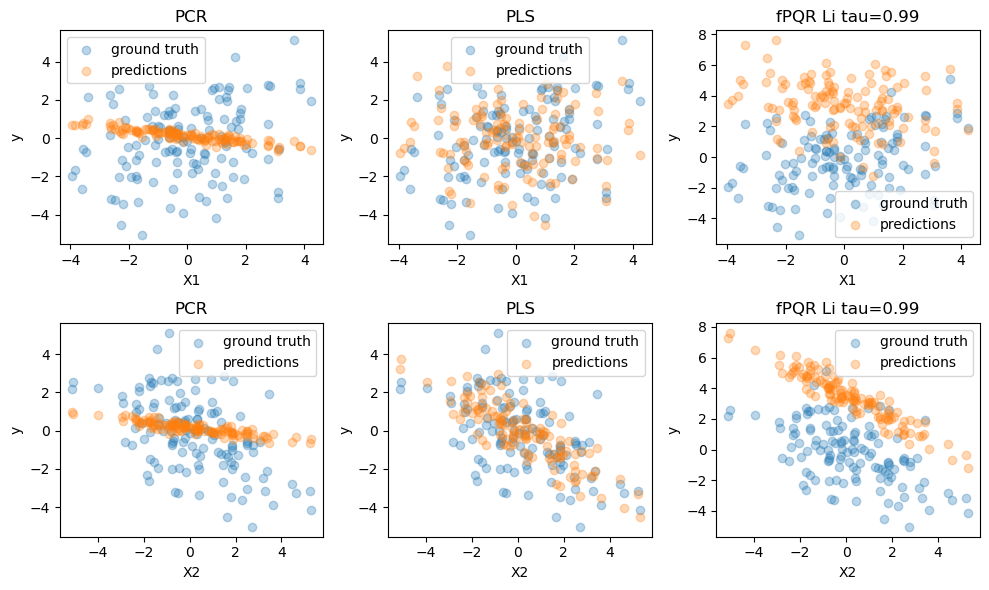

In [765]:
# Create subplots for the 2 by 3 layout
fig3, axes = plt.subplots(2, 3, figsize=(10, 6))

# Define titles for each subplot
titles = ["PCR", "PLS", "fPQR Li tau=0.99"]

# Iterate through rows and columns of the subplot layout
for i in range(2):
    for j in range(3):
        # Determine the index for the current subplot
        index = i * 3 + j
        
        # Scatter plot for X1 (first row) and X2 (second row)
        x_values = X_test[:, 0] if i == 0 else X_test[:, 1]
        
        # Plot ground truth and predictions
        axes[i, j].scatter(x_values, y_test, alpha=0.3, label="ground truth")
        axes[i, j].scatter(x_values, pcr.predict(X_test) if j == 0 else (pls.predict(X_test) if j == 1 else fpqr_li.predict(X_test)), alpha=0.3, label="predictions")
        
        # Set labels, titles, and legends
        axes[i, j].set(xlabel="X1" if i == 0 else "X2", ylabel="y", title=titles[j])
        axes[i, j].legend()

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

PCR no predice bien. El plano del que se toman estas secciones no debe de estar ajustándose bien a la estructura de correlación. PLSR sí, regresando a la media (porque estima coeficientes de regresión por least squares) y fPQR también pero estimando su cuantil.

In [ ]:
tau=0.5
fpqr_li_bis = fpqr.FPQRegression(quantile=tau, n_components=1, metric='li')
fpqr_li_bis.fit(X_train, y_train)

In [789]:
predictions_pcr = pcr.predict(X_test)
predictions_pls = pls.predict(X_test)
predictions_fpqr_li = fpqr_li.predict(X_test)
predictions_fpqr_li_bis = fpqr_li_bis.predict(X_test)

print("PCR:", mean_squared_error(y_test, predictions_pcr))
print("PLS:", mean_squared_error(y_test, predictions_pls))
print("fPQR Li 0.99:", mean_squared_error(y_test, predictions_fpqr_li))
print("fPQR Li 0.5:", mean_squared_error(y_test, predictions_fpqr_li_bis))

PCR: 3.8938141670027
PLS: 1.3046600348179624
fPQR Li 0.99: 14.6056788501817
fPQR Li 0.5: 1.971840032110323


Se ve que PLS estima mejor y eso coherente con la correlación de los datos. También podemos estimar el error cuantílico de fPQR.

In [791]:
print("PCR", _quantile_function(y_test,predictions_pcr,0.99))
print("PLS:", _quantile_function(y_test,predictions_pls,0.99))
print("fPQR Li:", _quantile_function(y_test,predictions_fpqr_li,0.99))
print("fPQR Li 0.5:", _quantile_function(y_test, predictions_fpqr_li_bis,0.99))

PCR 0.6342865940796265
PLS: 0.40109793318395454
fPQR Li: 0.03690345060998866
fPQR Li 0.5: 0.43354808286167973


Claramente, la que mejor predice es fPQR cuando el error es asociado al cuantil $\tau$. Veamos con el cuantil $\tau=0.5$.

In [793]:
tau=0.5

print("PCR:", _quantile_function(y_test,predictions_pcr,tau))
print("PLS:", _quantile_function(y_test,predictions_pls,tau))
print("fPQR Li 0.99:", _quantile_function(y_test, predictions_fpqr_li,tau))
print("fPQR Li 0.5:", _quantile_function(y_test,predictions_fpqr_li_bis,tau))

PCR: 0.7943156585681362
PLS: 0.4468480873419028
fPQR Li 0.99: 1.7874211214920859
fPQR Li 0.5: 0.5463409941539334


Pero las predicciones no se ajustan a una línea porque estamos proyectando una sección de un dibujo tridimensional. Las predicciones se ajustan a un plano, y los ejes de las gráficas deberían ser $X_1$, $X_2$ e $Y$.

In [369]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

<IPython.core.display.Javascript object>


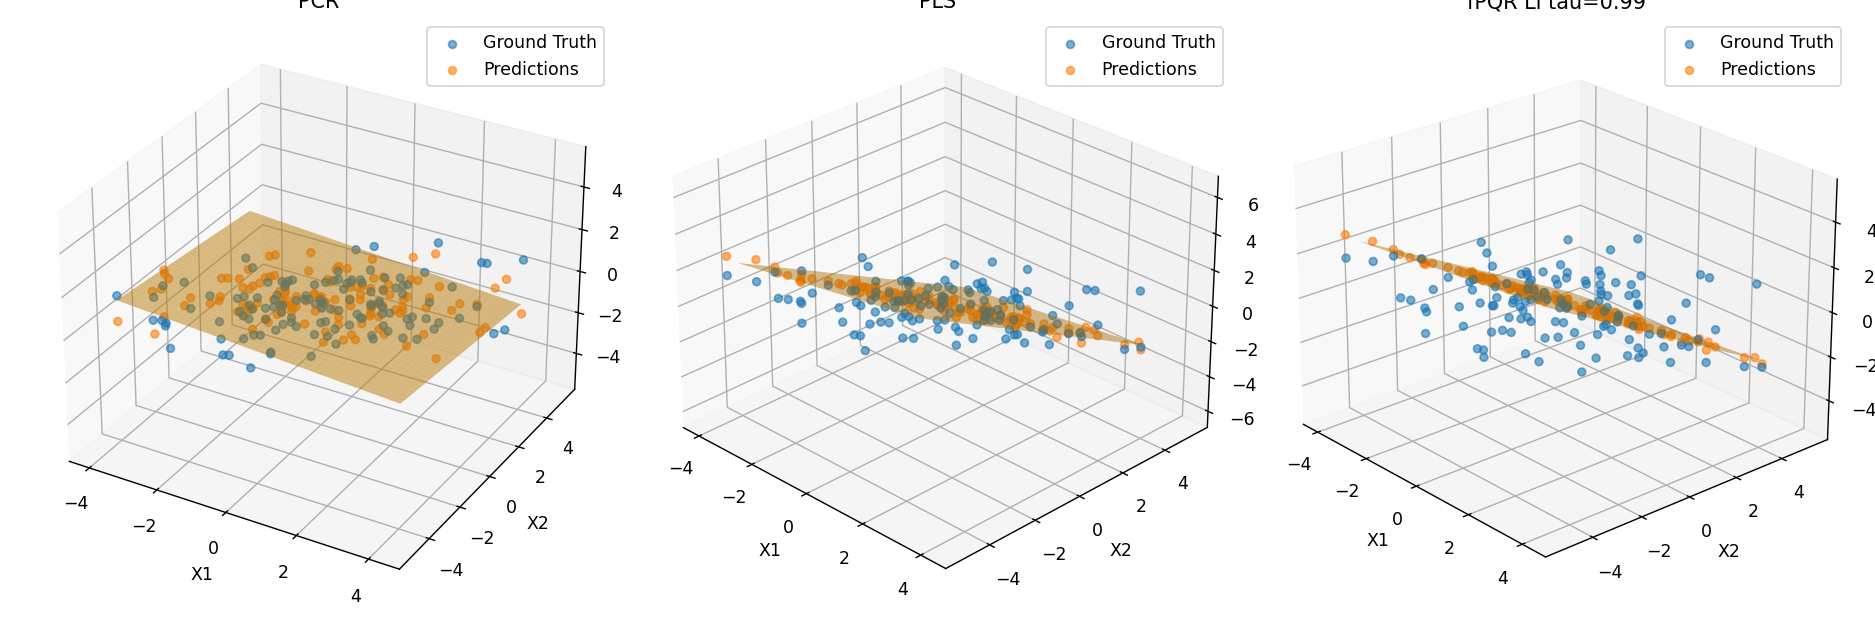

In [802]:
# Ensure X_test is a 2D array with two columns
X_test = X_test.reshape(-1, 2)

x_mesh, y_mesh = np.meshgrid(np.linspace(-4, 4, 80), np.linspace(-4, 4, 80))
z_mesh_pcr = pcr.predict(np.c_[x_mesh.ravel(), y_mesh.ravel()]).reshape(x_mesh.shape)
z_mesh_pls = pls.predict(np.c_[x_mesh.ravel(), y_mesh.ravel()]).reshape(x_mesh.shape)
z_mesh_fpqr_li = fpqr_li_bis.predict(np.c_[x_mesh.ravel(), y_mesh.ravel()]).reshape(x_mesh.shape)

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})

# Scatter plot for PCR
axes[0].scatter(X_test[:, 0], X_test[:, 1], y_test, alpha=0.6, label="Ground Truth")
axes[0].scatter(X_test[:, 0], X_test[:, 1], pcr.predict(X_test), alpha=0.6, label="Predictions")
axes[0].plot_surface(x_mesh, y_mesh, z_mesh_pcr, alpha=0.5, color='orange')
axes[0].set(xlabel="X1", ylabel="X2", zlabel="Y", title="PCR")
axes[0].legend()

# Scatter plot for PLS
axes[1].scatter(X_test[:, 0], X_test[:, 1], y_test, alpha=0.6, label="Ground Truth")
axes[1].scatter(X_test[:, 0], X_test[:, 1], pls.predict(X_test), alpha=0.6, label="Predictions")
axes[1].plot_surface(x_mesh, y_mesh, z_mesh_pls, alpha=0.5, color='orange')
axes[1].set(xlabel="X1", ylabel="X2", zlabel="Y", title="PLS")
axes[1].legend()

# Scatter plot for FPQR
axes[2].scatter(X_test[:, 0], X_test[:, 1], y_test, alpha=0.6, label="Ground Truth")
axes[2].scatter(X_test[:, 0], X_test[:, 1], fpqr_li_bis.predict(X_test), alpha=0.6, label="Predictions")
axes[2].plot_surface(x_mesh, y_mesh, z_mesh_fpqr_li, alpha=0.5, color='orange')
axes[2].set(xlabel="X1", ylabel="X2", zlabel="Y", title="fPQR Li tau=0.99")
axes[2].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

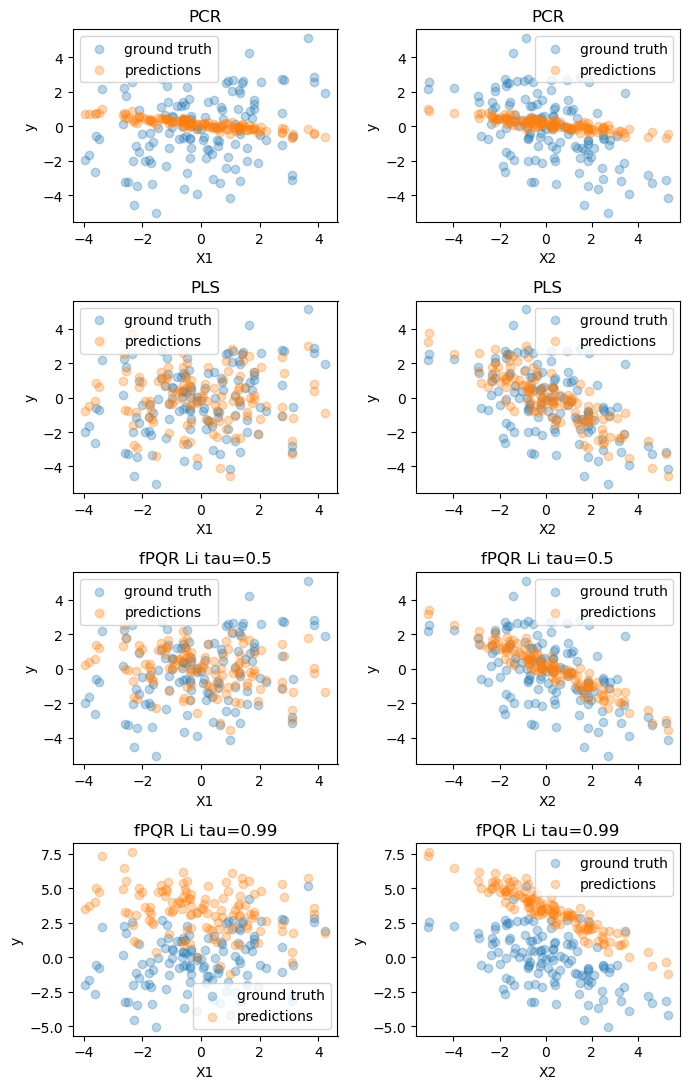

In [784]:
fig4, axes = plt.subplots(4, 2, figsize=(7, 11))
axes[0,0].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[0,0].scatter(X_test[:,0], pcr.predict(X_test), alpha=0.3, label="predictions")
axes[0,0].set(xlabel="X1", ylabel="y", title="PCR")
axes[0,0].legend()

axes[0,1].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[0,1].scatter(X_test[:,1], pcr.predict(X_test), alpha=0.3, label="predictions")
axes[0,1].set(xlabel="X2", ylabel="y", title="PCR")
axes[0,1].legend()

axes[1,0].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[1,0].scatter(X_test[:,0], pls.predict(X_test), alpha=0.3, label="predictions")
axes[1,0].set(xlabel="X1", ylabel="y", title="PLS")
axes[1,0].legend()

axes[1,1].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[1,1].scatter(X_test[:,1], pls.predict(X_test), alpha=0.3, label="predictions")
axes[1,1].set(xlabel="X2", ylabel="y", title="PLS")
axes[1,1].legend()

axes[2,0].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[2,0].scatter(X_test[:,0], fpqr_li_bis.predict(X_test), alpha=0.3, label="predictions")
axes[2,0].set(xlabel="X1", ylabel="y", title="fPQR Li tau=0.5")
axes[2,0].legend()

axes[2,1].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[2,1].scatter(X_test[:,1], fpqr_li_bis.predict(X_test), alpha=0.3, label="predictions")
axes[2,1].set(xlabel="X2", ylabel="y", title="fPQR Li tau=0.5")
axes[2,1].legend()

axes[3,0].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[3,0].scatter(X_test[:,0], fpqr_li.predict(X_test), alpha=0.3, label="predictions")
axes[3,0].set(xlabel="X1", ylabel="y", title="fPQR Li tau=0.99")
axes[3,0].legend()

axes[3,1].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[3,1].scatter(X_test[:,1], fpqr_li.predict(X_test), alpha=0.3, label="predictions")
axes[3,1].set(xlabel="X2", ylabel="y", title="fPQR Li tau=0.99")
axes[3,1].legend()

plt.tight_layout()
plt.show()

#### If we use the maximum number of components

In [371]:
pcr_2 = make_pipeline(StandardScaler(), PCA(n_components=2), LinearRegression())
pcr_2.fit(X_train, y_train)
pca_2 = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls_2 = PLSRegression(n_components=2)
pls_2.fit(X_train, y_train)

fpqr_li_2 = fpqr.FPQRegression(quantile=0.99, n_components=2, metric='li')
fpqr_li_2.fit(X_train, y_train)

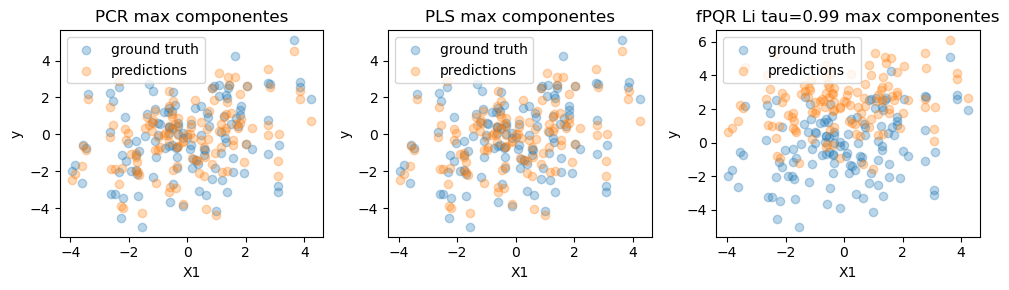

In [372]:
fig1, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(X_test[:,0], pcr_2.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="X1", ylabel="y", title="PCR max componentes")
axes[0].legend()
axes[1].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(X_test[:,0], pls_2.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="X1", ylabel="y", title="PLS max componentes")
axes[1].legend()
axes[2].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[2].scatter(X_test[:,0], fpqr_li_2.predict(X_test), alpha=0.3, label="predictions")
axes[2].set(xlabel="X1", ylabel="y", title="fPQR Li tau=0.99 max componentes")
axes[2].legend()
plt.tight_layout()
plt.show()

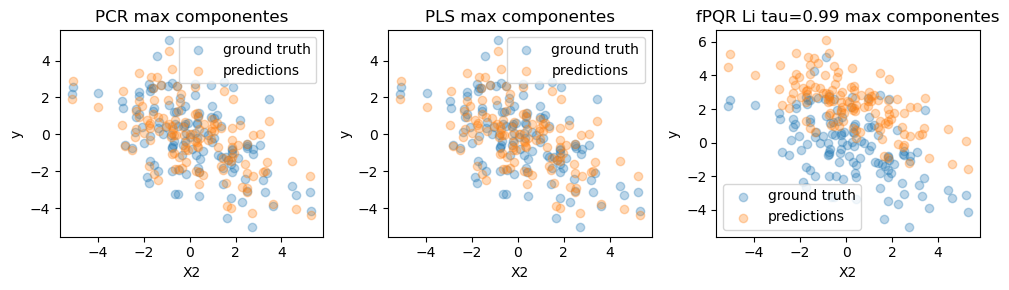

In [373]:
fig2, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(X_test[:,1], pcr_2.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="X2", ylabel="y", title="PCR max componentes")
axes[0].legend()
axes[1].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(X_test[:,1], pls_2.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="X2", ylabel="y", title="PLS max componentes")
axes[1].legend()
axes[2].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[2].scatter(X_test[:,1], fpqr_li_2.predict(X_test), alpha=0.3, label="predictions")
axes[2].set(xlabel="X2", ylabel="y", title="fPQR Li tau=0.99 max componentes")
axes[2].legend()
plt.tight_layout()
plt.show()

In [794]:
tau=0.5
fpqr_li_2_bis = fpqr.FPQRegression(quantile=tau, n_components=2, metric='li')
fpqr_li_2_bis.fit(X_train, y_train)

predictions_pcr_2 = pcr_2.predict(X_test)
predictions_pls_2 = pls_2.predict(X_test)
predictions_fpqr_li_2 = fpqr_li_2.predict(X_test)
predictions_fpqr_li_2_bis = fpqr_li_2_bis.predict(X_test)


print("MSE PCR:", mean_squared_error(y_test, predictions_pcr_2))
print("MSE PLS:", mean_squared_error(y_test, predictions_pls_2))
print("MSE fPQR Li 0.5:", mean_squared_error(y_test, predictions_fpqr_li_2_bis))
print("MSE fPQR Li 0.99:", mean_squared_error(y_test, predictions_fpqr_li_2))

print("QE 0.99 PCR", _quantile_function(y_test,predictions_pcr_2,0.99))
print("QE 0.99 PLS:", _quantile_function(y_test,predictions_pls_2,0.99))
print("QE 0.99 fPQR Li 0.5:", _quantile_function(y_test,predictions_fpqr_li_2_bis,0.99))
print("QE 0.99 fPQR Li 0.99:", _quantile_function(y_test,predictions_fpqr_li_2,0.99))

print("QE 0.5 PCR:", _quantile_function(y_test,predictions_pcr_2,tau))
print("QE 0.5 PLS:", _quantile_function(y_test,predictions_pls_2,tau))
print("QE 0.5 fPQR Li 0.5:", _quantile_function(y_test,predictions_fpqr_li_2_bis,tau))
print("QE 0.5 fPQR Li 0.99:", _quantile_function(y_test,predictions_fpqr_li_2,tau))

MSE PCR: 0.8663643906916536
MSE PLS: 0.8663643906916537
MSE fPQR Li 0.5: 0.8766664938415855
MSE fPQR Li 0.99: 7.024322551318678
QE 0.99 PCR 0.3782788123928429
QE 0.99 PLS: 0.37827881239284306
QE 0.99 fPQR Li 0.5: 0.3633605674808371
QE 0.99 fPQR Li 0.99: 0.026358444708786174
QE 0.5 PCR: 0.3787304479820943
QE 0.5 PLS: 0.3787304479820944
QE 0.5 fPQR Li 0.5: 0.3811351988750783
QE 0.5 fPQR Li 0.99: 1.2370534823881503


PCR and PLS are practically the same model, if not exactly

In [385]:
pca_2.components_

array([[-0.70710678, -0.70710678]])

#### Dataset in 4d to train models with different number of components

In [1021]:
cov_matrix = [[4, -2, 1], [-2, 4, 4], [1 ,4, 6]] # np.array([[2.0, 0.5], [0.5, 1.0]])
cov_matrix = np.tril(cov_matrix)  # Zero out the upper triangle
cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
min_eigenvalue = np.min(np.linalg.eigvals(cov_matrix))
if min_eigenvalue <= 0:
    diagonal_addition = np.eye(3) * (-min_eigenvalue + 1e-6)
    cov_matrix = cov_matrix + diagonal_addition
cov_matrix

array([[ 4.25714663, -2.        ,  1.        ],
       [-2.        ,  4.25714663,  4.        ],
       [ 1.        ,  4.        ,  6.25714663]])

In [1022]:
rng = np.random.RandomState(0)
n_samples = 500
cov = [[5, -2, 1], [-2, 5, 4], [1 ,4, 6]] #Positive definite matrix
X = rng.multivariate_normal(mean=[0, 0, 0], cov=cov, size=n_samples)
y = (X[:,0]-2*X[:,1]+X[:,2]) + rng.normal(scale=1,size=n_samples) 

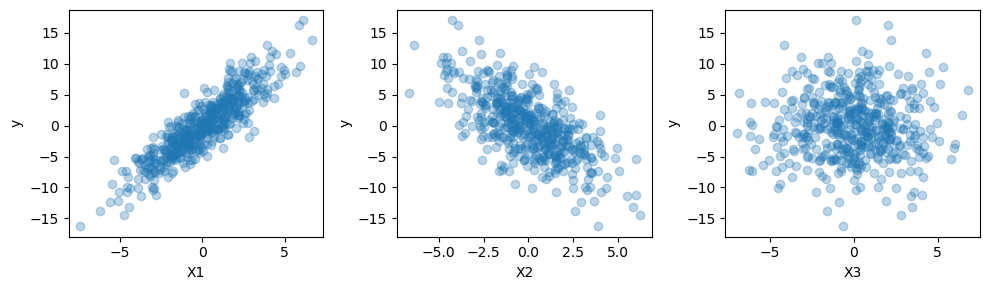

In [1023]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].scatter(X[:,0], y, alpha=0.3)
axes[0].set(xlabel="X1", ylabel="y")
axes[1].scatter(X[:,1], y, alpha=0.3)
axes[1].set(xlabel="X2", ylabel="y")
axes[2].scatter(X[:,2], y, alpha=0.3)
axes[2].set(xlabel="X3", ylabel="y")
plt.tight_layout()
plt.show()

There is correlation with the response

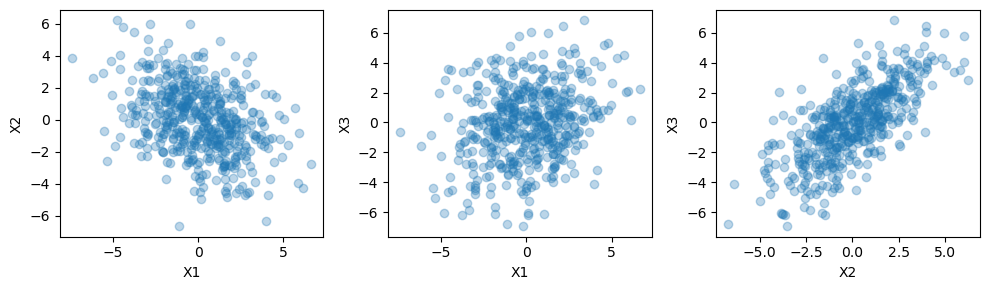

In [1024]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].scatter(X[:,0], X[:,1], alpha=0.3)
axes[0].set(xlabel="X1", ylabel="X2")
axes[1].scatter(X[:,0], X[:,2], alpha=0.3)
axes[1].set(xlabel="X1", ylabel="X3")
axes[2].scatter(X[:,1], X[:,2], alpha=0.3)
axes[2].set(xlabel="X2", ylabel="X3")
plt.tight_layout()
plt.show()

There is some correlation among regressors

#### Train models with 1 component

In [1025]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fpqr_li = fpqr.FPQRegression(quantile=0.99, n_components=1, metric='li')
fpqr_li.fit(X_train, y_train)

C:\Users\jorge\anaconda3\lib\site-packages\asgl\asgl.py:97: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(self.tol, np.float):


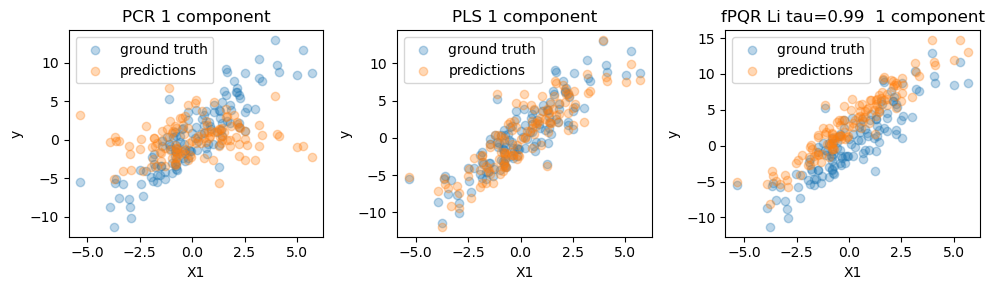

In [1045]:
fig1, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(X_test[:,0], pcr.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="X1", ylabel="y", title="PCR 1 component")
axes[0].legend()
axes[1].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(X_test[:,0], pls.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="X1", ylabel="y", title="PLS 1 component")
axes[1].legend()
axes[2].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[2].scatter(X_test[:,0], fpqr_li.predict(X_test), alpha=0.3, label="predictions")
axes[2].set(xlabel="X1", ylabel="y", title="fPQR Li tau=0.99  1 component")
axes[2].legend()
plt.tight_layout()
plt.show()

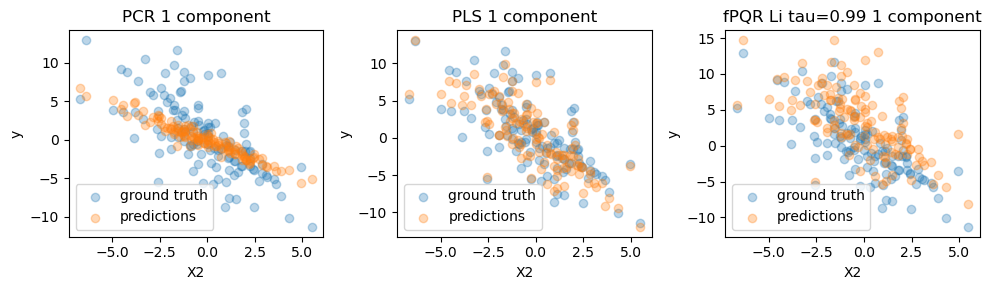

In [1046]:
fig1, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(X_test[:,1], pcr.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="X2", ylabel="y", title="PCR 1 component")
axes[0].legend()
axes[1].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(X_test[:,1], pls.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="X2", ylabel="y", title="PLS 1 component")
axes[1].legend()
axes[2].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[2].scatter(X_test[:,1], fpqr_li.predict(X_test), alpha=0.3, label="predictions")
axes[2].set(xlabel="X2", ylabel="y", title="fPQR Li tau=0.99 1 component")
axes[2].legend()
plt.tight_layout()
plt.show()

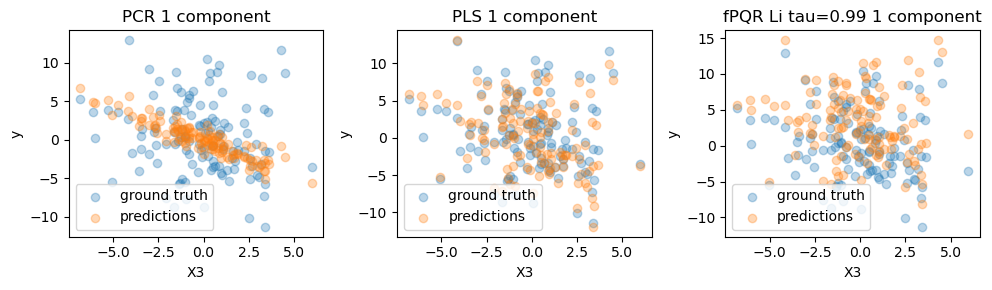

In [1047]:
fig1, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(X_test[:,2], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(X_test[:,2], pcr.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="X3", ylabel="y", title="PCR 1 component")
axes[0].legend()
axes[1].scatter(X_test[:,2], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(X_test[:,2], pls.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="X3", ylabel="y", title="PLS 1 component")
axes[1].legend()
axes[2].scatter(X_test[:,2], y_test, alpha=0.3, label="ground truth")
axes[2].scatter(X_test[:,2], fpqr_li.predict(X_test), alpha=0.3, label="predictions")
axes[2].set(xlabel="X3", ylabel="y", title="fPQR Li tau=0.99 1 component")
axes[2].legend()
plt.tight_layout()
plt.show()

In [1042]:
tau=0.5
fpqr_li_bis = fpqr.FPQRegression(quantile=tau, n_components=1, metric='li')
fpqr_li_bis.fit(X_train, y_train)

predictions_pcr = pcr.predict(X_test)
predictions_pls = pls.predict(X_test)
predictions_fpqr_li = fpqr_li.predict(X_test)
predictions_fpqr_li_bis = fpqr_li_bis.predict(X_test)


print("MSE PCR 1 comp:", mean_squared_error(y_test, predictions_pcr))
print("MSE PLS 1 comp:", mean_squared_error(y_test, predictions_pls))
print("MSE fPQR Li 0.99 1 comp:", mean_squared_error(y_test, predictions_fpqr_li))

print("QE 0.99 PCR 1 comp:", _quantile_function(y_test,predictions_pcr,0.99))
print("QE 0.99 PLS 1 comp:", _quantile_function(y_test,predictions_pls,0.99))
print("QE 0.99 fPQR Li 0.99 1 comp:", _quantile_function(y_test,predictions_fpqr_li,0.99))

print("QE 0.5 PCR 1 comp:", _quantile_function(y_test,predictions_pcr,tau))
print("QE 0.5 PLS 1 comp:", _quantile_function(y_test,predictions_pls,tau))
print("QE 0.5 fPQR Li 0.5 1 comp:", _quantile_function(y_test,predictions_fpqr_li_bis,tau))

MSE PCR 1 comp: 16.47166849086829
MSE PLS 1 comp: 1.8752956148466537
MSE fPQR Li 0.99 1 comp: 8.8462662729864
QE 0.99 PCR 1 comp: 1.7605224695233543
QE 0.99 PLS 1 comp: 0.6052454415962162
QE 0.99 fPQR Li 0.99 1 comp: 0.027194929100525976
QE 0.5 PCR 1 comp: 1.557990488311081
QE 0.5 PLS 1 comp: 0.5431620478412077
QE 0.5 fPQR Li 0.5 1 comp: 0.52154487567266


C:\Users\jorge\anaconda3\lib\site-packages\asgl\asgl.py:97: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(self.tol, np.float):


PLS clearly outperforms PCR

#### Train model with 2 components

In [1029]:
pcr_2 = make_pipeline(StandardScaler(), PCA(n_components=2), LinearRegression())
pcr_2.fit(X_train, y_train)
pca_2 = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls_2 = PLSRegression(n_components=2)
pls_2.fit(X_train, y_train)

fpqr_li_2 = fpqr.FPQRegression(quantile=0.99, n_components=2, metric='li')
fpqr_li_2.fit(X_train, y_train)

C:\Users\jorge\anaconda3\lib\site-packages\asgl\asgl.py:97: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(self.tol, np.float):


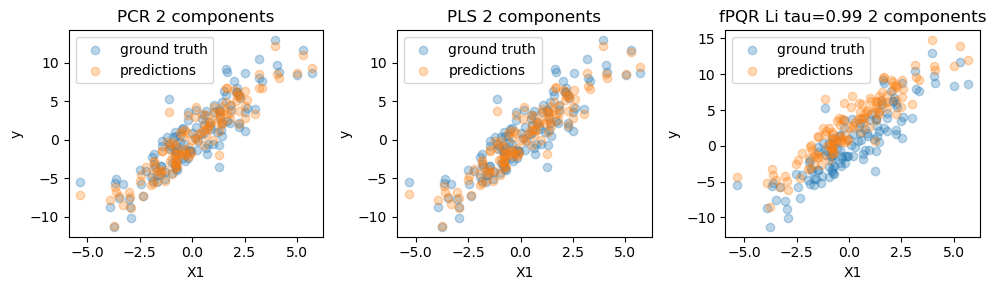

In [1048]:
fig1, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(X_test[:,0], pcr_2.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="X1", ylabel="y", title="PCR 2 components")
axes[0].legend()
axes[1].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(X_test[:,0], pls_2.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="X1", ylabel="y", title="PLS 2 components")
axes[1].legend()
axes[2].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[2].scatter(X_test[:,0], fpqr_li_2.predict(X_test), alpha=0.3, label="predictions")
axes[2].set(xlabel="X1", ylabel="y", title="fPQR Li tau=0.99 2 components")
axes[2].legend()
plt.tight_layout()
plt.show()

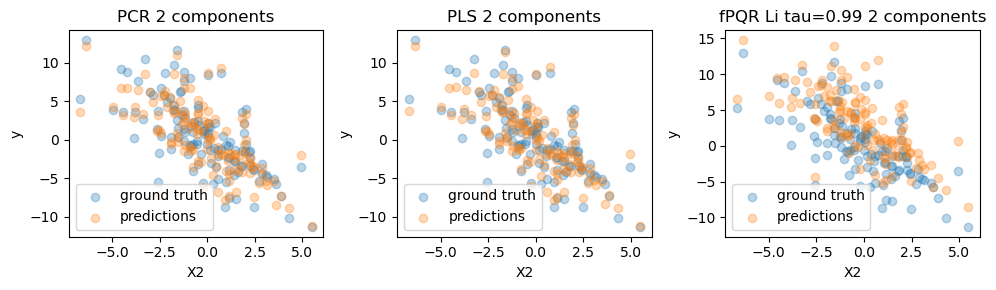

In [1049]:
fig1, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(X_test[:,1], pcr_2.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="X2", ylabel="y", title="PCR 2 components")
axes[0].legend()
axes[1].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(X_test[:,1], pls_2.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="X2", ylabel="y", title="PLS 2 components")
axes[1].legend()
axes[2].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[2].scatter(X_test[:,1], fpqr_li_2.predict(X_test), alpha=0.3, label="predictions")
axes[2].set(xlabel="X2", ylabel="y", title="fPQR Li tau=0.99 2 components")
axes[2].legend()
plt.tight_layout()
plt.show()

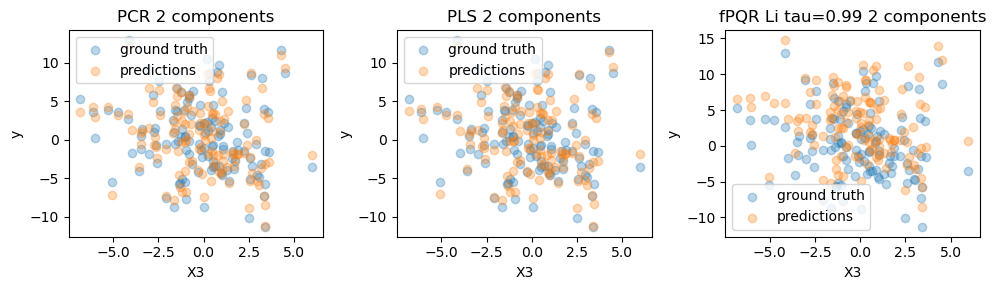

In [1050]:
fig1, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(X_test[:,2], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(X_test[:,2], pcr_2.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="X3", ylabel="y", title="PCR 2 components")
axes[0].legend()
axes[1].scatter(X_test[:,2], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(X_test[:,2], pls_2.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="X3", ylabel="y", title="PLS 2 components")
axes[1].legend()
axes[2].scatter(X_test[:,2], y_test, alpha=0.3, label="ground truth")
axes[2].scatter(X_test[:,2], fpqr_li_2.predict(X_test), alpha=0.3, label="predictions")
axes[2].set(xlabel="X3", ylabel="y", title="fPQR Li tau=0.99 2 components")
axes[2].legend()
plt.tight_layout()
plt.show()

In [1039]:
tau=0.5
fpqr_li_2_bis = fpqr.FPQRegression(quantile=tau, n_components=2, metric='li')
fpqr_li_2_bis.fit(X_train, y_train)

predictions_pcr_2 = pcr_2.predict(X_test)
predictions_pls_2 = pls_2.predict(X_test)
predictions_fpqr_li_2 = fpqr_li_2.predict(X_test)
predictions_fpqr_li_2_bis = fpqr_li_2_bis.predict(X_test)


print("MSE PCR 2 comps:", mean_squared_error(y_test, predictions_pcr_2))
print("MSE PLS 2 comps:", mean_squared_error(y_test, predictions_pls_2))
print("MSE fPQR Li 0.99 2 comps:", mean_squared_error(y_test, predictions_fpqr_li_2))

print("QE 0.99 PCR 2 comps", _quantile_function(y_test,predictions_pcr_2,0.99))
print("QE 0.99 PLS 2 comps:", _quantile_function(y_test,predictions_pls_2,0.99))
print("QE 0.99 fPQR Li 0.99 2 comps:", _quantile_function(y_test,predictions_fpqr_li_2,0.99))

print("QE 0.5 PCR 2 comps:", _quantile_function(y_test,predictions_pcr_2,tau))
print("QE 0.5 PLS 2 comps:", _quantile_function(y_test,predictions_pls_2,tau))
print("QE 0.5 fPQR Li 0.5 2 comps:", _quantile_function(y_test,predictions_fpqr_li_2_bis,tau))

MSE PCR: 1.4963163611315053
MSE PLS: 1.3737363198615253
MSE fPQR Li 0.99: 7.587072268965894
QE 0.99 PCR 0.5727218399927396
QE 0.99 PLS: 0.5485932321203677
QE 0.99 fPQR Li 0.99: 0.025009069657429252
QE 0.5 PCR: 0.49220475665082913
QE 0.5 PLS: 0.47124411731330323
QE 0.5 fPQR Li 0.5: 0.49327091151426755


C:\Users\jorge\anaconda3\lib\site-packages\asgl\asgl.py:97: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(self.tol, np.float):


Error in PLS is better than in PCR

#### Train model with 3 components

In [1033]:
pcr_3 = make_pipeline(StandardScaler(), PCA(n_components=3), LinearRegression())
pcr_3.fit(X_train, y_train)
pca_3 = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls_3 = PLSRegression(n_components=3)
pls_3.fit(X_train, y_train)

fpqr_li_3 = fpqr.FPQRegression(quantile=0.99, n_components=3, metric='li')
fpqr_li_3.fit(X_train, y_train)

C:\Users\jorge\anaconda3\lib\site-packages\asgl\asgl.py:97: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(self.tol, np.float):


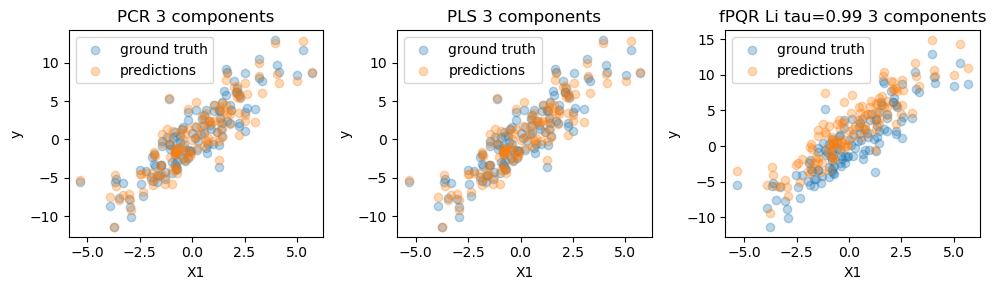

In [1051]:
fig1, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(X_test[:,0], pcr_3.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="X1", ylabel="y", title="PCR 3 components")
axes[0].legend()
axes[1].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(X_test[:,0], pls_3.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="X1", ylabel="y", title="PLS 3 components")
axes[1].legend()
axes[2].scatter(X_test[:,0], y_test, alpha=0.3, label="ground truth")
axes[2].scatter(X_test[:,0], fpqr_li_3.predict(X_test), alpha=0.3, label="predictions")
axes[2].set(xlabel="X1", ylabel="y", title="fPQR Li tau=0.99 3 components")
axes[2].legend()
plt.tight_layout()
plt.show()

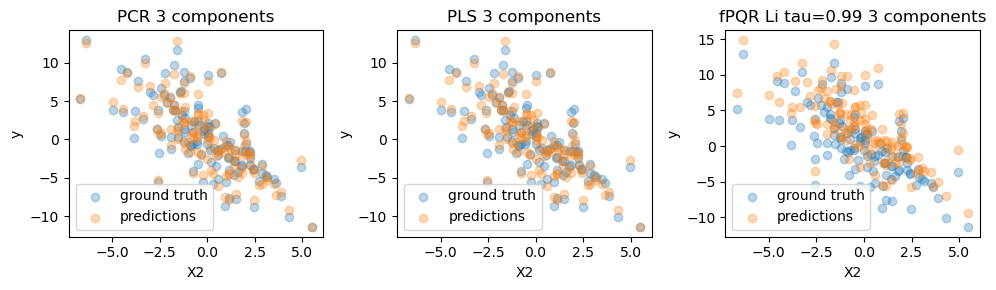

In [1052]:
fig1, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(X_test[:,1], pcr_3.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="X2", ylabel="y", title="PCR 3 components")
axes[0].legend()
axes[1].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(X_test[:,1], pls_3.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="X2", ylabel="y", title="PLS 3 components")
axes[1].legend()
axes[2].scatter(X_test[:,1], y_test, alpha=0.3, label="ground truth")
axes[2].scatter(X_test[:,1], fpqr_li_3.predict(X_test), alpha=0.3, label="predictions")
axes[2].set(xlabel="X2", ylabel="y", title="fPQR Li tau=0.99 3 components")
axes[2].legend()
plt.tight_layout()
plt.show()

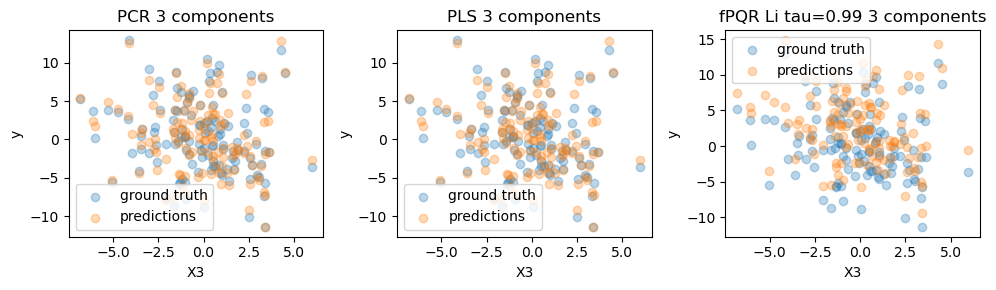

In [1053]:
fig1, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(X_test[:,2], y_test, alpha=0.3, label="ground truth")
axes[0].scatter(X_test[:,2], pcr_3.predict(X_test), alpha=0.3, label="predictions")
axes[0].set(xlabel="X3", ylabel="y", title="PCR 3 components")
axes[0].legend()
axes[1].scatter(X_test[:,2], y_test, alpha=0.3, label="ground truth")
axes[1].scatter(X_test[:,2], pls_3.predict(X_test), alpha=0.3, label="predictions")
axes[1].set(xlabel="X3", ylabel="y", title="PLS 3 components")
axes[1].legend()
axes[2].scatter(X_test[:,2], y_test, alpha=0.3, label="ground truth")
axes[2].scatter(X_test[:,2], fpqr_li_3.predict(X_test), alpha=0.3, label="predictions")
axes[2].set(xlabel="X3", ylabel="y", title="fPQR Li tau=0.99 3 components")
axes[2].legend()
plt.tight_layout()
plt.show()

In [1044]:
tau=0.5
fpqr_li_3_bis = fpqr.FPQRegression(quantile=tau, n_components=3, metric='li')
fpqr_li_3_bis.fit(X_train, y_train)

predictions_pcr_3 = pcr_3.predict(X_test)
predictions_pls_3 = pls_3.predict(X_test)
predictions_fpqr_li_3 = fpqr_li_3.predict(X_test)
predictions_fpqr_li_3_bis = fpqr_li_3_bis.predict(X_test)


print("MSE PCR 3 comps:", mean_squared_error(y_test, predictions_pcr_3))
print("MSE PLS 3 comps:", mean_squared_error(y_test, predictions_pls_3))
print("MSE fPQR Li 0.99 3 comps:", mean_squared_error(y_test, predictions_fpqr_li_3))

print("QE 0.99 PCR 3 comps:", _quantile_function(y_test,predictions_pcr_3,0.99))
print("QE 0.99 PLS 3 comps:", _quantile_function(y_test,predictions_pls_3,0.99))
print("QE 0.99 fPQR Li 0.99 3 comps:", _quantile_function(y_test,predictions_fpqr_li_3,0.99))

print("QE 0.5 PCR 3 comps:", _quantile_function(y_test,predictions_pcr_3,tau))
print("QE 0.5 PLS 3 comps:", _quantile_function(y_test,predictions_pls_3,tau))
print("QE 0.5 fPQR Li 0.5 3 comps:", _quantile_function(y_test,predictions_fpqr_li_3_bis,tau))

MSE PCR 3 comps: 1.0468511985159608
MSE PLS 3 comps: 1.0468511985159599
MSE fPQR Li 0.99 3 comps: 5.3595909078732324
QE 0.99 PCR 3 comps: 0.45587826030517326
QE 0.99 PLS 3 comps: 0.45587826030517264
QE 0.99 fPQR Li 0.99 3 comps: 0.02365762760040789
QE 0.5 PCR 3 comps: 0.4113082680784636
QE 0.5 PLS 3 comps: 0.4113082680784633
QE 0.5 fPQR Li 0.5 3 comps: 0.41115694449370205


C:\Users\jorge\anaconda3\lib\site-packages\asgl\asgl.py:97: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(self.tol, np.float):


Error in PCR and PLS is almost the same

## Geometric interpertation of the loadings and scores

Lets's work with the 2 dimensional $X$ data and 1 dimensional response $y$ and with models with 2 components

In [293]:
rng = np.random.RandomState(0)
n_samples = 500
cov = [[3, 2], [2, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)
y = (X[:,0]-X[:,1]) + rng.normal(scale=1,size=n_samples)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

In [1122]:
pcr_2 = make_pipeline(StandardScaler(), PCA(n_components=2), LinearRegression())
pcr_2.fit(X_train, y_train)
pca_2 = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls_2 = PLSRegression(n_components=2)
pls_2.fit(X_train, y_train)

fpqr_li_2 = fpqr.FPQRegression(quantile=0.99, n_components=2, metric='li')
fpqr_li_2.fit(X_train, y_train)

C:\Users\jorge\anaconda3\lib\site-packages\asgl\asgl.py:97: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(self.tol, np.float):


### PCA

For PCA we are going to work on a dataset X of two columns to visualize the orthogonality of the Principal components. This image goes in the section of PCA (page 5) befores any model.

In [295]:
pca = PCA(n_components=2).fit(X)
T = pca.transform(X) # ES ESTO???? (No lo sé, lo he supuesto)
P = pca.components_.T
var = pca.explained_variance_

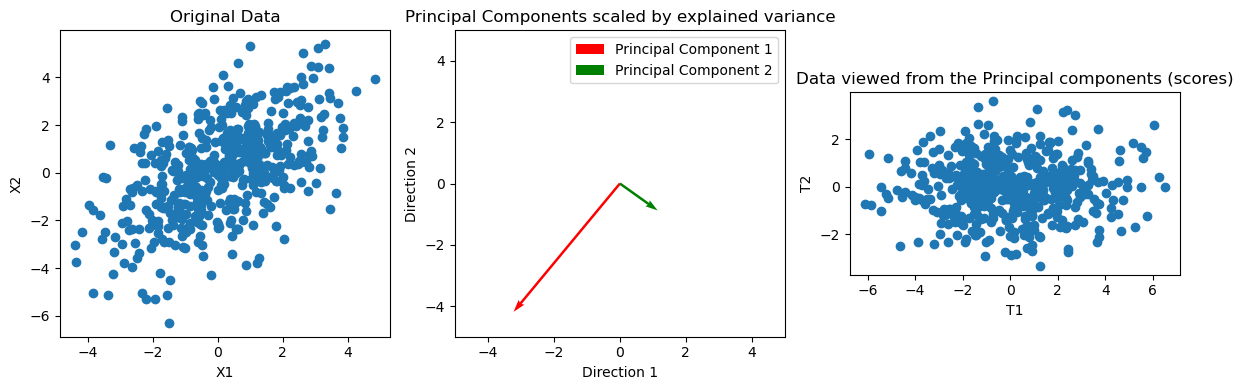

In [1120]:
# Create a multi-panel plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Scatter plot of the original data
ax1.scatter(X[:, 0], X[:, 1])
ax1.set_title('Original Data')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')

# Plot the directions represented by P
ax2.quiver(0, 0, P[0, 0]*var[0], P[1, 0]*var[0], angles='xy', scale_units='xy', scale=1, color='r', label='Principal Component 1')
ax2.quiver(0, 0, P[0, 1]*var[1], P[1, 1]*var[1], angles='xy', scale_units='xy', scale=1, color='g', label='Principal Component 2')
ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)
ax2.set_title('Principal Components scaled by explained variance')
ax2.set_xlabel('Direction 1')
ax2.set_ylabel('Direction 2')
ax2.legend()

# Scatter plot of the projections T over P
ax3.scatter(T[:, 0], T[:, 1])
ax3.set_title('Projections of Data onto Principal Components')
ax3.set_xlabel('Projection onto PC 1')
ax3.set_ylabel('Projection onto PC 2')

plt.gca().set(
    aspect="equal",
    title="Data viewed from the Principal components (scores)",
    xlabel="T1",
    ylabel="T2",
)

plt.tight_layout()
plt.show()

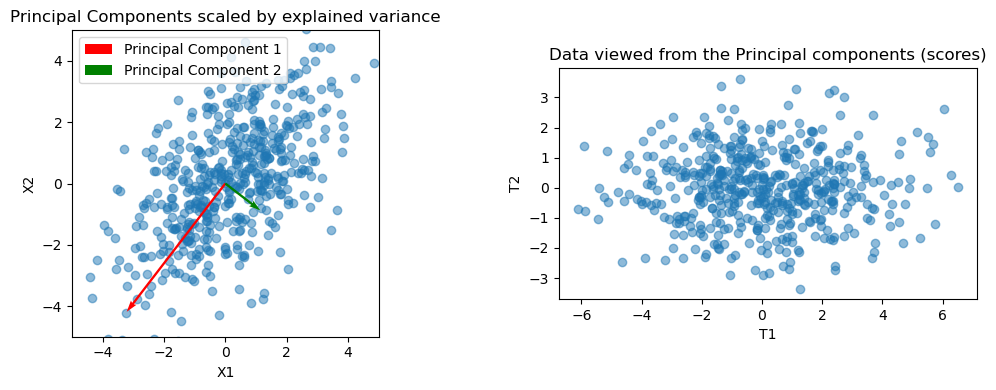

In [313]:
import matplotlib.gridspec as gridspec
# Create a multi-panel plot with different width ratios
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

# Create subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# Scatter plot of the original data
ax1.scatter(X[:, 0], X[:, 1], alpha=0.5)

# Plot the directions represented by P
ax1.quiver(0, 0, P[0, 0]*var[0], P[1, 0]*var[0], angles='xy', scale_units='xy', scale=1, color='r', label='Principal Component 1', linewidth=4)
ax1.quiver(0, 0, P[0, 1]*var[1], P[1, 1]*var[1], angles='xy', scale_units='xy', scale=1, color='g', label='Principal Component 2', linewidth=4)
ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)
ax1.legend()
ax1.set_aspect('equal')
ax1.set_title("Principal Components scaled by explained variance")
ax1.set_xlabel("X1")
ax1.set_ylabel("X2")

# Scatter plot of the projections T over P
ax2.scatter(T[:, 0], T[:, 1], alpha=0.5)
ax2.set_title('Projections of Data onto Principal Components')
ax2.set_xlabel('Projection onto PC 1')
ax2.set_ylabel('Projection onto PC 2')
ax2.set_aspect('equal')
ax2.set_title("Data viewed from the Principal components (scores)")
ax2.set_xlabel("T1")
ax2.set_ylabel("T2")

# Adjust the width ratio of the subplots
plt.tight_layout(w_pad=-0.5)

plt.show()

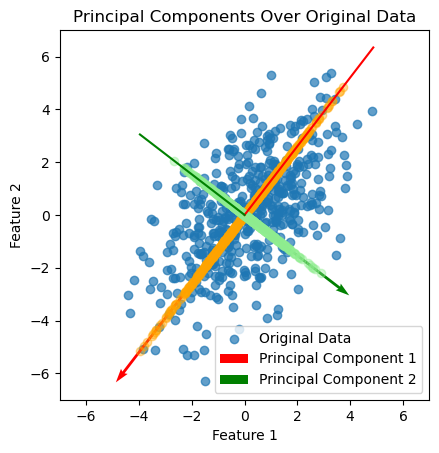

In [1114]:
k=8
var = pca.explained_variance_

# Create a scatter plot of the original data
plt.scatter(X[:, 0], X[:, 1], alpha = 0.7, label='Original Data')

# Plot the principal components over the scatter plot
plt.quiver(0, 0, k*P[0, 0], k*P[1, 0], angles='xy', scale_units='xy', scale=1, color='r', label='Principal Component 1')
plt.plot([0, -k*P[0, 0]], [0, -k*P[1, 0]], color='r')
#plt.plot([0, var[0]*P[0, 0]], [0, var[0]*P[1, 0]], color='r', linewidth=5, alpha = 0.7)
plt.quiver(0, 0, 5*P[0, 1], 5*P[1, 1], angles='xy', scale_units='xy', scale=1, color='g', label='Principal Component 2')
plt.plot([0, -5*P[0, 1]], [0, -5*P[1, 1]], color='g')
#plt.plot([0, var[1]*P[0, 1]], [0, var[1]*P[1, 1]], color='g', linewidth=5, alpha = 0.7)

# Plot the projected scatter over the ppal components
projection_1 = np.column_stack((T[:,0]*P[0,0], T[:,0]*P[1,0]))
projection_2 = np.column_stack((T[:,1]*P[0,1], T[:,1]*P[1,1]))
plt.scatter(projection_1[:, 0], projection_1[:, 1], color='orange', alpha=0.4)
plt.scatter(projection_2[:, 0], projection_2[:, 1], color='lightgreen', alpha=0.4)

plt.gca().set(
    aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel="first feature",
    ylabel="second feature",
)

# Set limits
plt.xlim(-7, 7)
plt.ylim(-7, 7)

# Set labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Show the plot
plt.title('Principal Components Over Original Data')
plt.show()

Aquí una imagen parecida a la de PCA y geometric interpretation of PLS en Markdown para interpretar los loadings $P$, scores $T$, weights $W$ y rotations $R$. Igual en fPQR para ver si las componentes capturan estructura cuantílica de los datos.

También quizás un scatter plot que pinte $T$ y $U$ para ver como se correlacionan mucho. En NIPALS no se dice que se busca maximizar eso pero en SIMPLS se busca $\max Cov(t_a,u_a)=\max cor(t_a,u_a)x\sqrt{var(t_a)}x\sqrt{var(u_a)}$, luego se maximizan cosas que sería interante ver.

## Number of components using 10-fold CV on the complete dataset

In [99]:
df_x_global.shape

(588, 69)

In [100]:
df_y_global.shape

(588, 208)

In [95]:
#df_x_global ya es objeto numpy
rank_X = np.linalg.matrix_rank(df_x_global)

### PLS

In [102]:
max_num_comps = rank_X
rmse = []
for i in range(max_num_comps):
    pls_model = PLSRegression(n_components=i+1)  # By using PLS we regress to the mean
    scores = cross_val_score(pls_model, df_x_global, df_y_global, cv=10, scoring='neg_mean_squared_error')
    rmse_i = np.mean(np.sqrt(np.abs(scores)))
    rmse.append(rmse_i)


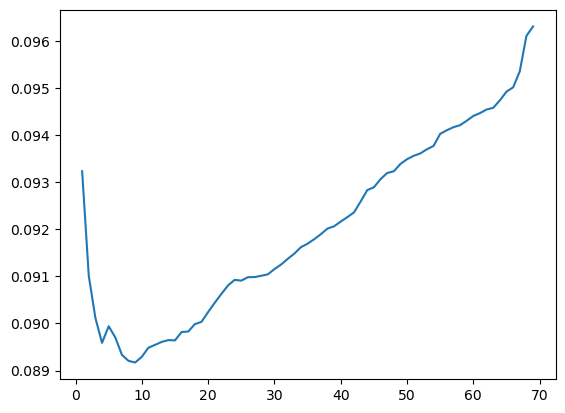

In [103]:
plt.plot(np.arange(max_num_comps)+1, rmse)

In [111]:
comp_min_pls = np.argmin(rmse)+1
comp_min_pls

9

### fPQR Li

Al usar 'cross_val_score' da error porque hay discordancia entre fPRQ y scikit-learn

In [61]:
scores = cross_val_score(fpqr_li, df_x_global, df_y_global, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(np.abs(scores)))

TypeError: Cannot clone object '<fpqr.fast_partial_quantile_regression.FPQRegression object at 0x000002885495D9C0>' (type <class 'fpqr.fast_partial_quantile_regression.FPQRegression'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

It has to be done manually because fPQR is not in scikit-learn

In [113]:
start_time = time.time()
max_num_comps = rank_X
rmse = []
for k in range(max_num_comps):
    fpqr_li = fpqr.FPQRegression(quantile=0.5, n_components=k+1, metric='li')  # By using PLS we regress to the mean
    num_folds = 10
    fold_indices = np.array_split(np.arange(len(df_x_global)), num_folds) # no sé si esto debería ir antes del primer bucle, de modo que todas las componentes se prueben sobre los mismos conjuntos (que han sido seleccionados aleatoraimente al ppio. No sé cómo se hace en cross_val_score. Supongo que al estar dentro del bucle, genera nuevos conjuntos en cada iteración)

    # Initialize a list to store MSE values
    mse_scores = []

    # Perform cross-validation
    for i in range(num_folds):
        train_indices = np.concatenate([fold_indices[j] for j in range(num_folds) if j != i])
        test_indices = fold_indices[i]
        X_train, Y_train = df_x_global[train_indices], df_y_global[train_indices]
        X_test, Y_test = df_x_global[test_indices], df_y_global[test_indices]
    
        # Train your machine learning method on the training data and make predictions
        
        #pls_model = PLSRegression(n_components=3)  # By using PLS we regress to the mean
        #pls_model.fit(X_train, Y_train)
        #predicted_values = pls_model.predict(X_test)
    
        fpqr_li.fit(X_train, Y_train)
        predicted_values = fpqr_li.predict(X_test)
    
        # Calculate squared differences and MSE for this fold
        squared_diff = (Y_test - predicted_values)**2
        mse = np.mean(squared_diff)
    mse_scores.append(mse)
    rmse_k = np.mean(np.sqrt(np.abs(mse_scores)))
    rmse.append(rmse_k)
    
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 40669.45861506462 seconds


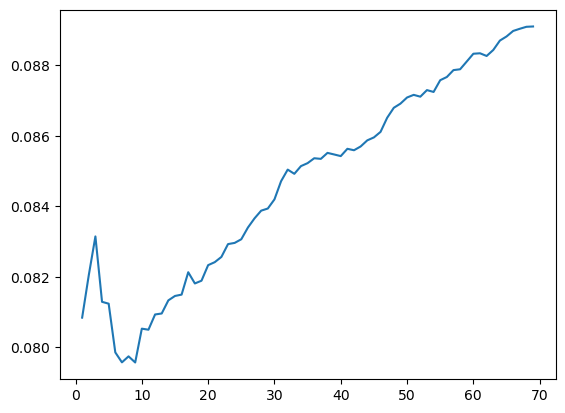

In [115]:
plt.plot(np.arange(max_num_comps)+1, rmse)

In [1438]:
#rmse

In [116]:
comp_min_fpqr = np.argmin(rmse)+1
comp_min_fpqr

9

# Descriptive analysis of the WIFR dataset

In [327]:
# Load the datasets X (regressors) and Y (response) from the cleaned datasets exported from R

df_x_global = pd.read_csv('C:/Users/jorge/OneDrive/Documentos/Máster UC3M/TFM/X_global.csv')
df_y_global = pd.read_csv('C:/Users/jorge/OneDrive/Documentos/Máster UC3M/TFM/Y_global.csv')

In [328]:
# In order to apply fpqr algorithm, we need to convert the datasets to numpy array

df_x_global = df_x_global.to_numpy()
df_y_global = df_y_global.to_numpy()

In [329]:
print(df_x_global.shape)
print(df_y_global.shape)

(588, 69)
(588, 208)


In [330]:
df = np.concatenate((df_y_global, df_x_global), axis=1)
print(df.shape)
df = pd.DataFrame(df)

(588, 277)


In [333]:
#perform Shapiro-Wilk test for normality of X
shapiro(df_x_global)

ShapiroResult(statistic=0.8216359615325928, pvalue=0.0)

In [332]:
#perform Shapiro-Wilk test for normality of Y
shapiro(df_y_global)

ShapiroResult(statistic=0.9299614429473877, pvalue=0.0)

For Multivariate normality we have to use the Henze-Zirkler test. Careful, it is not easy to understand.

In [334]:
multivariate_normality(df_x_train, alpha=.01)

HZResults(hz=1.00012847865758, pval=0.0, normal=False)

So neither $X$ nor $Y$ can be assumed to be normaly distributed

In [73]:
# Kolmogorov-Smirnov test gives an error
#kstest(df_y_global, 'norm')

In [121]:
cov_df = df.cov()

In [170]:
cov_df_2 = np.cov(df, rowvar=False)

In [171]:
cov_df - cov_df_2

0    1    2    3    4    5    6    7    8    9    ...  267  268  269  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
272  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
273  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
274  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
275  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
276  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     270  271  272  273  274  275  276  
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
..   ...  ...  ...  ...  ...  ...  ...  
272  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
273  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
274  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
275  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
276  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[277 rows x 277 columns]

In [82]:
df_center = _center_matrix(df)

In [83]:
np.all((df_center.T @ df_center)/587- cov_df < 1e-16)

True

In [84]:
cov_YtY = cov_df.loc[0:207,0:207] # Var(Y)
cov_XtY = cov_df.loc[208:277,0:207] # Cov(X,Y)
cov_YtX = cov_df.loc[0:207,208:277] # Cov(Y,X)
cov_XtX = cov_df.loc[208:277,208:277] #Var(X)

In [85]:
print(cov_YtY.shape)
print(cov_XtY.shape)
print(cov_YtX.shape)
print(cov_XtX.shape)

(208, 208)
(69, 208)
(208, 69)
(69, 69)


In [86]:
cov_XtY

0         1         2         3         4         5         6    \
208 -0.000004  0.000008 -0.000014 -0.000003 -0.000021 -0.000006 -0.000014   
209  0.000011 -0.000190  0.000098  0.000116  0.000234 -0.000058  0.000030   
210  0.000019  0.000018  0.000017  0.000012  0.000019  0.000010  0.000005   
211 -0.000037  0.000033 -0.000046 -0.000073 -0.000205  0.000010  0.000050   
212 -0.000039  0.000024 -0.000045 -0.000076 -0.000156  0.000004  0.000045   
..        ...       ...       ...       ...       ...       ...       ...   
272 -0.000083 -0.000054 -0.000121 -0.000145 -0.000165 -0.000009  0.000004   
273  0.000052 -0.000071  0.000036  0.000021  0.000330 -0.000071 -0.000065   
274  0.000021  0.000119 -0.000159 -0.000081 -0.000013  0.000039 -0.000142   
275 -0.000036 -0.000005 -0.000045 -0.000074 -0.000135  0.000003  0.000020   
276 -0.000101 -0.000104 -0.000047 -0.000140 -0.000080 -0.000059  0.000037   

          7             8         9    ...       198       199       200  \
208 -0.000008 -1.101987e-06 -0.000012  ... -0.000015  0.000005  0.000014   
209  0.000033 -4.171429e-05 -0.000027  ...  0.000056 -0.000028 -0.000038   
210 -0.000003  5.334063e-07  0.000018  ...  0.000022  0.000011  0.000016   
211  0.000023 -4.165703e-06 -0.000021  ... -0.000033 -0.000028 -0.000023   
212  0.000019 -8.096124e-06 -0.000036  ... -0.000040 -0.000033 -0.000015   
..        ...           ...       ...  ...       ...       ...       ...   
272 -0.000017 -2.914084e-05 -0.000072  ... -0.000155 -0.000160 -0.000144   
273 -0.000032  9.878292e-06 -0.000004  ... -0.000001 -0.000034 -0.000038   
274 -0.000107  5.725891e-05  0.000019  ... -0.000113  0.000012  0.000005   
275  0.000010 -1.040991e-05 -0.000026  ... -0.000056 -0.000051 -0.000038   
276  0.000037 -3.727631e-05 -0.000092  ... -0.000079 -0.000111 -0.000103   

          201       202           203       204       205           206  \
208 -0.000015  0.000005  3.416547e-07 -0.000023 -0.000018  3.536137e-06   
209  0.000126  0.000063 -9.146196e-05  0.000023  0.000055 -1.800195e-04   
210  0.000006  0.000021  8.585587e-06  0.000009  0.000002  1.225835e-05   
211 -0.000093 -0.000054 -7.976417e-06 -0.000037 -0.000052  1.055866e-05   
212 -0.000075 -0.000066 -1.392467e-05 -0.000037 -0.000056 -8.178689e-07   
..        ...       ...           ...       ...       ...           ...   
272 -0.000076 -0.000007 -4.522855e-05 -0.000120 -0.000165 -5.036966e-05   
273  0.000102  0.000022 -1.994891e-05  0.000031 -0.000003 -9.441939e-05   
274 -0.000050 -0.000039  8.822771e-05 -0.000096 -0.000045  7.731584e-05   
275 -0.000059 -0.000037 -1.723006e-05 -0.000037 -0.000062 -1.030995e-05   
276 -0.000029 -0.000062 -1.053626e-04 -0.000053 -0.000064 -9.819863e-05   

          207  
208  0.000015  
209  0.000182  
210 -0.000011  
211 -0.000097  
212 -0.000089  
..        ...  
272 -0.000148  
273  0.000049  
274 -0.000176  
275 -0.000065  
276 -0.000069  

[69 rows x 208 columns]

In [114]:
non_numeric_mask = ~cov_df.applymap(pd.to_numeric, errors='coerce').notna()
non_numeric_mask.any().any()

False

In [118]:
cov_df.isna().any().any()

False

In [119]:
cov_df.isnull().any().any()

False

In [130]:
cov_df_min = cov_df.min().min()
cov_df_max = cov_df.max().max()

# Check if cov_df_min is the minimum value and cov_df_max is the maximum value
is_min = (cov_df >= cov_df_min).all().all()
is_max = (cov_df <= cov_df_max).all().all()

print(is_min)
print(is_max)

True
True


In [131]:
print(cov_df_min)
print(cov_df_max)

-0.0007842514539171604
0.03900439390265912


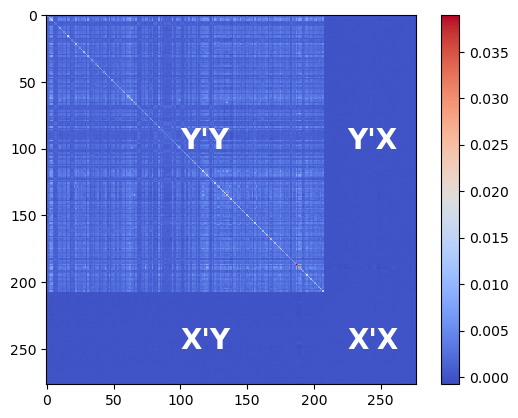

In [175]:
# Create a heatmap with a diverging colormap
plt.imshow(cov_df, cmap='coolwarm', interpolation='nearest', vmin=cov_df_min, vmax=cov_df_max)

# Add a colorbar
plt.colorbar()

# Add the text "Y'Y" inside the heatmap
plt.text(100, 100, "Y'Y", fontsize=20, color='white', weight='bold')
plt.text(100, 250, "X'Y", fontsize=20, color='white', weight='bold')
plt.text(225, 250, "X'X", fontsize=20, color='white', weight='bold')
plt.text(225, 100, "Y'X", fontsize=20, color='white', weight='bold')

# Show the heatmap
plt.show()

In [151]:
cov_YtY_min = cov_YtY.min().min()
cov_YtY_max = cov_YtY.max().max()
cov_YtY_mean = cov_YtY.values.mean()

print(cov_YtY_min)
print(cov_YtY_max)
print(cov_YtY_mean)

-0.0004864157122139492
0.03900439390265912
0.00217362649675841


In [146]:
cov_XtY_min = cov_XtY.min().min()
cov_XtY_max = cov_XtY.max().max()
cov_XtY_mean = cov_XtY.values.mean()

print(cov_XtY_min)
print(cov_XtY_max)
print(cov_XtY_mean)

-0.0007842514539171604
0.0006286588181132018
-7.725740151037449e-06


In [148]:
cov_XtX_min = cov_XtX.min().min()
cov_XtX_max = cov_XtX.max().max()
cov_XtX_mean = cov_XtX.values.mean()

print(cov_XtX_min)
print(cov_XtX_max)
print(cov_XtX_mean)

-9.208596197309294e-05
0.00019057985495227753
2.7663482390248874e-06


There seems to be small covariance between $X$ and $Y$, meaning the performance of PLS over PCR might not be necessarily better. The benefit of fPQR might lie in that the data in not normal, so we can use the hypothetical adavantage of fPQR over PCR and PLS in contexts where the parametric assumptions are not satisfied. However, the simulations don't show that fPQR really poses an avantage. The other reason for using fPQR over other dimensionality reduction techniques is that we can regress to specific quantiles, and this is of much interest in economic contexts. 

Let's train PCR, PLS and fPQR for $\tau=0.5$ with the optimal number of components (we want to test the best version of each algorithm). Then, let's use the quantile power of fPQR and find the optimal number of components for each quantile to optimally predict the quantiles of the testing set.

The data spands over 40 full years, from january 1970 to december 2018. The 20% of that is 8 years, so we are going to use as training set the years 1970-2010 and as testing set the years 2011-2018.

In [335]:
train_index = np.arange(492)
test_index = np.arange(492, 588)

In [336]:
df_x_train = df_x_global[train_index, :]
df_x_test = df_x_global[test_index, :]
df_y_train = df_y_global[train_index, :]
df_y_test = df_y_global[test_index, :]

In [337]:
print(df_x_train.shape)
print(df_x_test.shape)
print(df_y_train.shape)
print(df_y_test.shape)

(492, 69)
(96, 69)
(492, 208)
(96, 208)


In [395]:
rank_X = np.linalg.matrix_rank(df_x_train)
max_num_comps = rank_X
rmse_pls = []
for i in range(max_num_comps):
    pls_model = PLSRegression(n_components=i+1)  # By using PLS we regress to the mean
    scores = cross_val_score(pls_model, df_x_train, df_y_train, cv=10, scoring='neg_mean_squared_error')
    rmse_i = np.mean(np.sqrt(np.abs(scores)))
    rmse_pls.append(rmse_i)


C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations

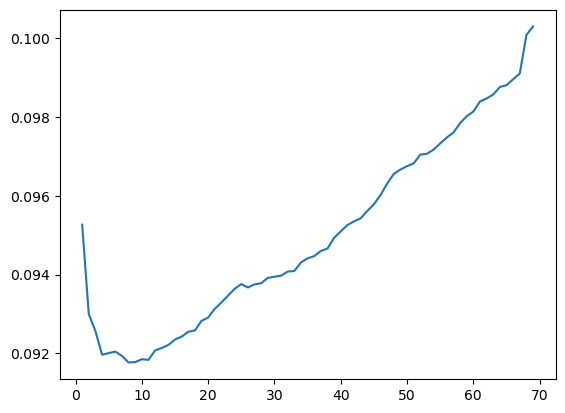

In [396]:
plt.plot(np.arange(max_num_comps)+1, rmse_pls)

In [397]:
comp_min_pls = np.argmin(rmse_pls)+1
comp_min_pls

8

In [ ]:
scores = cross_val_score(fpqr_li, df_x_global, df_y_global, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(np.abs(scores)))

It has to be done manually because fPQR is not in scikit-learn

#### Let's see that the manual code used for fpqr gives the same results as the PLS code using 'cross_val_score' and therefore it works

In [419]:
start_time = time.time()
max_num_comps = rank_X
rmse_pls_2 = []
for k in range(max_num_comps):
    pls_model_2 = PLSRegression(n_components=k+1)  # By using PLS we regress to the mean
    num_folds = 10
    fold_indices = np.array_split(np.arange(len(df_x_train)), num_folds) # no sé si esto debería ir antes del primer bucle, de modo que todas las componentes se prueben sobre los mismos conjuntos (que han sido seleccionados aleatoraimente al ppio. No sé cómo se hace en cross_val_score. Supongo que al estar dentro del bucle, genera nuevos conjuntos en cada iteración)

    # Initialize a list to store MSE values
    mse_scores = []

    # Perform cross-validation
    for i in range(num_folds):
        train_indices = np.concatenate([fold_indices[j] for j in range(num_folds) if j != i])
        test_indices = fold_indices[i]
        X_train, Y_train = df_x_train[train_indices], df_y_train[train_indices]
        X_test, Y_test = df_x_train[test_indices], df_y_train[test_indices]
    
        pls_model_2.fit(X_train, Y_train)
        predicted_values = pls_model_2.predict(X_test)
    
        # Calculate squared differences and MSE for this fold
        squared_diff = (Y_test - predicted_values)**2
        mse = np.mean(squared_diff)
        mse_scores.append(mse)
    rmse_k = np.mean(np.sqrt(np.abs(mse_scores)))
    rmse_pls_2.append(rmse_k)
    
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations

Execution time: 69.74096035957336 seconds


In [425]:
np.array(rmse_pls_2)

array([0.09526682, 0.09299919, 0.09256569, 0.09196702, 0.09200531,
       0.09204574, 0.0919351 , 0.09176869, 0.09177888, 0.09185175,
       0.09183567, 0.09207474, 0.09213638, 0.09221439, 0.09235171,
       0.09242527, 0.09254757, 0.09258127, 0.09282502, 0.09290865,
       0.09313072, 0.09329124, 0.0934671 , 0.09363827, 0.09375905,
       0.09367175, 0.09375199, 0.09378164, 0.09391648, 0.09394667,
       0.09397217, 0.09407703, 0.09409145, 0.09430924, 0.09441152,
       0.09446923, 0.09459938, 0.09466186, 0.09493443, 0.09509727,
       0.0952569 , 0.09535179, 0.09542807, 0.0956153 , 0.09578528,
       0.09602025, 0.09631144, 0.09655677, 0.09666682, 0.096754  ,
       0.09682342, 0.09704621, 0.09706799, 0.09717241, 0.09733104,
       0.09748183, 0.09760585, 0.09784712, 0.09802073, 0.09814033,
       0.09839642, 0.09847156, 0.0985727 , 0.09876413, 0.09880802,
       0.09895936, 0.09910559, 0.10008313, 0.10029923])

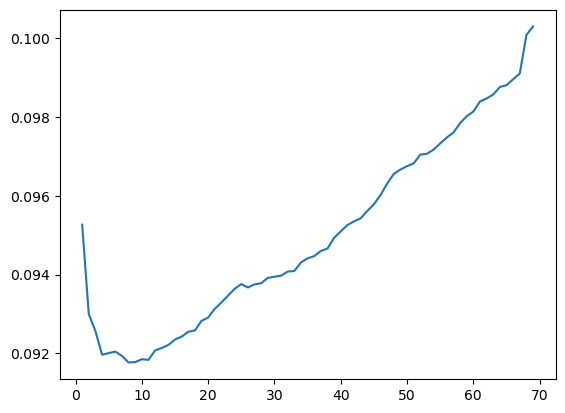

In [421]:
plt.plot(np.arange(max_num_comps)+1, rmse_pls_2)

In [422]:
comp_min_pls_2 = np.argmin(rmse_pls_2)+1
comp_min_pls_2

8

In [426]:
np.array(rmse_pls) - np.array(rmse_pls_2)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.38777878e-17,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.38777878e-17,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.38777878e-17,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.38777878e-17,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.38777878e-17, -1.38777878e-17,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.77555756e-17,
        0.00000000e+00, -1.38777878e-17,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.38777878e-17,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

We see that it gives the same result. The following code is an earlier version that was implemented in fPQR (so the results that came out had to be corrected).

In [427]:
start_time = time.time()
max_num_comps = rank_X
rmse_pls_3 = []
for k in range(max_num_comps):
    pls_model_3 = PLSRegression(n_components=k+1)  # By using PLS we regress to the mean
    num_folds = 10
    fold_indices = np.array_split(np.arange(len(df_x_train)), num_folds) # no sé si esto debería ir antes del primer bucle, de modo que todas las componentes se prueben sobre los mismos conjuntos (que han sido seleccionados aleatoraimente al ppio. No sé cómo se hace en cross_val_score. Supongo que al estar dentro del bucle, genera nuevos conjuntos en cada iteración)

    # Initialize a list to store MSE values
    mse_scores = []

    # Perform cross-validation
    for i in range(num_folds):
        train_indices = np.concatenate([fold_indices[j] for j in range(num_folds) if j != i])
        test_indices = fold_indices[i]
        X_train, Y_train = df_x_train[train_indices], df_y_train[train_indices]
        X_test, Y_test = df_x_train[test_indices], df_y_train[test_indices]
    
        pls_model_3.fit(X_train, Y_train)
        predicted_values = pls_model_3.predict(X_test)
    
        # Calculate squared differences and MSE for this fold
        squared_diff = (Y_test - predicted_values)**2
        mse = np.mean(squared_diff)
    mse_scores.append(mse)
    rmse_k = np.mean(np.sqrt(np.abs(mse_scores)))
    rmse_pls_3.append(rmse_k)
    
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations

Execution time: 72.46936774253845 seconds


In [432]:
#rmse_pls_3

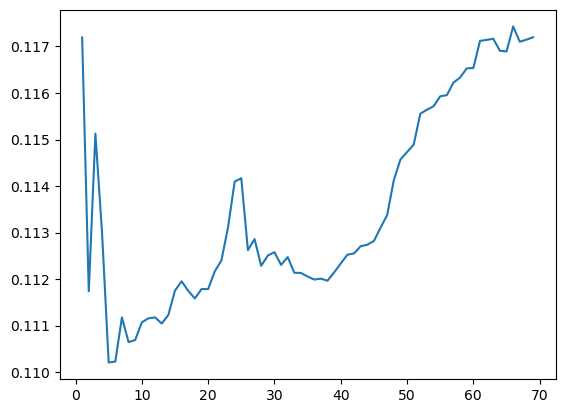

In [429]:
plt.plot(np.arange(max_num_comps)+1, rmse_pls_3)

In [430]:
comp_min_pls_3 = np.argmin(rmse_pls_3)+1
comp_min_pls_3

5

In [431]:
np.array(rmse_pls) - np.array(rmse_pls_3)

array([-0.02192608, -0.0187388 , -0.02256079, -0.02103443, -0.0182028 ,
       -0.01818173, -0.01924125, -0.01887741, -0.01891207, -0.0192175 ,
       -0.01932186, -0.01910197, -0.01890869, -0.01901408, -0.01940161,
       -0.01952844, -0.01920035, -0.0190027 , -0.01896034, -0.01887685,
       -0.01903557, -0.01910903, -0.01964382, -0.0204555 , -0.02040881,
       -0.01895093, -0.01910777, -0.01850309, -0.01859136, -0.01863061,
       -0.01833277, -0.0183961 , -0.01804527, -0.01782252, -0.0176441 ,
       -0.01752073, -0.01741066, -0.01730361, -0.01720872, -0.0172385 ,
       -0.01726734, -0.01719926, -0.01727983, -0.01712299, -0.01703402,
       -0.01708458, -0.01706576, -0.01756751, -0.01790413, -0.0179766 ,
       -0.01806712, -0.0185086 , -0.01857296, -0.01854143, -0.01859807,
       -0.01847131, -0.01861787, -0.01848457, -0.01850925, -0.01839566,
       -0.01872298, -0.01866934, -0.01859254, -0.01814333, -0.01808433,
       -0.01846996, -0.01799596, -0.017063  , -0.0168981 ])

Indeed it does not give the same result. Now we test the code using the quantal error $EQ_{\tau}$ instead of MSE.

In [435]:
start_time = time.time()
max_num_comps = rank_X
qe_pls_4 = []
for k in range(max_num_comps):
    pls_model_4 = PLSRegression(n_components=k+1)  # By using PLS we regress to the mean
    num_folds = 10
    fold_indices = np.array_split(np.arange(len(df_x_train)), num_folds) # no sé si esto debería ir antes del primer bucle, de modo que todas las componentes se prueben sobre los mismos conjuntos (que han sido seleccionados aleatoraimente al ppio. No sé cómo se hace en cross_val_score. Supongo que al estar dentro del bucle, genera nuevos conjuntos en cada iteración)

    # Initialize a list to store MSE values
    qe_scores = []

    # Perform cross-validation
    for i in range(num_folds):
        train_indices = np.concatenate([fold_indices[j] for j in range(num_folds) if j != i])
        test_indices = fold_indices[i]
        X_train, Y_train = df_x_train[train_indices], df_y_train[train_indices]
        X_test, Y_test = df_x_train[test_indices], df_y_train[test_indices]
    
        pls_model_4.fit(X_train, Y_train)
        predicted_values = pls_model_4.predict(X_test)
    
        # Calculate squared differences and MSE for this fold
        squared_diff = (Y_test - predicted_values)**2
        mse = np.mean(squared_diff)
        qe = _quantile_function(Y_test, predicted_values, 0.5)
        qe_scores.append(qe)
    qe_k = np.mean(qe_scores)
    qe_pls_4.append(qe_k)
    
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
C:\Users\jorge\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:110: ConvergenceWarning: Maximum number of iterations

Execution time: 69.64121055603027 seconds


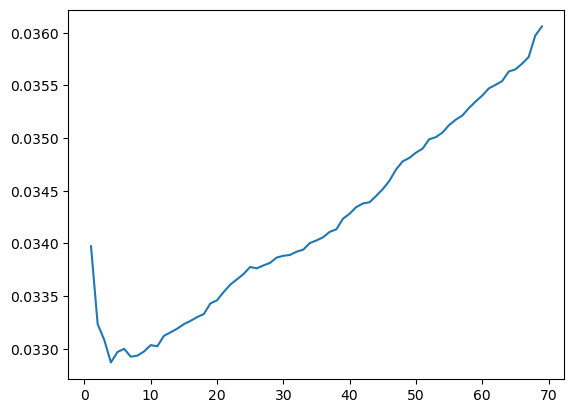

In [436]:
plt.plot(np.arange(max_num_comps)+1, qe_pls_4)

In [438]:
comp_min_pls_4 = np.argmin(qe_pls_4)+1
comp_min_pls_4

4

In [2]:
start_time = time.time()
max_num_comps = rank_X
rmse_fpqr_li = []
for k in range(max_num_comps):
    fpqr_li = fpqr.FPQRegression(quantile=0.5, n_components=k+1, metric='li')  # By using PLS we regress to the mean
    num_folds = 10
    fold_indices = np.array_split(np.arange(len(df_x_train)), num_folds) # no sé si esto debería ir antes del primer bucle, de modo que todas las componentes se prueben sobre los mismos conjuntos (que han sido seleccionados aleatoraimente al ppio. No sé cómo se hace en cross_val_score. Supongo que al estar dentro del bucle, genera nuevos conjuntos en cada iteración)

    # Initialize a list to store MSE values
    mse_scores = []

    # Perform cross-validation
    for i in range(num_folds):
        train_indices = np.concatenate([fold_indices[j] for j in range(num_folds) if j != i])
        test_indices = fold_indices[i]
        X_train, Y_train = df_x_train[train_indices], df_y_train[train_indices]
        X_test, Y_test = df_x_train[test_indices], df_y_train[test_indices]
    
        fpqr_li.fit(X_train, Y_train)
        predicted_values = fpqr_li.predict(X_test)
    
        # Calculate squared differences and MSE for this fold
        squared_diff = (Y_test - predicted_values)**2
        mse = np.mean(squared_diff)
    mse_scores.append(mse)
    rmse_k = np.mean(np.sqrt(np.abs(mse_scores)))
    rmse_fpqr_li.append(rmse_k)
    
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

NameError: name 'time' is not defined

In [ ]:
plt.plot(np.arange(max_num_comps)+1, rmse_fpqr_li)

In [ ]:
comp_min_fpqr = np.argmin(rmse_fpqr_li)+1
comp_min_fpqr

In [335]:
with open('rmse_fpqr_li_9.pkl', 'rb') as file:
    rmse_fpqr_li_9 = pickle.load(file)
with open('rmse_fpqr_li_8.pkl', 'rb') as file:
    rmse_fpqr_li_8 = pickle.load(file)
with open('rmse_fpqr_li_7.pkl', 'rb') as file:
    rmse_fpqr_li_7 = pickle.load(file)
with open('rmse_fpqr_li_6.pkl', 'rb') as file:
    rmse_fpqr_li_6 = pickle.load(file)
with open('rmse_fpqr_li_5.pkl', 'rb') as file:
    rmse_fpqr_li_5 = pickle.load(file)
with open('rmse_fpqr_li_4.pkl', 'rb') as file:
    rmse_fpqr_li_4 = pickle.load(file)
with open('rmse_fpqr_li_3.pkl', 'rb') as file:
    rmse_fpqr_li_3 = pickle.load(file)
with open('rmse_fpqr_li_2.pkl', 'rb') as file:
    rmse_fpqr_li_2 = pickle.load(file)
with open('rmse_fpqr_li_1.pkl', 'rb') as file:
    rmse_fpqr_li_1 = pickle.load(file)

In [336]:
comp_min_fpqr_9 = np.argmin(rmse_fpqr_li_9)+1
comp_min_fpqr_8 = np.argmin(rmse_fpqr_li_8)+1
comp_min_fpqr_7 = np.argmin(rmse_fpqr_li_7)+1
comp_min_fpqr_6 = np.argmin(rmse_fpqr_li_6)+1
comp_min_fpqr_5 = np.argmin(rmse_fpqr_li_5)+1
comp_min_fpqr_4 = np.argmin(rmse_fpqr_li_4)+1
comp_min_fpqr_3 = np.argmin(rmse_fpqr_li_3)+1
comp_min_fpqr_2 = np.argmin(rmse_fpqr_li_2)+1
comp_min_fpqr_1 = np.argmin(rmse_fpqr_li_1)+1

In [337]:
list_rmse_fpqr_li = [rmse_fpqr_li_1, rmse_fpqr_li_2, rmse_fpqr_li_3, rmse_fpqr_li_4, rmse_fpqr_li_5, rmse_fpqr_li_6, rmse_fpqr_li_7, rmse_fpqr_li_8, rmse_fpqr_li_9]

In [338]:
rank_X = np.linalg.matrix_rank(df_x_train)
max_num_comps = rank_X

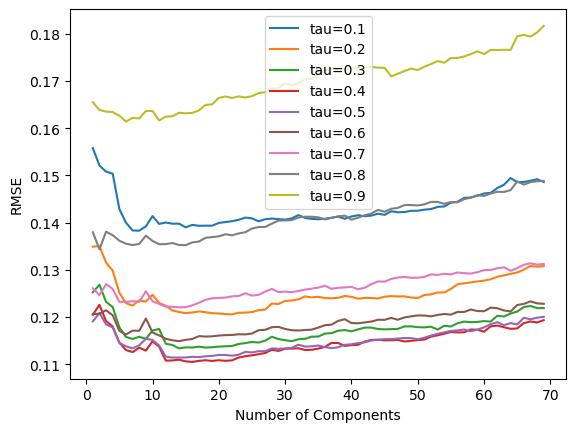

In [345]:
# Create a figure and axis
fig, ax = plt.subplots()

x = np.arange(max_num_comps)+1

# Plot each array
for i, data in enumerate(list_rmse_fpqr_li):
    label = f'tau={round(0.1*(i + 1), 1)}'  # Label for the legend
    ax.plot(x, data, label=label)

# Add labels and legend
ax.set_xlabel('Number of Components')
ax.set_ylabel('RMSE')
ax.legend()

# Show the plot
plt.show()     #MAYBE THE MINIMUM SHOULD BE POINTED OUT WITH A DOT

In [343]:
comp_min_fpqr = [comp_min_fpqr_1, comp_min_fpqr_2, comp_min_fpqr_3, comp_min_fpqr_4, comp_min_fpqr_5, comp_min_fpqr_6,
                 comp_min_fpqr_7, comp_min_fpqr_8, comp_min_fpqr_9]

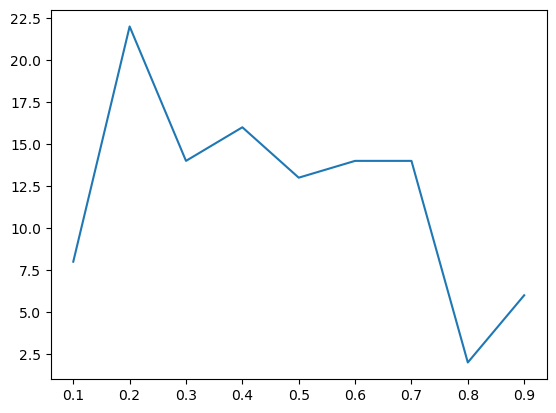

In [344]:
plt.plot(0.1*(np.arange(9)+1), comp_min_fpqr) #maybe add to the plot the number of components for each tau, beacuse 22.5 is misleading

It is observed a decreasing tendency in the optimal number of components required as the quantile grows

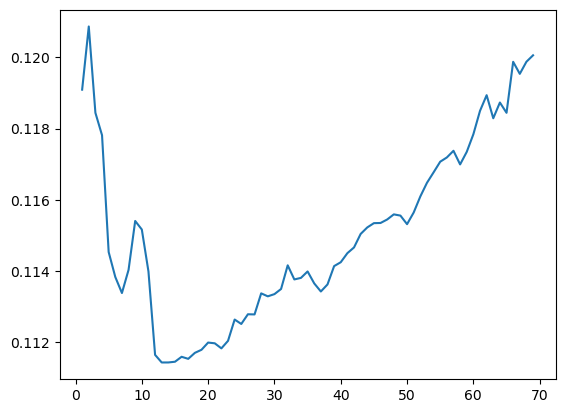

In [346]:
plt.plot(np.arange(max_num_comps)+1, rmse_fpqr_li_5)

Aproximación de la respuesta condicional.

In [348]:
print(comp_min_fpqr_1)
print(comp_min_fpqr_2)
print(comp_min_fpqr_3)
print(comp_min_fpqr_4)
print(comp_min_fpqr_5)
print(comp_min_fpqr_6)
print(comp_min_fpqr_7)
print(comp_min_fpqr_8)
print(comp_min_fpqr_9)

8
22
14
16
13
14
14
2
6


In [349]:
fpqr_li_1 = fpqr.FPQRegression(quantile=0.1, n_components=8, metric='li')
fpqr_li_1.fit(df_x_train, df_y_train)

fpqr_li_2 = fpqr.FPQRegression(quantile=0.2, n_components=22, metric='li')
fpqr_li_2.fit(df_x_train, df_y_train)

fpqr_li_3 = fpqr.FPQRegression(quantile=0.3, n_components=14, metric='li')
fpqr_li_3.fit(df_x_train, df_y_train)

fpqr_li_4 = fpqr.FPQRegression(quantile=0.4, n_components=16, metric='li')
fpqr_li_4.fit(df_x_train, df_y_train)

fpqr_li_5 = fpqr.FPQRegression(quantile=0.5, n_components=13, metric='li')
fpqr_li_5.fit(df_x_train, df_y_train)

fpqr_li_6 = fpqr.FPQRegression(quantile=0.6, n_components=14, metric='li')
fpqr_li_6.fit(df_x_train, df_y_train)

fpqr_li_7 = fpqr.FPQRegression(quantile=0.7, n_components=14, metric='li')
fpqr_li_7.fit(df_x_train, df_y_train)

fpqr_li_8 = fpqr.FPQRegression(quantile=0.8, n_components=2, metric='li')
fpqr_li_8.fit(df_x_train, df_y_train)

fpqr_li_9 = fpqr.FPQRegression(quantile=0.9, n_components=6, metric='li')
fpqr_li_9.fit(df_x_train, df_y_train)

In [351]:
predictions_fpqr_li_1 = fpqr_li_1.predict(df_x_test)
predictions_fpqr_li_2 = fpqr_li_2.predict(df_x_test)
predictions_fpqr_li_3 = fpqr_li_3.predict(df_x_test)
predictions_fpqr_li_4 = fpqr_li_4.predict(df_x_test)
predictions_fpqr_li_5 = fpqr_li_5.predict(df_x_test)
predictions_fpqr_li_6 = fpqr_li_6.predict(df_x_test)
predictions_fpqr_li_7 = fpqr_li_7.predict(df_x_test)
predictions_fpqr_li_8 = fpqr_li_8.predict(df_x_test)
predictions_fpqr_li_9 = fpqr_li_9.predict(df_x_test)

In [353]:
pd.DataFrame(predictions_fpqr_li_1)

0         1         2         3         4         5         6    \
0  -0.036454 -0.076038 -0.098818 -0.099396 -0.114191 -0.031736 -0.023380   
1  -0.027522 -0.059103 -0.047354 -0.068917 -0.078625 -0.032401 -0.027511   
2  -0.034524 -0.042333 -0.070736 -0.072786 -0.094759 -0.031533 -0.032264   
3  -0.013368 -0.047539 -0.040986 -0.034237 -0.080948 -0.026047 -0.026559   
4  -0.065071 -0.071310 -0.110722 -0.109652 -0.143690 -0.054930 -0.040912   
..       ...       ...       ...       ...       ...       ...       ...   
91 -0.086659 -0.064394 -0.107338 -0.099143 -0.136904 -0.057482 -0.063197   
92 -0.067088 -0.055805 -0.091525 -0.117651 -0.126894 -0.066931 -0.043470   
93 -0.136804 -0.106687 -0.174588 -0.177721 -0.222367 -0.088012 -0.071831   
94 -0.072338 -0.076627 -0.164428 -0.154567 -0.181374 -0.047407 -0.035936   
95 -0.132401 -0.084403 -0.190778 -0.186666 -0.230300 -0.077418 -0.071842   

         7         8         9    ...       198       199       200       201  \
0  -0.020675 -0.031743 -0.034398  ... -0.071818 -0.043470 -0.067540 -0.016775   
1  -0.024212 -0.021836 -0.037928  ... -0.064714 -0.034950 -0.060606 -0.059731   
2  -0.034432 -0.021435 -0.045935  ... -0.066064 -0.033783 -0.066635 -0.070731   
3  -0.029238 -0.023040 -0.028516  ... -0.049791 -0.017306 -0.063725 -0.052625   
4  -0.037328 -0.041128 -0.067856  ... -0.086797 -0.072674 -0.091674 -0.075142   
..       ...       ...       ...  ...       ...       ...       ...       ...   
91 -0.066392 -0.047392 -0.099965  ... -0.083474 -0.079975 -0.072168 -0.097223   
92 -0.035026 -0.032152 -0.070819  ... -0.082014 -0.074886 -0.083825 -0.109457   
93 -0.062550 -0.071001 -0.121417  ... -0.119744 -0.145649 -0.107563 -0.126803   
94 -0.032497 -0.041151 -0.055666  ... -0.095581 -0.080894 -0.105497 -0.056100   
95 -0.067023 -0.060983 -0.111769  ... -0.115331 -0.136323 -0.114815 -0.140022   

         202       203       204       205       206       207  
0  -0.059474 -0.041383 -0.046752 -0.068317 -0.047380 -0.078998  
1  -0.046031 -0.031335 -0.046514 -0.052917 -0.074896 -0.037733  
2  -0.043498 -0.039992 -0.050126 -0.059371 -0.073513 -0.071604  
3  -0.014344 -0.028301 -0.043590 -0.050049 -0.071346 -0.068731  
4  -0.068820 -0.066252 -0.075015 -0.094482 -0.078007 -0.123892  
..       ...       ...       ...       ...       ...       ...  
91 -0.077244 -0.088346 -0.060114 -0.090509 -0.088631 -0.104506  
92 -0.084509 -0.066789 -0.072693 -0.087137 -0.083219 -0.090466  
93 -0.145435 -0.120825 -0.105034 -0.146916 -0.108147 -0.165583  
94 -0.096851 -0.068028 -0.084046 -0.114108 -0.070135 -0.159171  
95 -0.149557 -0.115929 -0.108533 -0.150887 -0.116403 -0.182660  

[96 rows x 208 columns]

In [354]:
pd.DataFrame(df_y_test)

0         1         2         3         4         5         6    \
0   0.053612  0.086104 -0.090452  0.062967  0.094245 -0.044397  0.006859   
1   0.039859  0.142945  0.223362  0.156125  0.311684  0.017025  0.013424   
2   0.031083 -0.031469 -0.207097  0.104212 -0.159849  0.045213  0.014806   
3   0.025456  0.028048  0.035188 -0.081007 -0.049327  0.016883  0.027602   
4  -0.022007 -0.120205 -0.184980 -0.072315 -0.058288 -0.009635  0.029547   
..       ...       ...       ...       ...       ...       ...       ...   
91  0.000971  0.051285  0.208719  0.035925  0.447471 -0.044178  0.009059   
92  0.046146 -0.002579 -0.112401  0.009033  0.096774  0.045098 -0.034714   
93 -0.093229 -0.060076 -0.046291 -0.224261 -0.097549  0.036588 -0.002494   
94  0.018989 -0.018942 -0.116082  0.024235 -0.265616  0.060777  0.066645   
95 -0.099693 -0.109735 -0.077076 -0.124246 -0.139793 -0.060516 -0.048413   

         7         8         9    ...       198       199       200       201  \
0   0.020741  0.103392 -0.057540  ...  0.014577 -0.017490 -0.001909  0.060585   
1   0.017726  0.065568  0.052030  ... -0.070402  0.036187  0.014209  0.038941   
2   0.051827 -0.016369  0.114442  ...  0.006182 -0.046564  0.031818 -0.012637   
3   0.032067  0.045763  0.093378  ...  0.036866 -0.036629 -0.007489 -0.004772   
4   0.021571 -0.045920 -0.060326  ... -0.026667 -0.063322  0.002663 -0.052378   
..       ...       ...       ...  ...       ...       ...       ...       ...   
91  0.023954 -0.006380  0.025625  ...  0.099368  0.016667 -0.091126 -0.003219   
92 -0.010145  0.060496  0.030551  ...  0.028813  0.016709  0.003694 -0.015186   
93  0.029964 -0.062809 -0.134658  ... -0.178865 -0.041085 -0.085699 -0.026764   
94  0.065302  0.008032  0.114507  ...  0.070487  0.030244  0.062680  0.019905   
95 -0.070945 -0.142264 -0.146809  ... -0.151748  0.013573 -0.039717 -0.122043   

         202       203       204       205       206       207  
0  -0.023194  0.021260 -0.088142 -0.011133  0.051218  0.046916  
1   0.120081  0.012258 -0.037024 -0.022140  0.213259  0.065962  
2  -0.075106  0.030605 -0.048335  0.028353  0.111916 -0.051488  
3  -0.011162  0.052273 -0.018196  0.079469  0.032856  0.196909  
4  -0.053121  0.019088  0.013849 -0.100321 -0.063042  0.170137  
..       ...       ...       ...       ...       ...       ...  
91  0.055304  0.010207  0.092464 -0.013631  0.075517 -0.021054  
92  0.033505  0.081065  0.008114 -0.048846 -0.039172 -0.027233  
93 -0.035117 -0.102008 -0.051922 -0.082406  0.030680 -0.077548  
94  0.151646  0.057174 -0.143848  0.000190  0.027129 -0.014627  
95 -0.176825 -0.101119 -0.068630 -0.018772 -0.060718 -0.129413  

[96 rows x 208 columns]

In [355]:
squared_diff = (df_y_test - predictions_fpqr_li_1)**2

In [358]:
np.mean(squared_diff)

0.014426236191954649

### Using quantile error to estimate components

In [338]:
with open('qe_fpqr_li_9.pkl', 'rb') as file:
    qe_fpqr_li_9 = pickle.load(file)
with open('qe_fpqr_li_8.pkl', 'rb') as file:
    qe_fpqr_li_8 = pickle.load(file)
with open('qe_fpqr_li_7.pkl', 'rb') as file:
    qe_fpqr_li_7 = pickle.load(file)
with open('qe_fpqr_li_6.pkl', 'rb') as file:
    qe_fpqr_li_6 = pickle.load(file)
with open('qe_fpqr_li_5.pkl', 'rb') as file:
    qe_fpqr_li_5 = pickle.load(file)
with open('qe_fpqr_li_4.pkl', 'rb') as file:
    qe_fpqr_li_4 = pickle.load(file)
with open('qe_fpqr_li_3.pkl', 'rb') as file:
    qe_fpqr_li_3 = pickle.load(file)
with open('qe_fpqr_li_2.pkl', 'rb') as file:
    qe_fpqr_li_2 = pickle.load(file)
with open('qe_fpqr_li_1.pkl', 'rb') as file:
    qe_fpqr_li_1 = pickle.load(file)

In [339]:
comp_min_fpqr_9 = np.argmin(qe_fpqr_li_9)+1
comp_min_fpqr_8 = np.argmin(qe_fpqr_li_8)+1
comp_min_fpqr_7 = np.argmin(qe_fpqr_li_7)+1
comp_min_fpqr_6 = np.argmin(qe_fpqr_li_6)+1
comp_min_fpqr_5 = np.argmin(qe_fpqr_li_5)+1
comp_min_fpqr_4 = np.argmin(qe_fpqr_li_4)+1
comp_min_fpqr_3 = np.argmin(qe_fpqr_li_3)+1
comp_min_fpqr_2 = np.argmin(qe_fpqr_li_2)+1
comp_min_fpqr_1 = np.argmin(qe_fpqr_li_1)+1

In [340]:
list_qe_fpqr_li = [qe_fpqr_li_1, qe_fpqr_li_2, qe_fpqr_li_3, qe_fpqr_li_4, qe_fpqr_li_5, qe_fpqr_li_6, qe_fpqr_li_7, qe_fpqr_li_8, qe_fpqr_li_9]

In [341]:
rank_X = np.linalg.matrix_rank(df_x_train)
max_num_comps = rank_X

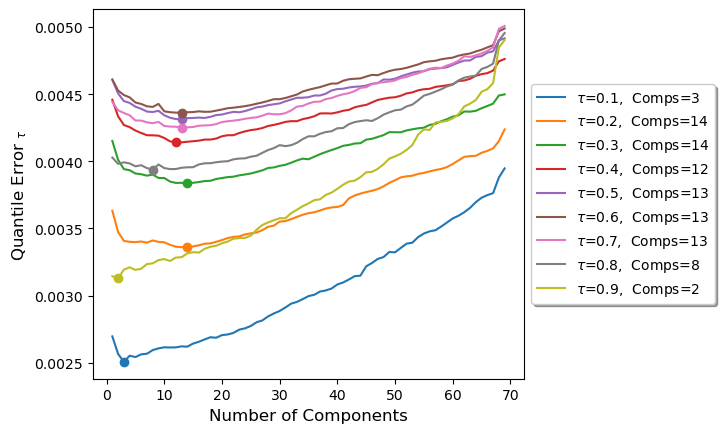

In [56]:
# Create a figure and axis
fig, ax = plt.subplots()

x = np.arange(max_num_comps)+1

# Plot each array
for i, data in enumerate(list_qe_fpqr_li):
    label = f'$\\tau$={round(0.1*(i + 1), 1)},  Comps={np.argmin(data)+1}'  # Label for the legend
    ax.plot(x, data, label=label)
    ax.scatter(np.argmin(data)+1, np.min(data), marker='o', zorder=5)

# Add labels and legend
ax.set_xlabel('Number of Components', fontsize=12)
ax.set_ylabel('Quantile Error $_{\\tau}$', fontsize=12)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.87, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

# Show the plot
plt.show()     #THE MINIMUM IS POINTED OUT WITH A DOT

In [42]:
comp_min_fpqr = [comp_min_fpqr_1, comp_min_fpqr_2, comp_min_fpqr_3, comp_min_fpqr_4, comp_min_fpqr_5, comp_min_fpqr_6,
                 comp_min_fpqr_7, comp_min_fpqr_8, comp_min_fpqr_9]

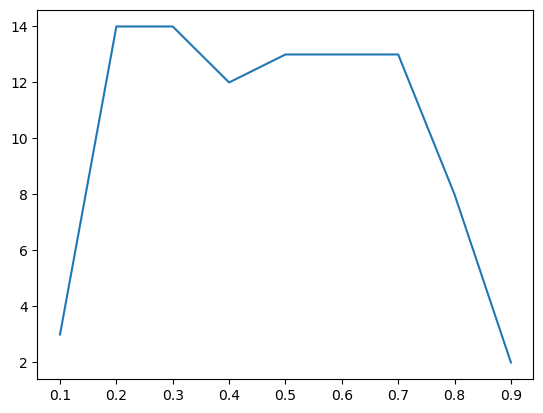

In [43]:
plt.plot(0.1*(np.arange(9)+1), comp_min_fpqr) #maybe add to the plot the number of components for each tau, beacuse 22.5 is misleading

In [342]:
fpqr_li_1 = fpqr.FPQRegression(quantile=0.1, n_components=comp_min_fpqr_1, metric='li')
fpqr_li_1.fit(df_x_train, df_y_train)
predictions_li_1 = fpqr_li_1.predict(df_x_test)

fpqr_li_2 = fpqr.FPQRegression(quantile=0.2, n_components=comp_min_fpqr_2, metric='li')
fpqr_li_2.fit(df_x_train, df_y_train)
predictions_li_2 = fpqr_li_2.predict(df_x_test)

fpqr_li_3 = fpqr.FPQRegression(quantile=0.3, n_components=comp_min_fpqr_3, metric='li')
fpqr_li_3.fit(df_x_train, df_y_train)
predictions_li_3 = fpqr_li_3.predict(df_x_test)

fpqr_li_4 = fpqr.FPQRegression(quantile=0.4, n_components=comp_min_fpqr_4, metric='li')
fpqr_li_4.fit(df_x_train, df_y_train)
predictions_li_4 = fpqr_li_4.predict(df_x_test)

fpqr_li_5 = fpqr.FPQRegression(quantile=0.5, n_components=comp_min_fpqr_5, metric='li')
fpqr_li_5.fit(df_x_train, df_y_train)
predictions_li_5 = fpqr_li_5.predict(df_x_test)

fpqr_li_6 = fpqr.FPQRegression(quantile=0.6, n_components=comp_min_fpqr_6, metric='li')
fpqr_li_6.fit(df_x_train, df_y_train)
predictions_li_6 = fpqr_li_6.predict(df_x_test)

fpqr_li_7 = fpqr.FPQRegression(quantile=0.7, n_components=comp_min_fpqr_7, metric='li')
fpqr_li_7.fit(df_x_train, df_y_train)
predictions_li_7 = fpqr_li_7.predict(df_x_test)

fpqr_li_8 = fpqr.FPQRegression(quantile=0.8, n_components=comp_min_fpqr_8, metric='li')
fpqr_li_8.fit(df_x_train, df_y_train)
predictions_li_8 = fpqr_li_8.predict(df_x_test)

fpqr_li_9 = fpqr.FPQRegression(quantile=0.9, n_components=comp_min_fpqr_9, metric='li')
fpqr_li_9.fit(df_x_train, df_y_train)
predictions_li_9 = fpqr_li_9.predict(df_x_test)

pls_model = PLSRegression(n_components=8)  # By using PLS we regress to the mean
pls_model.fit(df_x_train, df_y_train)
predictions_pls = pls_model.predict(df_x_test)

In [343]:
# Generate a list of dates from January 2011 to December 2018
start_date = datetime(2011, 1, 1)
end_date = datetime(2018, 12, 31)  # Using the last day of December 2018
dates = [start_date]

while dates[-1] < end_date:
    next_month = dates[-1].replace(day=1, month=(dates[-1].month % 12) + 1, year=dates[-1].year + (dates[-1].month // 12))
    dates.append(next_month)

# Specify the positions of the labeled dates (for example, every 12 months)
labeled_date_positions = range(0, len(dates), 12)

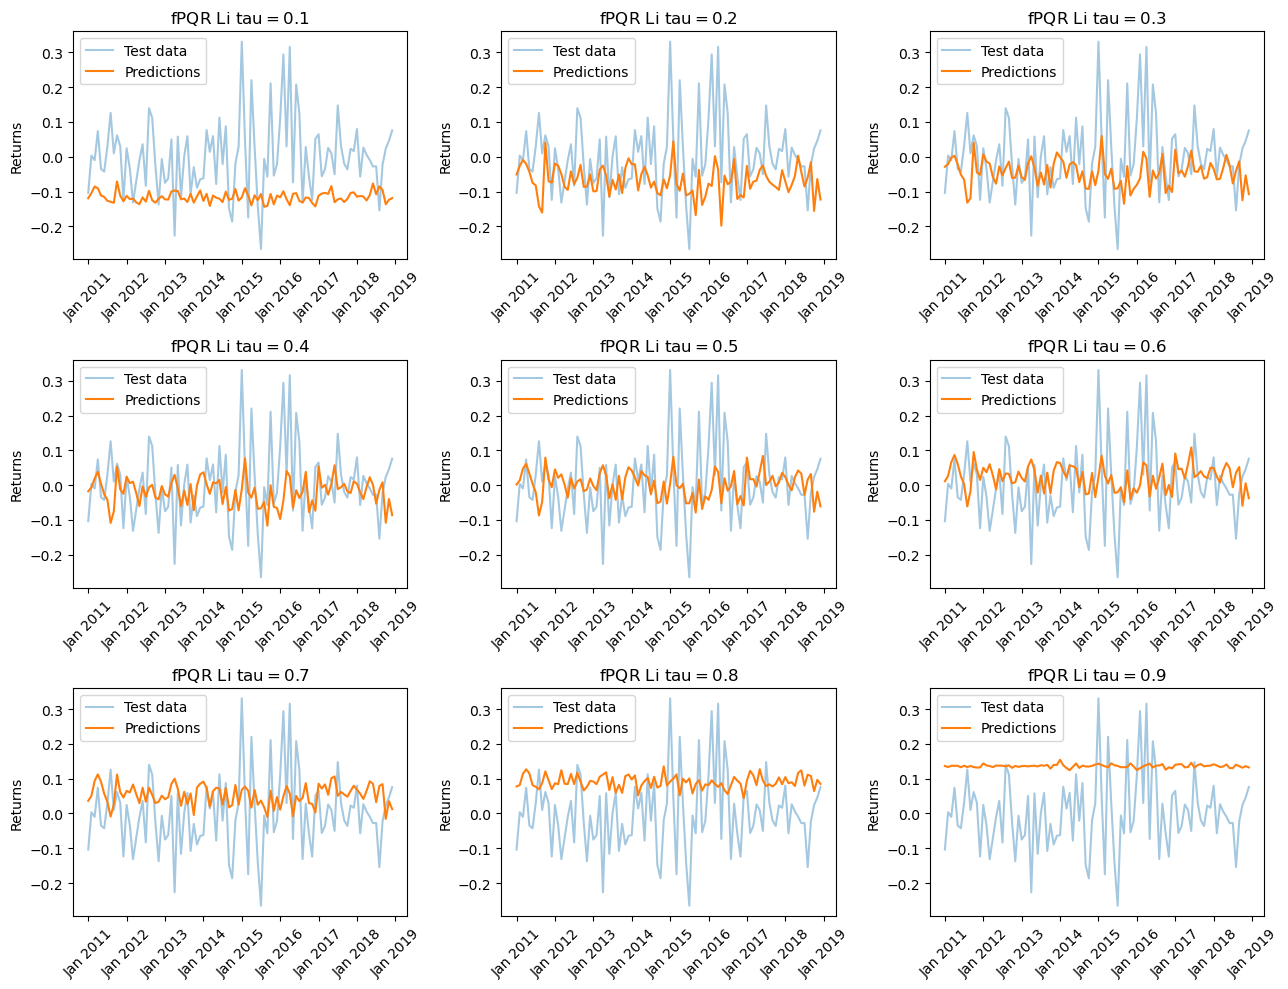

In [344]:
company = 66
alpha = 0.4

fig4, axes = plt.subplots(3, 3, figsize=(13, 10))
axes[0,0].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[0,0].plot(np.arange(df_x_test.shape[0]), predictions_li_1[:,company], label='Predictions')
axes[0,0].set_xticks(labeled_date_positions)
axes[0,0].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45)
axes[0,0].set(xlabel="", ylabel="Returns", title="fPQR Li tau$=0.1$")
axes[0,0].legend()
axes[0,1].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[0,1].plot(np.arange(df_x_test.shape[0]), predictions_li_2[:,company], label='Predictions')
axes[0,1].set_xticks(labeled_date_positions)
axes[0,1].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45)
axes[0,1].set(xlabel="", ylabel="Returns", title="fPQR Li tau$=0.2$")
axes[0,1].legend()
axes[0,2].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[0,2].plot(np.arange(df_x_test.shape[0]), predictions_li_3[:,company], label='Predictions')
axes[0,2].set_xticks(labeled_date_positions)
axes[0,2].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45)
axes[0,2].set(xlabel="", ylabel="Returns", title="fPQR Li tau$=0.3$")
axes[0,2].legend()
axes[1,0].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[1,0].plot(np.arange(df_x_test.shape[0]), predictions_li_4[:,company], label='Predictions')
axes[1,0].set_xticks(labeled_date_positions)
axes[1,0].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45)
axes[1,0].set(xlabel="", ylabel="Returns", title="fPQR Li tau$=0.4$")
axes[1,0].legend()
axes[1,1].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[1,1].plot(np.arange(df_x_test.shape[0]), predictions_li_5[:,company], label='Predictions')
axes[1,1].set_xticks(labeled_date_positions)
axes[1,1].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45)
axes[1,1].set(xlabel="", ylabel="Returns", title="fPQR Li tau$=0.5$")
axes[1,1].legend()
axes[1,2].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[1,2].plot(np.arange(df_x_test.shape[0]), predictions_li_6[:,company], label='Predictions')
axes[1,2].set_xticks(labeled_date_positions)
axes[1,2].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45)
axes[1,2].set(xlabel="", ylabel="Returns", title="fPQR Li tau$=0.6$")
axes[1,2].legend()
axes[2,0].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[2,0].plot(np.arange(df_x_test.shape[0]), predictions_li_7[:,company], label='Predictions')
axes[2,0].set_xticks(labeled_date_positions)
axes[2,0].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45)
axes[2,0].set(xlabel="", ylabel="Returns", title="fPQR Li tau$=0.7$")
axes[2,0].legend()
axes[2,1].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[2,1].plot(np.arange(df_x_test.shape[0]), predictions_li_8[:,company], label='Predictions')
axes[2,1].set_xticks(labeled_date_positions)
axes[2,1].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45)
axes[2,1].set(xlabel="", ylabel="Returns", title="fPQR Li tau$=0.8$")
axes[2,1].legend()
axes[2,2].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[2,2].plot(np.arange(df_x_test.shape[0]), predictions_li_9[:,company], label='Predictions')
axes[2,2].set_xticks(labeled_date_positions)
axes[2,2].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45)
axes[2,2].set(xlabel="", ylabel="Returns", title="fPQR Li tau$=0.9$")
axes[2,2].legend()
plt.tight_layout()
plt.show()

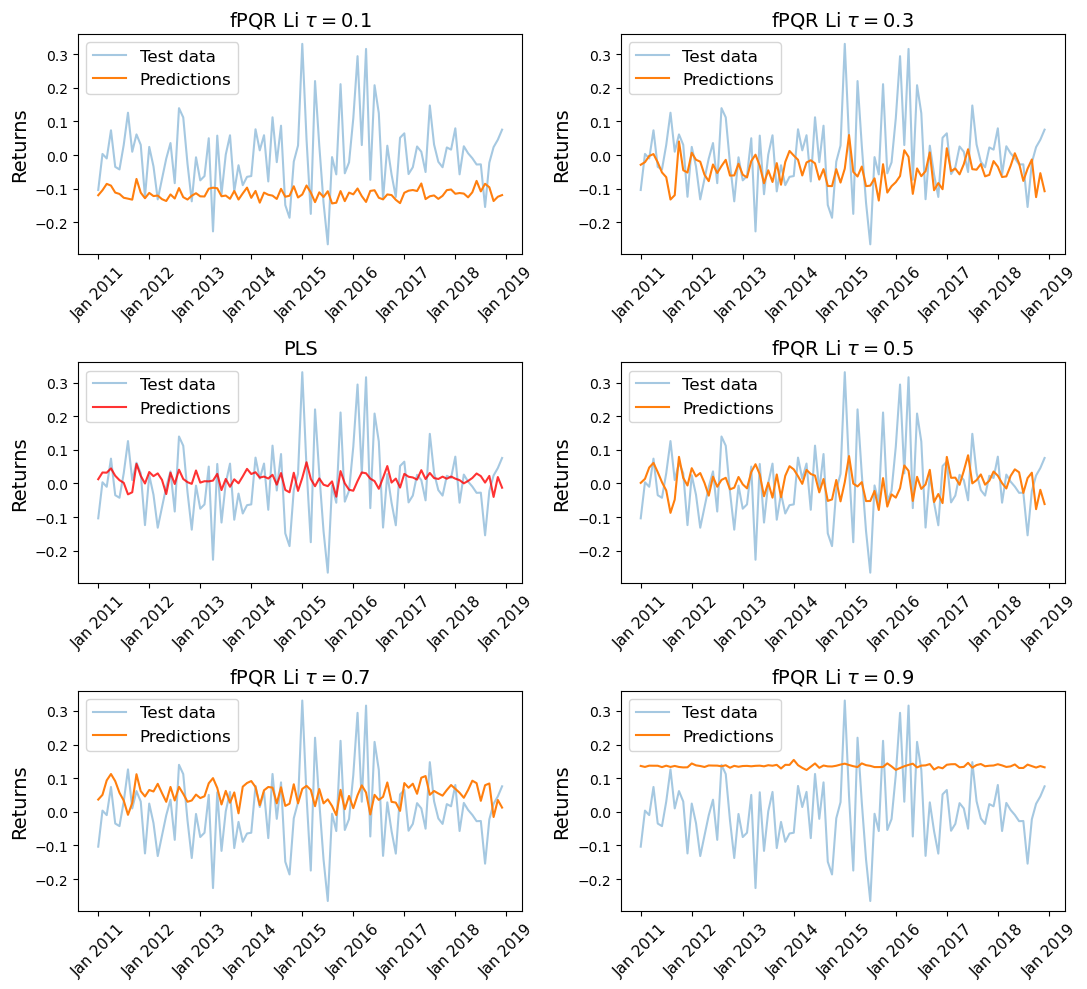

In [347]:
# Define the font properties for bold titles
title_font = FontProperties(weight='bold')
company = 66
alpha = 0.4

fig4, axes = plt.subplots(3, 2, figsize=(11, 10))

axes[0,0].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[0,0].plot(np.arange(df_x_test.shape[0]), predictions_li_1[:,company], label='Predictions')
axes[0,0].set_xticks(labeled_date_positions)
axes[0,0].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45, fontsize=11)
axes[0,0].set_ylabel("Returns", fontsize=14)
axes[0,0].set_title("fPQR Li $\\tau=0.1$", fontsize=14)
axes[0,0].legend(fontsize=12)

axes[0,1].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[0,1].plot(np.arange(df_x_test.shape[0]), predictions_li_3[:,company], label='Predictions')
axes[0,1].set_xticks(labeled_date_positions)
axes[0,1].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45, fontsize=11)
axes[0,1].set_ylabel("Returns", fontsize=14)
axes[0,1].set_title("fPQR Li $\\tau=0.3$", fontsize=14)
axes[0,1].legend(fontsize=12)

axes[1,0].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[1,0].plot(np.arange(df_x_test.shape[0]), predictions_pls[:,company], color='red', alpha=0.8, label='Predictions')
axes[1,0].set_xticks(labeled_date_positions)
axes[1,0].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45, fontsize=11)
axes[1,0].set_ylabel("Returns", fontsize=14)
axes[1,0].set_title("PLS", fontsize=14)
axes[1,0].legend(fontsize=12)

axes[1,1].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[1,1].plot(np.arange(df_x_test.shape[0]), predictions_li_5[:,company], label='Predictions')
axes[1,1].set_xticks(labeled_date_positions)
axes[1,1].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45, fontsize=11)
axes[1,1].set_ylabel("Returns", fontsize=14)
axes[1,1].set_title("fPQR Li $\\tau=0.5$", fontsize=14)
axes[1,1].legend(fontsize=12)

axes[2,0].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[2,0].plot(np.arange(df_x_test.shape[0]), predictions_li_7[:,company], label='Predictions')
axes[2,0].set_xticks(labeled_date_positions)
axes[2,0].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45, fontsize=11)
axes[2,0].set_ylabel("Returns", fontsize=14)
axes[2,0].set_title("fPQR Li $\\tau=0.7$", fontsize=14)
axes[2,0].legend(fontsize=12)

axes[2,1].plot(np.arange(df_x_test.shape[0]), df_y_test[:,company], alpha=alpha, label='Test data')
axes[2,1].plot(np.arange(df_x_test.shape[0]), predictions_li_9[:,company], label='Predictions')
axes[2,1].set_xticks(labeled_date_positions)
axes[2,1].set_xticklabels([dates[i].strftime('%b %Y') for i in labeled_date_positions], rotation=45, fontsize=11)
axes[2,1].set_ylabel("Returns", fontsize=14)
axes[2,1].set_title("fPQR Li $\\tau=0.9$", fontsize=14)
axes[2,1].legend(fontsize=12)
plt.tight_layout()
plt.show()

In [348]:
print("QE Li 1:", _quantile_function(df_y_test,predictions_li_1, 0.1))
print("QE Li 2:", _quantile_function(df_y_test,predictions_li_2, 0.2))
print("QE Li 3:", _quantile_function(df_y_test,predictions_li_3, 0.3))
print("QE Li 4:", _quantile_function(df_y_test,predictions_li_4, 0.4))
print("QE Li 5:", _quantile_function(df_y_test,predictions_li_5, 0.5))
print("QE Li 6:", _quantile_function(df_y_test,predictions_li_6, 0.6))
print("QE Li 7:", _quantile_function(df_y_test,predictions_li_7, 0.7))
print("QE Li 8:", _quantile_function(df_y_test,predictions_li_8, 0.8))
print("QE Li 9:", _quantile_function(df_y_test,predictions_li_9, 0.9))
print("QE PLS:", _quantile_function(df_y_test,predictions_pls, 0.5))
print("MSE PLS:", mean_squared_error(df_y_test, predictions_pls))
print("MSE Li 5:", mean_squared_error(df_y_test, predictions_li_5))

QE Li 1: 0.0012862281288123225
QE Li 2: 0.0016523527158143693
QE Li 3: 0.0018965687688433553
QE Li 4: 0.002047197852440441
QE Li 5: 0.002140379575003472
QE Li 6: 0.0021599448064647665
QE Li 7: 0.002105626612008846
QE Li 8: 0.001861728895159563
QE Li 9: 0.0014571221667565722
QE PLS: 0.0021106426269613945
MSE PLS: 0.0060364337009395
MSE Li 5: 0.00618119416317428


In [349]:
print("QE Li 1:", _quantile_function(df_y_test[:,company],predictions_li_1[:,company], 0.1))
print("QE Li 3:", _quantile_function(df_y_test[:,company],predictions_li_3[:,company], 0.3))
print("QE Li 5:", _quantile_function(df_y_test[:,company],predictions_li_5[:,company], 0.5))
print("QE Li 7:", _quantile_function(df_y_test[:,company],predictions_li_7[:,company], 0.7))
print("QE Li 9:", _quantile_function(df_y_test[:,company],predictions_li_9[:,company], 0.9))
print("QE PLS:", _quantile_function(df_y_test[:,company],predictions_pls[:,company], 0.5))
print("MSE PLS:", mean_squared_error(df_y_test[:,company], predictions_pls[:,company]))
print("MSE Li 5:", mean_squared_error(df_y_test[:,company], predictions_li_5[:,company]))

QE Li 1: 0.0019529413063398885
QE Li 3: 0.0028205988845994845
QE Li 5: 0.0031793512169889697
QE Li 7: 0.0029357210281500574
QE Li 9: 0.0021769324393779823
QE PLS: 0.0029747749198447563
MSE PLS: 0.010852583813029726
MSE Li 5: 0.011477111618998975


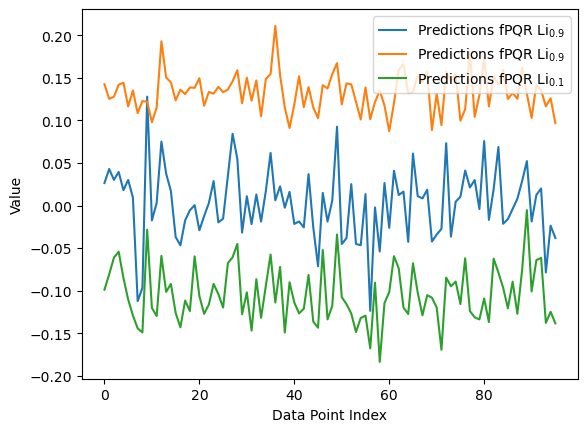

In [350]:
company = 130

# Plot df_y_test[:,18] over the previous plot
plt.plot(np.arange(df_x_test.shape[0]), predictions_pls[:,company], label='Predictions fPQR Li$_{0.9}$')# Plot predictions_li_9[:,18]
plt.plot(np.arange(df_x_test.shape[0]), predictions_li_9[:,company], label='Predictions fPQR Li$_{0.9}$')
plt.plot(np.arange(df_x_test.shape[0]), predictions_li_1[:,company], label='Predictions fPQR Li$_{0.1}$')

# Add labels and legend
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

## Plots for Quantile regression

In [187]:
# This is line is to avoid incompatibility if older SciPy version.
# You should use `solver="highs"` with recent version of SciPy.
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

In [290]:
rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x
y_normal = y_true_mean + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=len(x))

In [291]:
quantiles = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
predictions = {}
for quantile in quantiles:
    quantile_reg_model = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
    y_pred = quantile_reg_model.fit(X, y_normal).predict(X)
    predictions[quantile] = y_pred
linear_reg_model = LinearRegression()
y_pred_mean = linear_reg_model.fit(X, y_normal).predict(X)

Text(0, 0.5, 'y')

2023-09-20 16:21:06,968 - INFO - Substituting symbol E from STIXNonUnicode
2023-09-20 16:21:07,099 - INFO - Substituting symbol E from STIXNonUnicode


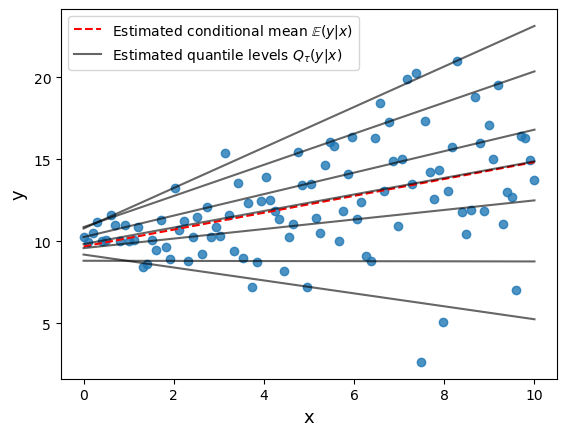

In [292]:
plt.plot(X, y_pred_mean, color="red", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, color='black', alpha=.6, label=f"Quantile: {quantile}")

plt.scatter(x, y_normal, alpha=0.8, label="Inside interval",)

plt.legend(["Estimated conditional mean $\\mathbb{E}(y| x)$"] + ["Estimated quantile levels $Q_{\\tau}(y|x)$"])
plt.xlabel("x", fontsize = 13)
plt.ylabel("y", fontsize = 13)

In [286]:
# Define new x
x = np.linspace(start=-5, stop=5, num=100)

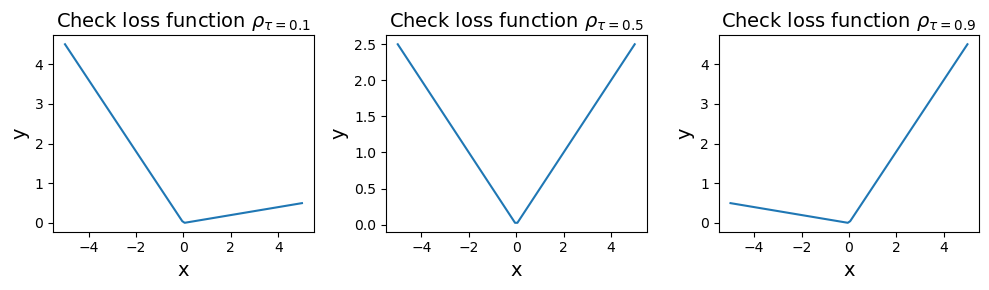

In [288]:
fig1, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].plot(x, _rho_function(x, 0.1))
axes[0].set_xlabel("x", fontsize=14)
axes[0].set_ylabel("y", fontsize=14)
axes[0].set_title("Check loss function $\\rho_{\\tau=0.1}$", fontsize=14)
axes[1].plot(x, _rho_function(x, 0.5))
axes[1].set_xlabel("x", fontsize=14)
axes[1].set_ylabel("y", fontsize=14)
axes[1].set_title("Check loss function $\\rho_{\\tau=0.5}$", fontsize=14)
axes[2].plot(x, _rho_function(x, 0.9))
axes[2].set_xlabel("x", fontsize=14)
axes[2].set_ylabel("y", fontsize=14)
axes[2].set_title("Check loss function $\\rho_{\\tau=0.9}$", fontsize=14)
plt.tight_layout()
plt.show()

A lo mejor deberíamos incluir una gráfica con las componentes de PCR, PLS y fPQR juntas en la parte predictiva del dataset, cuando se comparan RMSE's, errores cuantílicos etc. Luego, en laparte explicativa en la que solo usamos fPQR ya poner la gráfica con todos los cuantiles. Introducir esa parte explicativa como "ahora usamos todo el poder de fPQR explorando otros cuantiles y las variables más significativas para obtener las componentes de fPQR. Finalmente, podemos estimar la distribución condicional de la respuesta $Y_j\vert X=x$, para cierta empresa $j$ de interés.